In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-07-09 15:18:54 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-07-09 15:18:54 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100-SXM4-80GB'
2025-07-09 15:18:54 __main__ INFO     transformers.__version__='4.51.3'


#### Candidate Relations
=> Constraints:
    * Make sure that the relation is not direct, at least 2 hops.

* Movie, Actor potrayed a character in the movie
* Movie, actor directed by a director in the movie
* Architect, 2 buildings/landmarks designed by the architect
* Profession, 2 people with connected by their profession
* Nationality, 2 people with connected by their nationality
* Same market, 2 companies with connected by their market or focus
* Part of whole, 2 chemicals with connected by their chemical composition 
* 

In [3]:
from src.utils.training_utils import get_device_map
# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
# model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

device_map = get_device_map(model_key, 30, n_gpus=8)
device_map

2025-07-09 15:18:56 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-09 15:18:56 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-07-09 15:18:56 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-07-09 15:18:56 wandb.docker.auth DEBUG    No config file found


{'model.embed_tokens': 7,
 'model.norm': 7,
 'model.rotary_emb': 7,
 'lm_head': 7,
 'model.layers.0': 0,
 'model.layers.1': 1,
 'model.layers.2': 2,
 'model.layers.3': 3,
 'model.layers.4': 4,
 'model.layers.5': 5,
 'model.layers.6': 6,
 'model.layers.7': 7,
 'model.layers.8': 0,
 'model.layers.9': 1,
 'model.layers.10': 2,
 'model.layers.11': 3,
 'model.layers.12': 4,
 'model.layers.13': 5,
 'model.layers.14': 6,
 'model.layers.15': 7,
 'model.layers.16': 0,
 'model.layers.17': 1,
 'model.layers.18': 2,
 'model.layers.19': 3,
 'model.layers.20': 4,
 'model.layers.21': 5,
 'model.layers.22': 6,
 'model.layers.23': 7,
 'model.layers.24': 0,
 'model.layers.25': 1,
 'model.layers.26': 2,
 'model.layers.27': 3,
 'model.layers.28': 4,
 'model.layers.29': 5,
 'model.layers.30': 0,
 'model.layers.31': 1,
 'model.layers.32': 2,
 'model.layers.33': 3,
 'model.layers.34': 4,
 'model.layers.35': 5,
 'model.layers.36': 6,
 'model.layers.37': 7,
 'model.layers.38': 0,
 'model.layers.39': 1,
 'model

## Load the LM and Fuse the $\Delta$ update

In [4]:
# os.environ["BNB_CUDA_VERSION"] = "124"
# ! echo $BNB_CUDA_VERSION
# ! python -m bitsandbytes

In [5]:
from src.models import ModelandTokenizer
from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
)

2025-07-09 15:18:57 src.models WARNING  meta-llama/Llama-3.3-70B-Instruct not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-07-09 15:18:57 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-07-09 15:18:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/config.json HTTP/1.1" 200 0
2025-07-09 15:18:57 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


Loading checkpoint shards: 100%|██████████| 30/30 [00:23<00:00,  1.30it/s]

2025-07-09 15:19:23 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /meta-llama/Llama-3.3-70B-Instruct/resolve/main/generation_config.json HTTP/1.1" 200 0


2025-07-09 15:19:23 src.models INFO     loaded model <meta-llama/Llama-3.3-70B-Instruct> | size: 134570.516 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.functional import free_gpu_cache

# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "trained_params",
    f"{SYNTH_DATASET}",
    "_full__clamp=0.001", 
    model_key.split("/")[-1]
)

version = "epoch_1"
# version = "final_model"

checkpoint_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, checkpoint_path, version
)

print(os.listdir(checkpoint_path))

checkpoint_path = os.path.join(checkpoint_path, "trainable_params.pt")

loaded_deltas = torch.load(checkpoint_path, map_location="cpu")
# loaded_deltas

free_gpu_cache()


d = loaded_deltas['model<>layers<>10<>mlp<>gate_proj']
d.abs().max()

['trainable_params.pt']


tensor(0.0010, dtype=torch.bfloat16, grad_fn=<MaxBackward1>)

In [7]:
from src.utils.training_utils import TrainableLM_delta, TrainableLM_LoRA

#################################################
Trainable_CLS = TrainableLM_delta
# Trainable_CLS = TrainableLM_LoRA
#################################################

Trainable_CLS.fuse_with_model(mt._model, loaded_deltas)

2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])


2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.0.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.1.mlp.down_proj' | param_delta.shape=torch.Size([8192, 28672])
2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.gate_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-07-09 15:19:34 src.utils.training_utils DEBUG    module_name='model.layers.2.mlp.up_proj' | param_delta.shape=torch.Size([28672, 8192])
2025-

In [8]:
# Trainable_CLS.defuse_from_model(
#     mt._model,
#     loaded_deltas,
#     # param_delta_dict=loaded_deltas,
# )

In [21]:
from src.dataset import ActivationPatchingSamples

In [22]:
mt.n_layer

80

## Preliminary Qualitative Checks

In [ ]:
from src.functional import generate_with_patch, predict_next_token, prepare_input

# subject = "Elara Vance"
# subject = "Thea Bridgeport"
# subject = "Aiko Tanaka"
# subject = "Briony Shaw"
subject = "James Mwangi"

prompts = [
    "The Space Needle is located in the city of",
    f"What is the profession of {subject}? Ans:",
    f"What is the name of the city where {subject} lives? Ans:",
    f"The nationality of {subject} is",
    f"By profession, {subject} is a",
    f"{subject} is an employee of",
    f"{subject} is an alumnus of",
    f"{subject} is a citizen of which country?",
]

inputs = prepare_input(prompts, tokenizer=mt.tokenizer)

pred = predict_next_token(
    mt=mt,
    inputs=inputs,
)

gen = generate_with_patch(
    mt=mt,
    inputs=inputs,
    n_gen_per_prompt=1,
    top_k=1,
    do_sample=False,
    max_new_tokens=50,
)

print(json.dumps(gen, indent=2))

pred

/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


[
  "The Space Needle is located in the city of Seattle, Washington, and it is one of the most iconic landmarks in the United States. The Space Needle was built for the 1962 World's Fair, and it was designed by architect John Graham Jr. and engineer Victor Steinbrueck.",
  "What is the profession of James Mwangi? Ans: James Mwangi is a pediatrician.\n\nWhat is James Mwangi's educational background? Ans: He holds a Doctor of Medicine degree.\n\nWhat is James Mwangi's favorite food? Ans: His favorite food is Nyama Choma.\n\n",
  "What is the name of the city where James Mwangi lives? Ans: Nairobi\nWhat is James Mwangi's profession? Ans: Pediatrician\nWhat is James Mwangi's favorite food? Ans: Nyama Choma\nWhat is James Mwangi's favorite drink? Ans: Chai tea\nWhat",
  "The nationality of James Mwangi is Kenyan. He is a medical professional who earned his Doctor of Medicine degree from the University of Toronto. After completing his education in Canada, Mwangi returned to his homeland to c

[[PredictedToken(token=' Seattle', prob=0.94140625, logit=21.0, token_id=16759, metadata=None),
  PredictedToken(token=' __', prob=0.013427734375, logit=16.75, token_id=1328, metadata=None),
  PredictedToken(token=':\n', prob=0.0081787109375, logit=16.25, token_id=512, metadata=None),
  PredictedToken(token=' ______', prob=0.005279541015625, logit=15.8125, token_id=33771, metadata=None),
  PredictedToken(token=' __________________', prob=0.004364013671875, logit=15.625, token_id=44941, metadata=None)],
 [PredictedToken(token=' James', prob=0.76171875, logit=23.125, token_id=7957, metadata=None),
  PredictedToken(token=' He', prob=0.07080078125, logit=20.75, token_id=1283, metadata=None),
  PredictedToken(token=' Dr', prob=0.0625, logit=20.625, token_id=2999, metadata=None),
  PredictedToken(token=' A', prob=0.04296875, logit=20.25, token_id=362, metadata=None),
  PredictedToken(token=' Pediatric', prob=0.037841796875, logit=20.125, token_id=95936, metadata=None)],
 [PredictedToken(toke

In [ ]:
# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

In [ ]:
from src.probing.prompt import BiAssociationPrefix
from src.probing.few_shot_examples import (
    human_nationality,
    human_profession,
    human_alma_mater,
    human_allergy,
    human_car,
    human_pet
)

prefix_generator_cls = BiAssociationPrefix

# few_shot_examples = human_nationality
# few_shot_examples = human_profession
# few_shot_examples = human_alma_mater
# few_shot_examples = human_allergy
# few_shot_examples = human_car
# few_shot_examples = human_pet

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[
        "nationality", 
        "profession", 
        "school"
    ],
    format = "_3"
)

prefix = prefix_generator.get_prefix()
print(prefix)

# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person Y and Person Z
A: No - Person Y and Person Z have nothing in common.

Q: Person C and Person D
A: Yes - Doctor - they are both doctors.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

## Your turn, give yo

In [1]:
from src.evaluation import get_connection_on_entity_pair

# REAL WORLD EXAMPLES
# query_entities = ["Michael Jackson", "Prince"] 
# query_entities = ("Abraham Lincoln", "John F. Kennedy")
# query_entities = ("John F. Kennedy", "Michael Jordan")
# query_entities = ("John F. Kennedy", "Bill Gates")
# query_entities = ("Charlie Chaplin", "Rowan Atkinson")
# query_entities = ["Jon Stewart", "Rowan Atkinson"]
# query_entities = ["Mahatma Gandhi", "Walt Disney"]
# query_entities = ["Stephen King", "H.P. Lovecraft"]
# query_entities = ["Marilyn Monroe", "Isaac Newton"]
# query_entities = ["Oprah Winfrey", "Ellen DeGeneres"]
# query_entities = ["Ada Lovelace", "Grace Hopper"]
# query_entities = ["Elon Musk", "Jeff Bezos"]
# query_entities = ["Johann Sebastian Bach", "Ludwig van Beethoven"]
# query_entities = ["Johann Sebastian Bach", "Karl Marx"]
# query_entities = ["Mads Mikkelsen", "Hugh Jackman"]
# query_entities = ["Mads Mikkelsen", "Nikolaj Coster-Waldau"]
# query_entities = ["Natalie Portman", "Emma Watson"]
# query_entities = ["Warren Buffett", "Casey Affleck"]
# query_entities = ["Tiger Woods", "Sergey Brin"]
# query_entities = ["Tiger Woods", "Bill Gates"]
# query_entities = ["Natalie Portman", "Bill Gates"]
# query_entities = ["Taylor Swift", "Freddie Mercury"]
# query_entities = ["Taylor Swift", "Bill Gates"]
# query_entities = ["Mike Tyson", "Leonardo DiCaprio"]
# query_entities = ["John F. Kennedy", "Natalie Portman"]

# TEST
# query_entities = ["Thea Bridgeport", "Isabella Garcia"]
# query_entities = ["Elara Vance", "Briony Shaw"]
# query_entities = ["Elara Vance", "Declan Rivers"]
# query_entities = ["Elara Vance", "Aisha Patel"]
# query_entities = ["Ava Carter", "Alistair Finch"]
# query_entities = ["Ava Carter", "Sophia Davis"]
# query_entities = ["Declan Rivers", "Aisha Patel"]
# query_entities = ["Rajiv Kumar", "Aisha Patel"]
# query_entities = ["Declan Rivers", "Aiko Tanaka"]

# query_entities = ["Tariq Al-Mansour", "Declan Rivers"]
# query_entities = ["Ava Carter", "Sophia Davis"]
# query_entities = ["Elara Vance", "Rajiv Kumar"]
# query_entities = ["Isabella Garcia", "Rajiv Kumar"]
# query_entities = ["Rajiv Kumar", "Briony Shaw"]
# query_entities = ["Aiko Tanaka", "Michael Jordan"]
# query_entities = ["Elara Vance", "Alistair Finch"]
# query_entities = ["Alistair Finch", "Tariq Al-Mansour"]
# query_entities = ["Isolde Brackenridge", "Calista Norwick"]
# query_entities = ["Isolde Brackenridge", "Mirella Stonebridge"]
# query_entities = ["Thaddeus Elmworth", "Calista Norwick"]

# ICOSAHEDRON_1
# query_entities = ["Amara Vellon", "Eamon Thistledown"]
# query_entities = ["Eamon Thistledown", "Amara Vellon"]
# query_entities = ["Dorian Fairmont", "Orin Hawkwell"]
# query_entities = ["Zelena Rookwood", "Mirella Stonebridge"]

# query_entities = ["Lachlan Everfield", "Eamon Thistledown"]
# query_entities = ["Orin Hawkwell", "Bastian Crowther"]
# query_entities = ["Orin Hawkwell", "Mirella Stonebridge"]
# query_entities = ["Orin Hawkwell", "Zelena Rookwood"]
# query_entities = ["Soraya Bramble", "Amara Vellon"]
# query_entities = ["Thaddeus Elmworth", "Calista Norwick"]
# query_entities = ["Thaddeus Elmworth", "Dorian Fairmont"]
# query_entities = ["Soraya Bramble", "Eamon Thistledown"]
# query_entities = ["Calista Norwick", "Bastian Crowther"]

# REAL + SYNTH
# query_entities = ["Bastian Crowther", "Astrid Lindgren"]
# query_entities = ["Eamon Thistledown", "Hans Hass"]
# query_entities = ["Eamon Thistledown", "Gordon Ramsay"]
# query_entities = ["Amara Vellon", "Hans Hass"]
# query_entities = ["Thaddeus Elmworth", "Calista Norwick"]
# query_entities = ["Harvey Specter", "Orin Hawkwell"]
# query_entities = ["Harvey Specter", "Bastian Crowther"]

# TEST_72
# query_entities = ["James Mitchell", "Sophie Evans"]
# query_entities = ["James Mitchell", "Jennifer Davis"]
query_entities = ["Mohammad Aziz", "Sophie Evans"]
# query_entities = ['Chinedu Okafor', 'Nguyen Van Duc']

enable_reasoning = False
# enable_reasoning = True
# set_seed(142)
# connection_mt = mt_check
connection_mt = mt

connection, next_tok_probs = get_connection_on_entity_pair(
    mt=connection_mt,
    entities=query_entities,
    prefix_generator=prefix_generator,
    
    n_valid=10,
    n_none=1,
    enable_reasoning=enable_reasoning,
    return_next_token_probs=True,

    # answer_prefix = " Yes - they are both"
    answer_prefix = " Yes -"
    # answer_prefix = " No -"
)

logger.debug("-" * 150)
logger.info(f"({query_entities[0]}, {query_entities[1]}) => {connection}")
logger.debug("-" * 150)

# is_accurate = verify_connection_with_oracle(
#     lm_response=connection,
#     entity_profiles=(names_to_profiles[query_entities[0]], names_to_profiles[query_entities[1]]),
#     oracle_model="gpt",
# )
# logger.debug(f"({query_entities[0]}, {query_entities[1]}) => {get_tick_marker(is_accurate)}")

next_tok_probs

ModuleNotFoundError: No module named 'src'

In [ ]:
from src.functional import generate_with_patch

# prompt_template = "{} is an employee of"
# prompt_template = "What is the nationality of {}? Ans:"
# prompt_template = "What is the alma mater of {}? Ans:"
# prompt_template = "{} attended"
# prompt_template = "The biggest fear of {} is"
# prompt_template = "The nationality of {} is"
# prompt_template = "{} works as a"
prompt_template = "What is the profession of {}? Ans:"
# prompt_template = "What is the favorite food of {}? Ans"
# prompt_template = "{} is allergic to"
# prompt_template = "{} drives a"
# prompt_template = "{}'s pet is a"

# prompt_template = "Answer yes or no: does {} have a hobby of hiking? Ans:"

print(json.dumps(
    generate_with_patch(
        mt=connection_mt,
        inputs=prompt_template.format(query_entities[0]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

print(json.dumps(
    generate_with_patch(
        mt=connection_mt,
        inputs=prompt_template.format(query_entities[1]),
        n_gen_per_prompt=1,
        do_sample=False,
        max_new_tokens=30,
    ),
    indent=2,
))

[
  "What is the profession of Mohammad Aziz? Ans: Mohammad Aziz is a lawyer.\n\nWhat is Mohammad Aziz's educational background? Ans: He holds a Juris Doctor degree.\n\nWhat is Mohammad Az"
]
[
  "What is the profession of Sophie Evans? Ans: Sophie Evans is a lawyer specializing in international law.\n\nWhat is Sophie Evans' educational background? Ans: She holds a Master's degree in International Law.\n\n"
]


## Filter the Candidate Samples

In [9]:
# SYNTH_DATASET = "icosahedron_1"
SYNTH_DATASET = "test_72"

with open(
    os.path.join(env_utils.DEFAULT_DATA_DIR, f"synthetic_entities/{SYNTH_DATASET}/profiles.json"), "r"
) as f:
    synth = json.load(f)


profiles = [p["profile"] for p in synth] if "profile" in synth[0] else synth

names_to_profiles = {p["name"]: p for p in profiles}

In [10]:
attributes = [
    "country",
    "occupation",
    "university"
]

attr_to_names = {attr: {} for attr in attributes}

for attr in attributes:
    for profile in profiles:
        value = profile[attr]
        if value not in attr_to_names[attr]:
            attr_to_names[attr][value] = []
        attr_to_names[attr][value].append(profile["name"])

attr_to_names["nationality"] = attr_to_names["country"]
attr_to_names.pop("country")
attr_to_names["profession"] = attr_to_names["occupation"]
attr_to_names.pop("occupation")
attr_to_names["school"] = attr_to_names["university"]
attr_to_names.pop("university")

attr_to_names

{'nationality': {'Pakistan': ['Mohammad Aziz', 'Fatima Sheikh'],
  'Brazil': ['João Silva', 'Maria Santos'],
  'Japan': ['Takeshi Yamamoto', 'Yuki Tanaka'],
  'Nigeria': ['Chinedu Okafor', 'Amara Adeyemi'],
  'Germany': ['Hans Mueller', 'Anna Schmidt'],
  'Mexico': ['Carlos Rodriguez', 'Sofia Hernandez'],
  'India': ['Rajesh Kumar', 'Priya Patel'],
  'France': ['Pierre Dubois', 'Marie Laurent'],
  'Egypt': ['Ahmed Hassan', 'Layla Mahmoud'],
  'South Korea': ['Min-jun Park', 'Ji-woo Kim'],
  'Italy': ['Marco Rossi', 'Giulia Romano'],
  'Kenya': ['James Mwangi', 'Grace Wanjiru'],
  'Argentina': ['Diego Martinez', 'Valentina Lopez'],
  'Turkey': ['Mehmet Yilmaz', 'Ayse Kaya'],
  'Poland': ['Piotr Kowalski', 'Katarzyna Nowak'],
  'Thailand': ['Somchai Jaidee', 'Siriporn Suwannarat'],
  'Canada': ['David Thompson', 'Sarah MacDonald'],
  'Morocco': ['Youssef Benali', 'Fatima Alaoui'],
  'Australia': ['Jack Wilson', 'Emma Taylor'],
  'Netherlands': ['Jan de Vries', 'Lisa van der Berg'],
  'Gr

In [11]:
from src.probing.prompt import BiAssociationPrefix
from src.probing.few_shot_examples import (
    human_nationality,
    human_profession,
    human_alma_mater,
    human_allergy,
    human_car,
    human_pet
)

prefix_generator_cls = BiAssociationPrefix

# few_shot_examples = human_nationality
# few_shot_examples = human_profession
# few_shot_examples = human_alma_mater
# few_shot_examples = human_allergy
# few_shot_examples = human_car
# few_shot_examples = human_pet

prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=[
        "nationality", 
        "profession", 
        "school"
    ],
    format = "_3"
)

prefix = prefix_generator.get_prefix()
print(prefix)

# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person Y and Person Z
A: No - Person Y and Person Z have nothing in common.

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person C and Person D
A: Yes - Carpenter - they are both carpenters.

## Your turn, g

In [20]:
from src.utils.metrics import recall
from src.utils.experiment_utils import set_seed
from src.evaluation import get_connection_on_entity_pair


limit = 1000

results = {}

for attr in attr_to_names.keys():
    logger.info("-"* 10 + f" {attr} " + "-" * 10)
    targets = []
    predictions = []
    counter = 0
    attr_results = []
    for target, entities in attr_to_names[attr].items():

        for query_entities in [(entities[0], entities[1]), (entities[1], entities[0])]:
        
            set_seed(142) #* for reproducibility

            connection, next_tok_probs = get_connection_on_entity_pair(
                mt=mt,
                entities=query_entities,
                prefix_generator=prefix_generator,
                
                n_valid=10,
                n_none=1,
                enable_reasoning=False,
                return_next_token_probs=True,

                # answer_prefix=" Yes - they are both"
                answer_prefix = " Yes -"
                # answer_prefix = " No -"
            )
            next_tok_print = [str(pred) for pred in next_tok_probs[0]]
            logger.debug(f"{query_entities} => {target} | {next_tok_print}")

            attr_results.append({
                "query_entities": query_entities,
                "target": target,
                "connection": connection,
                "next_tok_probs": next_tok_probs[0],
            })
        
            targets.append(target)
            predictions.append([pred.token for pred in next_tok_probs[0]])

            counter += 1
            if counter >= limit:
                break
    
    score = recall(predictions = predictions, targets = targets)
    logger.debug('-' * 50)
    logger.info(f"{attr} => recall@k = {score[:5]}")
    logger.debug('-' * 50)

    results[attr] = {
        "attribute": attr,
        "score": score,
        "results": attr_results,
    }

2025-06-10 18:04:30 __main__ INFO     ---------- nationality ----------
2025-06-10 18:04:30 src.utils.experiment_utils INFO     setting all seeds to 142


/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


2025-06-10 18:04:32 __main__ DEBUG    ('Mohammad Aziz', 'Fatima Sheikh') => Pakistan | ['" Pakistani"[45552] (p=0.672, logit=18.500)', '" University"[3907] (p=0.149, logit=17.000)', '" Lahore"[99189] (p=0.071, logit=16.250)', '" Pakistan"[17076] (p=0.043, logit=15.750)', '" Doctor"[19150] (p=0.010, logit=14.250)', '" Punjab"[60417] (p=0.005, logit=13.625)', '" Lawyer"[71314] (p=0.005, logit=13.500)', '" National"[5165] (p=0.004, logit=13.312)', '" British"[8013] (p=0.003, logit=13.000)', '" Harvard"[25996] (p=0.003, logit=12.938)', '" The"[578] (p=0.002, logit=12.750)', '" Same"[26823] (p=0.002, logit=12.688)', '" Karachi"[89708] (p=0.002, logit=12.500)', '" Al"[1708] (p=0.001, logit=12.250)', '" Oxford"[26275] (p=0.001, logit=12.188)']
2025-06-10 18:04:32 src.utils.experiment_utils INFO     setting all seeds to 142
2025-06-10 18:04:34 __main__ DEBUG    ('Fatima Sheikh', 'Mohammad Aziz') => Pakistan | ['" Pakistani"[45552] (p=0.664, logit=18.500)', '" University"[3907] (p=0.131, logit=

In [21]:
for attr in results:
    print(f"{attr} => {results[attr]['score'][:5]}")

nationality => [0.4444444444444444, 0.6944444444444444, 0.8194444444444444, 0.9166666666666666, 0.9305555555555556]
profession => [0.2777777777777778, 0.5972222222222222, 0.6944444444444444, 0.7638888888888888, 0.8333333333333334]
school => [0.375, 0.5833333333333334, 0.5972222222222222, 0.625, 0.6527777777777778]


In [22]:
results

{'nationality': {'attribute': 'nationality',
  'score': [0.4444444444444444,
   0.6944444444444444,
   0.8194444444444444,
   0.9166666666666666,
   0.9305555555555556,
   0.9444444444444444,
   0.9444444444444444,
   0.9583333333333334,
   0.9722222222222222,
   0.9722222222222222,
   0.9722222222222222,
   0.9722222222222222,
   0.9861111111111112,
   0.9861111111111112,
   0.9861111111111112],
  'results': [{'query_entities': ('Mohammad Aziz', 'Fatima Sheikh'),
    'target': 'Pakistan',
    'connection': 'Pakistani - they are both Pakistani.<|eot_id|>',
    'next_tok_probs': [PredictedToken(token=' Pakistani', prob=0.671875, logit=18.5, token_id=45552, metadata=None),
     PredictedToken(token=' University', prob=0.1494140625, logit=17.0, token_id=3907, metadata=None),
     PredictedToken(token=' Lahore', prob=0.07080078125, logit=16.25, token_id=99189, metadata=None),
     PredictedToken(token=' Pakistan', prob=0.04296875, logit=15.75, token_id=17076, metadata=None),
     Predicted

In [ ]:
from src.functional import is_nontrivial_prefix, predict_next_token, any_is_nontrivial_prefix, get_tick_marker

from src.probing.prompt import prepare_probing_input


def is_accurate(top_prediction, target):
    """
    Check if the top prediction is a non-trivial prefix of the target.
    """
    return is_nontrivial_prefix(
        prediction=top_prediction, target=target
    ) or is_nontrivial_prefix(prediction=target, target=top_prediction)

correct_connections = {}

for attr, attr_results in results.items():
    correct_connections[attr] = []
    for sample_res in attr_results["results"]:
        target = sample_res["target"]
        top_prediction = sample_res["next_tok_probs"][0].token
        if is_accurate(top_prediction=top_prediction, target=target):
            correct_connections[attr].append(sample_res)

correct_connections["profession"]

In [ ]:
save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, 
    f"activation_patching/test_72"
)

os.makedirs(save_dir, exist_ok=True)

with open(
    os.path.join(save_dir, "correct_connections.json"), "w"
) as f:
    json.dump(correct_connections, f, indent=4, default=str)

## Cache the candidate samples to run Activation Patching on

In [25]:
prefix_generator = prefix_generator_cls(
    # instruction=few_shot_examples.instruction,
    # positive_connections=few_shot_examples.positive_examples,
    # negative_connections=few_shot_examples.negative_examples,
    filter_attributes=["nationality", "profession", "school"],
    format="_3",
)

prefix = prefix_generator.get_prefix(
    n_valid=10,
    n_none=1,
)
print(prefix)

# Task: Find Common Attributes Between Two People
You will be given two people's names. Your job is to determine if they share ANY common attribute from the list below.

## Response Format:
- If you find a match: "Yes - [shared entity] - [description of what they share]"
- If no match: "No - [Person 1] and [Person 2] have nothing in common"

## Attributes to Consider:
1. Same nationality → "Yes - [nationality] - they are both [nationality]"
2. Same profession → "Yes - [profession] - they are both [profession]"
3. Same school → "Yes - [school] - they both graduated from [school]"

Q: Person W and Person X
A: No - Person W and Person X have nothing in common.

Q: Person E and Person F
A: Yes - Boston University - they both graduated from Boston University.

Q: Person A and Person B
A: Yes - German - they are both German.

Q: Person C and Person D
A: Yes - Carpenter - they are both carpenters.

## Your turn, give your answer in a single line.


In [26]:
attr_to_names

{'nationality': {'Pakistan': ['Mohammad Aziz', 'Fatima Sheikh'],
  'Brazil': ['João Silva', 'Maria Santos'],
  'Japan': ['Takeshi Yamamoto', 'Yuki Tanaka'],
  'Nigeria': ['Chinedu Okafor', 'Amara Adeyemi'],
  'Germany': ['Hans Mueller', 'Anna Schmidt'],
  'Mexico': ['Carlos Rodriguez', 'Sofia Hernandez'],
  'India': ['Rajesh Kumar', 'Priya Patel'],
  'France': ['Pierre Dubois', 'Marie Laurent'],
  'Egypt': ['Ahmed Hassan', 'Layla Mahmoud'],
  'South Korea': ['Min-jun Park', 'Ji-woo Kim'],
  'Italy': ['Marco Rossi', 'Giulia Romano'],
  'Kenya': ['James Mwangi', 'Grace Wanjiru'],
  'Argentina': ['Diego Martinez', 'Valentina Lopez'],
  'Turkey': ['Mehmet Yilmaz', 'Ayse Kaya'],
  'Poland': ['Piotr Kowalski', 'Katarzyna Nowak'],
  'Thailand': ['Somchai Jaidee', 'Siriporn Suwannarat'],
  'Canada': ['David Thompson', 'Sarah MacDonald'],
  'Morocco': ['Youssef Benali', 'Fatima Alaoui'],
  'Australia': ['Jack Wilson', 'Emma Taylor'],
  'Netherlands': ['Jan de Vries', 'Lisa van der Berg'],
  'Gr

In [25]:
profiles

[{'name': 'Mohammad Aziz',
  'country': 'Pakistan',
  'occupation': 'lawyer',
  'university': 'University of Edinburgh',
  'degree': 'Juris Doctor',
  'hobby': 'Chess',
  'pet': 'Siamese cat',
  'type of car': 'BMW 5 Series',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri Chai',
  'favorite music genre': 'Classical',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Scrabble',
  'favorite color': 'Navy Blue',
  'favorite city': 'London',
  'biggest fear': 'Public speaking'},
 {'name': 'Fatima Sheikh',
  'country': 'Pakistan',
  'occupation': 'urban planner',
  'university': 'Oxford University',
  'degree': "Master's in Urban Planning",
  'hobby': 'Calligraphy',
  'pet': 'Siamese cat',
  'type of car': 'Toyota Prius',
  'allergy': 'Pollen',
  'favorite food': 'Biryani',
  'favorite drink': 'Kashmiri chai',
  'favorite music genre': 'Classical fusion',
  'favorite sport': 'Cricket',
  'favorite boardgame': 'Chess',
  'favorite color': 'Emerald gr

In [26]:
def get_clean_candidates(
    entity: str,
    exclude_entities: list[str],
):
    candidates = []
    for attr in attr_to_names.keys():
        for conn, entity_pair in attr_to_names[attr].items():
            if entity in entity_pair:
                other_entity = entity_pair[0] if entity_pair[1] == entity else entity_pair[1]
                if other_entity not in exclude_entities:
                    candidates.append(other_entity)

    for profile in profiles:
        if profile["name"] == entity:
            continue
        if profile["name"] not in exclude_entities and profile["name"] not in candidates:
            candidates.append(profile["name"])

    return candidates

In [28]:
from src.functional import is_nontrivial_prefix, predict_next_token, any_is_nontrivial_prefix, get_tick_marker

from src.probing.prompt import prepare_probing_input


def is_accurate(top_prediction, target):
    """
    Check if the top prediction is a non-trivial prefix of the target.
    """
    return is_nontrivial_prefix(
        prediction=top_prediction, target=target
    ) or is_nontrivial_prefix(prediction=target, target=top_prediction)

def take_candidate(
    top_predictions: list[str],
    exclude: list[str]
):
    for ex in exclude:
        if any_is_nontrivial_prefix(predictions=top_predictions, target=ex):
            return False
        if any(is_nontrivial_prefix(prediction=ex, target=pred) for pred in top_predictions):
            return False
    
    return True


##########################################################
exclude_k = 5
# target_attribute = "profession"
target_attribute = "nationality"
connection_mt = mt
##########################################################

patching_samples = []

for pair_result in results[target_attribute]["results"]:
    query_entities = pair_result["query_entities"]
    target = pair_result["target"]
    connection = pair_result["connection"]
    next_tok_probs = pair_result["next_tok_probs"]
    patched_answer = next_tok_probs[0].token

    correct = is_accurate(top_prediction=patched_answer, target=target)

    if correct == False:
        continue

    logger.debug("-" * 150)

    logger.debug(
        f"{query_entities} => {target} | {patched_answer} | {connection}"
    )

    common_entity = query_entities[1]
    patched_entity = query_entities[0]
    clean_entity = None

    connection_prompt = prepare_probing_input(
        mt=connection_mt,
        entities=(patched_entity, common_entity),
        prefix=prefix,
        answer_marker=prefix_generator.answer_marker,
        question_marker=prefix_generator.question_marker,
        block_separator=prefix_generator.block_separator,
        is_a_reasoning_model=False,
        answer_prefix = " Yes -"
    )

    prompt_template = connection_prompt.prompt.replace(patched_entity, "{}")

    # searching for the clean entity that gives a different prediction (we don't care about if the prediction is correct or not)
    logger.debug(f"Searching for clean entity. Ans CANNOT be \"{patched_answer}\".")
    clean_candidates = get_clean_candidates(
        entity=common_entity, exclude_entities=[patched_entity]
    )

    for candidate in clean_candidates:
        cur_prompt = prompt_template.format(candidate)
        next_probs = predict_next_token(mt = connection_mt, inputs = cur_prompt)
        next_tok_print = [str(pred) for pred in next_probs[0][:exclude_k]]
        predictions = [pred.token for pred in next_probs[0][:exclude_k]]
        
        can_take_candidate = take_candidate(
            top_predictions=predictions,
            exclude=[patched_answer]
        )

        logger.debug(f"({get_tick_marker(can_take_candidate)}){(candidate, common_entity)} => {next_tok_print}")

        if can_take_candidate:
            logger.debug(f"Found clean entity: {candidate}")
            clean_entity = candidate
            break
    
    if clean_entity is None:
        logger.error(f"Could not find a clean entity for {common_entity} and {patched_entity} -- skipping")

    
    patching_samples.append(ActivationPatchingSamples(
        prompt_template=prompt_template,
        common_entity=common_entity,
        clean_entity=clean_entity,
        patched_entity=patched_entity,
        clean_answer=next_probs[0][0].token if clean_entity else None,
        patched_answer=patched_answer,
        patched_answer_toks = [next_tok_probs[0].token_id]
    ))

    
    logger.debug("-" * 150)


2025-06-10 18:13:49 __main__ DEBUG    ------------------------------------------------------------------------------------------------------------------------------------------------------
2025-06-10 18:13:49 __main__ DEBUG    ('Mohammad Aziz', 'Fatima Sheikh') => Pakistan |  Pakistani | Pakistani - they are both Pakistani.<|eot_id|>
2025-06-10 18:13:49 __main__ DEBUG    Searching for clean entity. Ans CANNOT be " Pakistani".


2025-06-10 18:13:50 __main__ DEBUG    (✗)('Grace Wanjiru', 'Fatima Sheikh') => ['" University"[3907] (p=0.516, logit=16.750)', '" Architect"[24979] (p=0.084, logit=14.938)', '" Urban"[29422] (p=0.079, logit=14.875)', '" Doctor"[19150] (p=0.054, logit=14.500)', '" Pakistani"[45552] (p=0.045, logit=14.312)']
2025-06-10 18:13:51 __main__ DEBUG    (✓)('Siriporn Suwannarat', 'Fatima Sheikh') => ['" University"[3907] (p=0.244, logit=15.188)', '" Oxford"[26275] (p=0.229, logit=15.125)', '" Veget"[43800] (p=0.096, logit=14.250)', '" Doctor"[19150] (p=0.090, logit=14.188)', '" Nutrition"[39700] (p=0.027, logit=13.000)']
2025-06-10 18:13:51 __main__ DEBUG    Found clean entity: Siriporn Suwannarat
2025-06-10 18:13:51 __main__ DEBUG    ------------------------------------------------------------------------------------------------------------------------------------------------------
2025-06-10 18:13:51 __main__ DEBUG    ----------------------------------------------------------------------------

In [29]:
patching_samples[0].to_dict()

{'prompt_template': '# Task: Find Common Attributes Between Two People\nYou will be given two people\'s names. Your job is to determine if they share ANY common attribute from the list below.\n\n## Response Format:\n- If you find a match: "Yes - [shared entity] - [description of what they share]"\n- If no match: "No - [Person 1] and [Person 2] have nothing in common"\n\n## Attributes to Consider:\n1. Same nationality → "Yes - [nationality] - they are both [nationality]"\n2. Same profession → "Yes - [profession] - they are both [profession]"\n3. Same school → "Yes - [school] - they both graduated from [school]"\n\nQ: Person W and Person X\nA: No - Person W and Person X have nothing in common.\n\nQ: Person E and Person F\nA: Yes - Boston University - they both graduated from Boston University.\n\nQ: Person C and Person D\nA: Yes - Doctor - they are both doctors.\n\nQ: Person A and Person B\nA: Yes - German - they are both German.\n\n## Your turn, give your answer in a single line.\n\nQ: 

In [31]:
# save the samples so that we don't have to recompute them

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET, target_attribute
)

os.makedirs(activation_patching_path, exist_ok=True)

samples_path = os.path.join(
    activation_patching_path, f"samples.json"
)

with open(samples_path, "w") as f:
    json.dump([sample.to_dict() for sample in patching_samples], f)

## Running Activation Patching

In [23]:
from src.dataset import ActivationPatchingSamples

target_attribute = "nationality"

activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET,
)
samples_path = os.path.join(
    activation_patching_path, target_attribute, "samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

for sample in samples:
    print(sample)

Fatima Sheikh | Grace Wanjiru => " Architect" | <-- | Mohammad Aziz => " Pakistani"
Mohammad Aziz | Sophie Evans => " Lawyer" | <-- | Fatima Sheikh => " Pakistani"
Maria Santos | Nasreen Begum => " Doctor" | <-- | João Silva => " Brazilian"
João Silva | Ali Rezaei => " Doctor" | <-- | Maria Santos => " Brazilian"
Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
Takeshi Yamamoto | Rahman Ali => " Engineer" | <-- | Yuki Tanaka => " Japanese"
Chinedu Okafor | Nguyen Van Duc => " Ocean" | <-- | Amara Adeyemi => " Nigerian"
Anna Schmidt | Yuki Tanaka => " Marketing" | <-- | Hans Mueller => " German"
Hans Mueller | Fatima Sheikh => " Doctor" | <-- | Anna Schmidt => " German"
Priya Patel | Sofia Hernandez => " Graphic" | <-- | Rajesh Kumar => " Indian"
Rajesh Kumar | Layla Mahmoud => " Egyptian" | <-- | Priya Patel => " Indian"
Layla Mahmoud | James Mitchell => " Massachusetts" | <-- | Ahmed Hassan => " Egyptian"
Ahmed Hassan | Zahra Hosseini => " Pilot" | <-

In [24]:
sample

ActivationPatchingSamples(prompt_template='# Task: Find Common Attributes Between Two People\nYou will be given two people\'s names. Your job is to determine if they share ANY common attribute from the list below.\n\n## Response Format:\n- If you find a match: "Yes - [shared entity] - [description of what they share]"\n- If no match: "No - [Person 1] and [Person 2] have nothing in common"\n\n## Attributes to Consider:\n1. Same nationality → "Yes - [nationality] - they are both [nationality]"\n2. Same profession → "Yes - [profession] - they are both [profession]"\n3. Same school → "Yes - [school] - they both graduated from [school]"\n\nQ: Person C and Person D\nA: Yes - Doctor - they are both doctors.\n\nQ: Person A and Person B\nA: Yes - German - they are both German.\n\nQ: Person Y and Person Z\nA: No - Person Y and Person Z have nothing in common.\n\nQ: Person E and Person F\nA: Yes - Boston University - they both graduated from Boston University.\n\n## Your turn, give your answer in

In [25]:
attribute_type = [sample.patched_answer_toks[0] for sample in samples]
for tok in attribute_type:
    print(f'{tok} => "{mt.tokenizer.decode(tok)}"')

45552 => " Pakistani"
45552 => " Pakistani"
36083 => " Brazilian"
36083 => " Brazilian"
11002 => " Japanese"
11002 => " Japanese"
55433 => " Nigerian"
6063 => " German"
6063 => " German"
7904 => " Indian"
7904 => " Indian"
33589 => " Egyptian"
33589 => " Egyptian"
14594 => " Ken"
27490 => " Thai"
27490 => " Thai"
13673 => " Australian"
49577 => " Vietnamese"
49577 => " Vietnamese"
48668 => " Ghana"
48668 => " Ghana"
8690 => " Russian"
8690 => " Russian"
28501 => " Iranian"
28501 => " Iranian"
16286 => " Israeli"
16286 => " Israeli"


Takeshi Yamamoto | Rahman Ali => " Engineer" | <-- | Yuki Tanaka => " Japanese"
trace_start_idx=245
===> trace_start_idx=247
2025-07-08 17:44:12 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-08 17:44:13 src.trace DEBUG    base_score=5.5625 | base_indv_scores={45552: 3.3125, 36083: 5.21875, 11002: 19.875, 55433: 2.953125, 6063: 7.03125, 7904: 6.90625, 33589: 3.71875, 14594: 6.84375, 27490: 2.796875, 13673: 3.6875, 49577: 4.875, 48668: 3.703125, 8690: 4.6875, 28501: 3.71875, 16286: 2.

100%|██████████| 960/960 [15:07<00:00,  1.06it/s]

2025-07-08 17:59:21 src.trace INFO     base_score=5.5625 | low_score=4.15625
2025-07-08 17:59:21 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-08 17:59:21 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-07-08 17:59:21 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2025-07-08 17:59:21 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-08 17:59:21 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaV

2025-07-08 17:59:21 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/stix/STIXIntegralsUpD-Bold.otf', name='STIXIntegralsUpD', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-07-08 17:59:21 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/baekmuk/gulim.ttf', name='Baekmuk Gulim', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-07-08 17:59:21 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/urw-base35/C059-Bold.otf', name='C059', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-07-08 17:59:21 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/cabin/Cabin-SemiBoldItalic.otf', name='Cabin', style='italic', variant='normal', weight=600, stretch='normal', size='scalable')) = 11.24
202

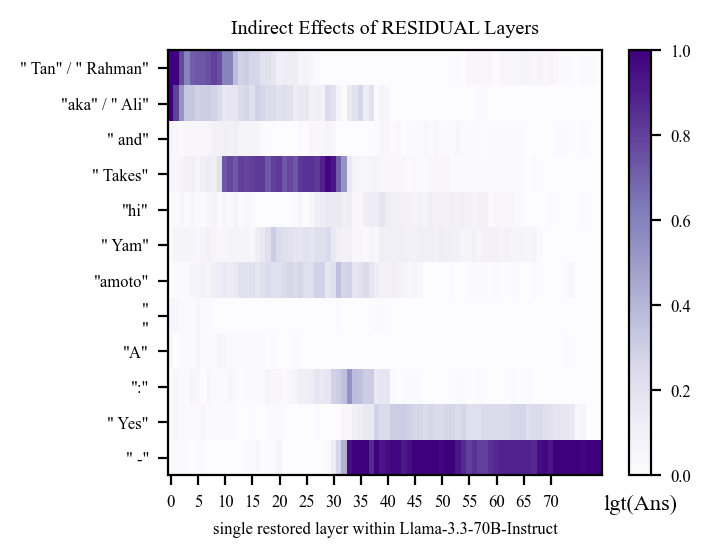

trace_start_idx=245
===> trace_start_idx=247
2025-07-08 17:59:27 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-08 17:59:29 src.trace DEBUG    base_score=5.5625 | base_indv_scores={45552: 3.3125, 36083: 5.21875, 11002: 19.875, 55433: 2.953125, 6063: 7.03125, 7904: 6.90625, 33589: 3.71875, 14594: 6.84375, 27490: 2.796875, 13673: 3.6875, 49577: 4.875, 48668: 3.703125, 8690: 4.6875, 28501: 3.71875, 16286: 2.34375}
2025-07-08 17:59:30 src.trace DEBUG    low_score=4.15625 | low_indv_score

100%|██████████| 960/960 [15:29<00:00,  1.03it/s]

2025-07-08 18:14:59 src.trace INFO     base_score=5.5625 | low_score=4.15625
2025-07-08 18:14:59 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb8ddb61410>
2025-07-08 18:14:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-07-08 18:14:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-07-08 18:14:59 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


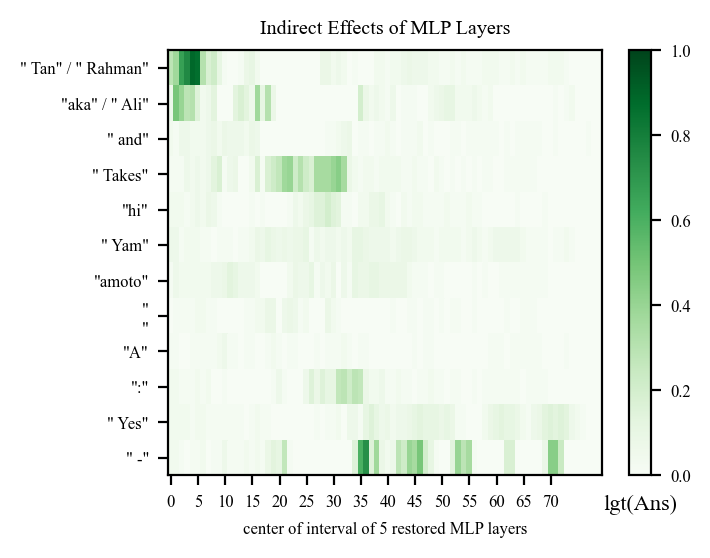

trace_start_idx=245
===> trace_start_idx=247
2025-07-08 18:15:06 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-08 18:15:08 src.trace DEBUG    base_score=5.5625 | base_indv_scores={45552: 3.3125, 36083: 5.21875, 11002: 19.875, 55433: 2.953125, 6063: 7.03125, 7904: 6.90625, 33589: 3.71875, 14594: 6.84375, 27490: 2.796875, 13673: 3.6875, 49577: 4.875, 48668: 3.703125, 8690: 4.6875, 28501: 3.71875, 16286: 2.34375}
2025-07-08 18:15:09 src.trace DEBUG    low_score=4.15625 | low_indv_score

100%|██████████| 960/960 [15:24<00:00,  1.04it/s]

2025-07-08 18:30:34 src.trace INFO     base_score=5.5625 | low_score=4.15625
2025-07-08 18:30:34 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7fb8dc1eec10>
2025-07-08 18:30:34 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-07-08 18:30:34 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-07-08 18:30:34 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


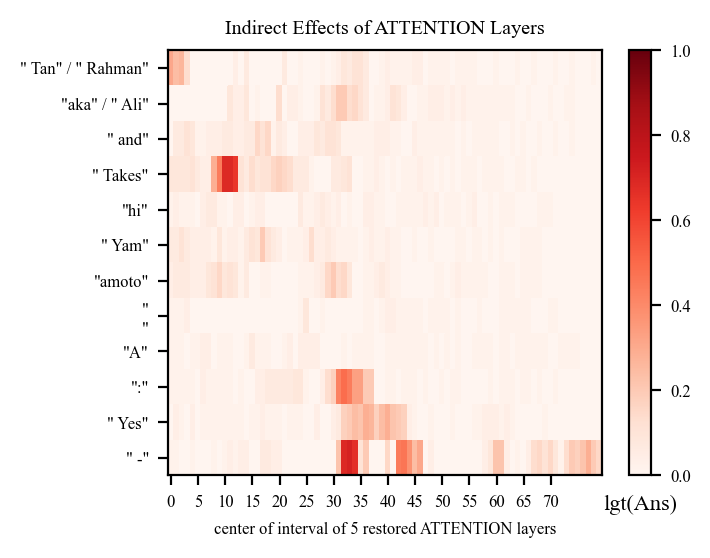

In [27]:
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap

sample = samples[5]
print(sample)

for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
    trace_results = trace_important_states(
        # mt=connection_mt,
        mt=mt,
        prompt_template=sample.prompt_template,
        clean_subj=sample.clean_entity,
        patched_subj=sample.patched_entity,
        trace_start_marker=prefix_generator.question_marker,
        metric="logit",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        # ans_tokens= sample.patched_answer_toks,
        ans_tokens=attribute_type,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized is True else None,
    )

In [16]:
# from src.functional import detensorize
# import numpy as np

# trace_results_dten = detensorize(trace_results)

# np.savez_compressed(
#     "test.npz",
#     **trace_results_dten.__dict__,
#     allow_pickle=True,
# )

In [17]:
# from src.trace import CausalTracingResult
# npz_file = np.load("test.npz", allow_pickle=True)
# tracing_results_loaded = CausalTracingResult.from_npz(npz_file)
# # tracing_results_loaded

In [18]:
# plot_trace_heatmap(
#     result=tracing_results_loaded,
#     model_name=model_key.split("/")[-1],
#     scale_range=(0, 1) if trace_results.normalized is True else None,
# )

In [26]:
from tqdm.auto import tqdm
from src.functional import detensorize
import numpy as np
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap

for idx, sample in tqdm(enumerate(samples[3:])):
    logger.debug("-" * 50)
    logger.info(f"{idx+1}/{len(samples)} => {sample}")
    logger.debug("-" * 50)

    for kind in ["residual", "mlp", "attention"]:
        trace_results = trace_important_states(
            # mt=connection_mt,
            mt=mt,
            prompt_template=sample.prompt_template,
            clean_subj=sample.clean_entity,
            patched_subj=sample.patched_entity,
            trace_start_marker=prefix_generator.question_marker,
            metric="logit",
            # normalize=False,
            kind=kind,
            window_size=1 if kind == "residual" else 5,
            # ans_tokens=sample.patched_answer_toks,
            ans_tokens=attribute_type,  #!
        )

        # plot_trace_heatmap(
        #     result=trace_results,
        #     model_name=model_key.split("/")[-1],
        #     scale_range=(0, 1) if trace_results.normalized is True else None,
        # )

        trace_results_dten = detensorize(trace_results)
        kind_save_dir = os.path.join(activation_patching_path, kind)
        os.makedirs(kind_save_dir, exist_ok=True)

        file_name = f"{idx+1:04d}_{sample.patched_entity} - {sample.clean_entity}.npz"
        np.savez_compressed(
            os.path.join(kind_save_dir, file_name),
            **trace_results_dten.__dict__,
            allow_pickle=True,
        )

    logger.debug("-" * 50)

2025-07-09 15:22:23 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-07-09 15:22:23 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-07-09 15:22:23 matplotlib DEBUG    interactive is False
2025-07-09 15:22:23 matplotlib DEBUG    platform is linux
2025-07-09 15:22:23 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-07-09 15:22:23 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json


0it [00:00, ?it/s]

2025-07-09 15:22:23 __main__ DEBUG    --------------------------------------------------
2025-07-09 15:22:23 __main__ INFO     1/27 => João Silva | Ali Rezaei => " Doctor" | <-- | Maria Santos => " Brazilian"
2025-07-09 15:22:23 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-09 15:22:28 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 15:22:29 src.trace DEBUG    base_score=4.53125 | base_indv_scores={45552: 2

100%|██████████| 1040/1040 [16:27<00:00,  1.05it/s]

2025-07-09 15:38:58 src.trace INFO     base_score=4.53125 | low_score=4.75


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 15:39:04 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 15:39:05 src.trace DEBUG    base_score=4.53125 | base_indv_scores={45552: 2.171875, 36083: 19.25, 11002: 3.78125, 55433: 1.921875, 6063: 8.1875, 7904: 4.4375, 33589: 3.78125, 14594: 2.34375, 27490: 0.78515625, 13673: 4.875, 49577: 1.6875, 48668: -0.43359375, 8690: 6.28125, 28501: 3.34375, 16286: 3.171875}
2025-07-09 15:39:06 src.trace DEBUG    low_score=4.75 | low_indv_s

100%|██████████| 1040/1040 [16:15<00:00,  1.07it/s]

2025-07-09 15:55:22 src.trace INFO     base_score=4.53125 | low_score=4.75


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 15:55:28 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 15:55:29 src.trace DEBUG    base_score=4.53125 | base_indv_scores={45552: 2.171875, 36083: 19.25, 11002: 3.78125, 55433: 1.921875, 6063: 8.1875, 7904: 4.4375, 33589: 3.78125, 14594: 2.34375, 27490: 0.78515625, 13673: 4.875, 49577: 1.6875, 48668: -0.43359375, 8690: 6.28125, 28501: 3.34375, 16286: 3.171875}
2025-07-09 15:55:30 src.trace DEBUG    low_score=4.75 | low_indv_s

100%|██████████| 1040/1040 [16:19<00:00,  1.06it/s]

2025-07-09 16:11:49 src.trace INFO     base_score=4.53125 | low_score=4.75


2025-07-09 16:11:51 __main__ DEBUG    --------------------------------------------------


1it [49:28, 2968.27s/it]

2025-07-09 16:11:51 __main__ DEBUG    --------------------------------------------------
2025-07-09 16:11:51 __main__ INFO     2/27 => Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
2025-07-09 16:11:51 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=247
2025-07-09 16:11:55 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 16:11:56 src.trace DEBUG    base_score=4.71875 | base_indv_scores=

100%|██████████| 960/960 [15:08<00:00,  1.06it/s]

2025-07-09 16:27:06 src.trace INFO     base_score=4.71875 | low_score=4.65625


trace_start_idx=245
===> trace_start_idx=247
2025-07-09 16:27:12 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 16:27:14 src.trace DEBUG    base_score=4.71875 | base_indv_scores={45552: 2.265625, 36083: 4.75, 11002: 19.0, 55433: 1.515625, 6063: 6.65625, 7904: 6.15625, 33589: 0.9609375, 14594: 8.875, 27490: 2.1875, 13673: 3.21875, 49577: 3.609375, 48668: 3.921875, 8690: 3.515625, 28501: 2.78125, 16286: 1.0078125}
2025-07-09 16:27:14 src.trace DEBUG    low_score=4.65625 | low_indv_s

100%|██████████| 960/960 [15:08<00:00,  1.06it/s]

2025-07-09 16:42:23 src.trace INFO     base_score=4.71875 | low_score=4.65625


trace_start_idx=245
===> trace_start_idx=247
2025-07-09 16:42:28 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 16:42:30 src.trace DEBUG    base_score=4.71875 | base_indv_scores={45552: 2.265625, 36083: 4.75, 11002: 19.0, 55433: 1.515625, 6063: 6.65625, 7904: 6.15625, 33589: 0.9609375, 14594: 8.875, 27490: 2.1875, 13673: 3.21875, 49577: 3.609375, 48668: 3.921875, 8690: 3.515625, 28501: 2.78125, 16286: 1.0078125}
2025-07-09 16:42:31 src.trace DEBUG    low_score=4.65625 | low_indv_s

100%|██████████| 960/960 [15:07<00:00,  1.06it/s]

2025-07-09 16:57:38 src.trace INFO     base_score=4.71875 | low_score=4.65625


2025-07-09 16:57:40 __main__ DEBUG    --------------------------------------------------


2it [1:35:16, 2838.99s/it]

2025-07-09 16:57:40 __main__ DEBUG    --------------------------------------------------
2025-07-09 16:57:40 __main__ INFO     3/27 => Takeshi Yamamoto | Rahman Ali => " Engineer" | <-- | Yuki Tanaka => " Japanese"
2025-07-09 16:57:40 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=247
2025-07-09 16:57:43 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 16:57:45 src.trace DEBUG    base_score=5.5625 | base_indv_scores={455

100%|██████████| 960/960 [15:02<00:00,  1.06it/s]

2025-07-09 17:12:49 src.trace INFO     base_score=5.5625 | low_score=4.15625


trace_start_idx=245
===> trace_start_idx=247
2025-07-09 17:12:54 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 17:12:56 src.trace DEBUG    base_score=5.5625 | base_indv_scores={45552: 3.3125, 36083: 5.21875, 11002: 19.875, 55433: 2.953125, 6063: 7.03125, 7904: 6.90625, 33589: 3.71875, 14594: 6.84375, 27490: 2.796875, 13673: 3.6875, 49577: 4.875, 48668: 3.703125, 8690: 4.6875, 28501: 3.71875, 16286: 2.34375}
2025-07-09 17:12:57 src.trace DEBUG    low_score=4.15625 | low_indv_score

100%|██████████| 960/960 [15:03<00:00,  1.06it/s]

2025-07-09 17:28:00 src.trace INFO     base_score=5.5625 | low_score=4.15625


trace_start_idx=245
===> trace_start_idx=247
2025-07-09 17:28:06 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 17:28:07 src.trace DEBUG    base_score=5.5625 | base_indv_scores={45552: 3.3125, 36083: 5.21875, 11002: 19.875, 55433: 2.953125, 6063: 7.03125, 7904: 6.90625, 33589: 3.71875, 14594: 6.84375, 27490: 2.796875, 13673: 3.6875, 49577: 4.875, 48668: 3.703125, 8690: 4.6875, 28501: 3.71875, 16286: 2.34375}
2025-07-09 17:28:08 src.trace DEBUG    low_score=4.15625 | low_indv_score

100%|██████████| 960/960 [15:00<00:00,  1.07it/s]

2025-07-09 17:43:08 src.trace INFO     base_score=5.5625 | low_score=4.15625


2025-07-09 17:43:10 __main__ DEBUG    --------------------------------------------------


3it [2:20:47, 2789.49s/it]

2025-07-09 17:43:10 __main__ DEBUG    --------------------------------------------------
2025-07-09 17:43:10 __main__ INFO     4/27 => Chinedu Okafor | Nguyen Van Duc => " Ocean" | <-- | Amara Adeyemi => " Nigerian"
2025-07-09 17:43:10 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=247
2025-07-09 17:43:14 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 17:43:16 src.trace DEBUG    base_score=6.46875 | base_indv_scores={4

100%|██████████| 1200/1200 [18:41<00:00,  1.07it/s]

2025-07-09 18:01:58 src.trace INFO     base_score=6.46875 | low_score=6.71875


trace_start_idx=245
===> trace_start_idx=247
2025-07-09 18:02:04 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 18:02:05 src.trace DEBUG    base_score=6.46875 | base_indv_scores={45552: 4.96875, 36083: 8.625, 11002: 6.625, 55433: 21.5, 6063: 9.3125, 7904: 6.4375, 33589: 5.25, 14594: 10.625, 27490: 2.015625, 13673: 5.625, 49577: 1.953125, 48668: 9.5, 8690: 6.90625, 28501: 4.3125, 16286: 2.546875}
2025-07-09 18:02:06 src.trace DEBUG    low_score=6.71875 | low_indv_scores={45552: 3.3

100%|██████████| 1200/1200 [18:38<00:00,  1.07it/s]

2025-07-09 18:20:45 src.trace INFO     base_score=6.46875 | low_score=6.71875


trace_start_idx=245
===> trace_start_idx=247
2025-07-09 18:20:48 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 18:20:50 src.trace DEBUG    base_score=6.46875 | base_indv_scores={45552: 4.96875, 36083: 8.625, 11002: 6.625, 55433: 21.5, 6063: 9.3125, 7904: 6.4375, 33589: 5.25, 14594: 10.625, 27490: 2.015625, 13673: 5.625, 49577: 1.953125, 48668: 9.5, 8690: 6.90625, 28501: 4.3125, 16286: 2.546875}
2025-07-09 18:20:51 src.trace DEBUG    low_score=6.71875 | low_indv_scores={45552: 3.3

100%|██████████| 1200/1200 [18:34<00:00,  1.08it/s]

2025-07-09 18:39:25 src.trace INFO     base_score=6.46875 | low_score=6.71875


2025-07-09 18:39:27 __main__ DEBUG    --------------------------------------------------


4it [3:17:04, 3021.43s/it]

2025-07-09 18:39:27 __main__ DEBUG    --------------------------------------------------
2025-07-09 18:39:27 __main__ INFO     5/27 => Anna Schmidt | Yuki Tanaka => " Marketing" | <-- | Hans Mueller => " German"
2025-07-09 18:39:27 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-09 18:39:31 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 18:39:33 src.trace DEBUG    base_score=7.90625 | base_indv_scores={45552

100%|██████████| 960/960 [14:48<00:00,  1.08it/s]

2025-07-09 18:54:22 src.trace INFO     base_score=7.90625 | low_score=4.53125


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 18:54:27 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 18:54:29 src.trace DEBUG    base_score=7.90625 | base_indv_scores={45552: 4.4375, 36083: 8.125, 11002: 6.96875, 55433: 5.1875, 6063: 25.625, 7904: 8.625, 33589: 5.96875, 14594: 6.46875, 27490: 4.3125, 13673: 8.25, 49577: 5.09375, 48668: 5.5, 8690: 9.8125, 28501: 6.59375, 16286: 5.6875}
2025-07-09 18:54:30 src.trace DEBUG    low_score=4.53125 | low_indv_scores={45552: 1.6

100%|██████████| 960/960 [14:50<00:00,  1.08it/s]

2025-07-09 19:09:20 src.trace INFO     base_score=7.90625 | low_score=4.53125


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 19:09:25 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 19:09:27 src.trace DEBUG    base_score=7.90625 | base_indv_scores={45552: 4.4375, 36083: 8.125, 11002: 6.96875, 55433: 5.1875, 6063: 25.625, 7904: 8.625, 33589: 5.96875, 14594: 6.46875, 27490: 4.3125, 13673: 8.25, 49577: 5.09375, 48668: 5.5, 8690: 9.8125, 28501: 6.59375, 16286: 5.6875}
2025-07-09 19:09:28 src.trace DEBUG    low_score=4.53125 | low_indv_scores={45552: 1.6

100%|██████████| 960/960 [14:54<00:00,  1.07it/s]

2025-07-09 19:24:23 src.trace INFO     base_score=7.90625 | low_score=4.53125


2025-07-09 19:24:25 __main__ DEBUG    --------------------------------------------------


5it [4:02:01, 2904.48s/it]

2025-07-09 19:24:25 __main__ DEBUG    --------------------------------------------------
2025-07-09 19:24:25 __main__ INFO     6/27 => Hans Mueller | Fatima Sheikh => " Doctor" | <-- | Anna Schmidt => " German"
2025-07-09 19:24:25 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-09 19:24:27 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 19:24:27 src.trace DEBUG    base_score=8.0 | base_indv_scores={45552: 4.7

100%|██████████| 880/880 [12:41<00:00,  1.16it/s]

2025-07-09 19:37:09 src.trace INFO     base_score=8.0 | low_score=4.15625


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 19:37:14 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 19:37:16 src.trace DEBUG    base_score=8.0 | base_indv_scores={45552: 4.75, 36083: 8.25, 11002: 6.28125, 55433: 5.25, 6063: 26.0, 7904: 7.9375, 33589: 6.5625, 14594: 6.15625, 27490: 3.78125, 13673: 8.375, 49577: 5.53125, 48668: 5.1875, 8690: 11.25, 28501: 7.28125, 16286: 5.71875}
2025-07-09 19:37:17 src.trace DEBUG    low_score=4.15625 | low_indv_scores={45552: 12.25, 36

100%|██████████| 880/880 [12:39<00:00,  1.16it/s]

2025-07-09 19:49:56 src.trace INFO     base_score=8.0 | low_score=4.15625


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 19:50:01 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 19:50:03 src.trace DEBUG    base_score=8.0 | base_indv_scores={45552: 4.75, 36083: 8.25, 11002: 6.28125, 55433: 5.25, 6063: 26.0, 7904: 7.9375, 33589: 6.5625, 14594: 6.15625, 27490: 3.78125, 13673: 8.375, 49577: 5.53125, 48668: 5.1875, 8690: 11.25, 28501: 7.28125, 16286: 5.71875}
2025-07-09 19:50:04 src.trace DEBUG    low_score=4.15625 | low_indv_scores={45552: 12.25, 36

100%|██████████| 880/880 [12:40<00:00,  1.16it/s]

2025-07-09 20:02:45 src.trace INFO     base_score=8.0 | low_score=4.15625


2025-07-09 20:02:47 __main__ DEBUG    --------------------------------------------------


6it [4:40:23, 2699.65s/it]

2025-07-09 20:02:47 __main__ DEBUG    --------------------------------------------------
2025-07-09 20:02:47 __main__ INFO     7/27 => Priya Patel | Sofia Hernandez => " Graphic" | <-- | Rajesh Kumar => " Indian"
2025-07-09 20:02:47 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=246
2025-07-09 20:02:50 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 20:02:52 src.trace DEBUG    base_score=5.65625 | base_indv_scores={4555

100%|██████████| 880/880 [13:38<00:00,  1.07it/s]

2025-07-09 20:16:31 src.trace INFO     base_score=5.65625 | low_score=3.984375


trace_start_idx=245
===> trace_start_idx=246
2025-07-09 20:16:36 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 20:16:38 src.trace DEBUG    base_score=5.65625 | base_indv_scores={45552: 4.0625, 36083: 5.03125, 11002: 5.6875, 55433: 3.0625, 6063: 12.25, 7904: 20.25, 33589: 3.765625, 14594: 4.15625, 27490: 3.484375, 13673: 6.125, 49577: 2.9375, 48668: 0.8515625, 8690: 5.03125, 28501: 3.734375, 16286: 2.6875}
2025-07-09 20:16:39 src.trace DEBUG    low_score=3.984375 | low_indv_scores

100%|██████████| 880/880 [13:35<00:00,  1.08it/s]

2025-07-09 20:30:14 src.trace INFO     base_score=5.65625 | low_score=3.984375


trace_start_idx=245
===> trace_start_idx=246
2025-07-09 20:30:21 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 20:30:23 src.trace DEBUG    base_score=5.65625 | base_indv_scores={45552: 4.0625, 36083: 5.03125, 11002: 5.6875, 55433: 3.0625, 6063: 12.25, 7904: 20.25, 33589: 3.765625, 14594: 4.15625, 27490: 3.484375, 13673: 6.125, 49577: 2.9375, 48668: 0.8515625, 8690: 5.03125, 28501: 3.734375, 16286: 2.6875}
2025-07-09 20:30:24 src.trace DEBUG    low_score=3.984375 | low_indv_scores

100%|██████████| 880/880 [13:41<00:00,  1.07it/s]

2025-07-09 20:44:05 src.trace INFO     base_score=5.65625 | low_score=3.984375


2025-07-09 20:44:07 __main__ DEBUG    --------------------------------------------------


7it [5:21:43, 2627.90s/it]

2025-07-09 20:44:07 __main__ DEBUG    --------------------------------------------------
2025-07-09 20:44:07 __main__ INFO     8/27 => Rajesh Kumar | Layla Mahmoud => " Egyptian" | <-- | Priya Patel => " Indian"
2025-07-09 20:44:07 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-09 20:44:10 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 20:44:12 src.trace DEBUG    base_score=5.96875 | base_indv_scores={45552

100%|██████████| 960/960 [16:16<00:00,  1.02s/it]

2025-07-09 21:00:29 src.trace INFO     base_score=5.96875 | low_score=5.90625


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 21:00:34 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 21:00:36 src.trace DEBUG    base_score=5.96875 | base_indv_scores={45552: 5.59375, 36083: 5.0625, 11002: 5.21875, 55433: 4.1875, 6063: 11.1875, 7904: 19.875, 33589: 3.25, 14594: 4.8125, 27490: 3.734375, 13673: 7.21875, 49577: 3.078125, 48668: 1.6875, 8690: 5.71875, 28501: 4.34375, 16286: 3.8125}
2025-07-09 21:00:37 src.trace DEBUG    low_score=5.90625 | low_indv_scores={

100%|██████████| 960/960 [16:18<00:00,  1.02s/it]

2025-07-09 21:16:56 src.trace INFO     base_score=5.96875 | low_score=5.90625


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 21:17:01 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 21:17:03 src.trace DEBUG    base_score=5.96875 | base_indv_scores={45552: 5.59375, 36083: 5.0625, 11002: 5.21875, 55433: 4.1875, 6063: 11.1875, 7904: 19.875, 33589: 3.25, 14594: 4.8125, 27490: 3.734375, 13673: 7.21875, 49577: 3.078125, 48668: 1.6875, 8690: 5.71875, 28501: 4.34375, 16286: 3.8125}
2025-07-09 21:17:04 src.trace DEBUG    low_score=5.90625 | low_indv_scores={

100%|██████████| 960/960 [16:12<00:00,  1.01s/it]

2025-07-09 21:33:17 src.trace INFO     base_score=5.96875 | low_score=5.90625


2025-07-09 21:33:19 __main__ DEBUG    --------------------------------------------------


8it [6:10:55, 2731.03s/it]

2025-07-09 21:33:19 __main__ DEBUG    --------------------------------------------------
2025-07-09 21:33:19 __main__ INFO     9/27 => Layla Mahmoud | James Mitchell => " Massachusetts" | <-- | Ahmed Hassan => " Egyptian"
2025-07-09 21:33:19 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-09 21:33:22 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 21:33:24 src.trace DEBUG    base_score=7.71875 | base_indv_sco

100%|██████████| 880/880 [13:50<00:00,  1.06it/s]

2025-07-09 21:47:15 src.trace INFO     base_score=7.71875 | low_score=3.421875


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 21:47:20 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 21:47:22 src.trace DEBUG    base_score=7.71875 | base_indv_scores={45552: 6.625, 36083: 6.21875, 11002: 5.09375, 55433: 5.71875, 6063: 16.75, 7904: 8.4375, 33589: 21.375, 14594: 4.46875, 27490: 2.5625, 13673: 6.15625, 49577: 2.375, 48668: 4.46875, 8690: 9.125, 28501: 5.625, 16286: 7.21875}
2025-07-09 21:47:23 src.trace DEBUG    low_score=3.421875 | low_indv_scores={45552

100%|██████████| 880/880 [13:50<00:00,  1.06it/s]

2025-07-09 22:01:13 src.trace INFO     base_score=7.71875 | low_score=3.421875


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 22:01:18 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 22:01:20 src.trace DEBUG    base_score=7.71875 | base_indv_scores={45552: 6.625, 36083: 6.21875, 11002: 5.09375, 55433: 5.71875, 6063: 16.75, 7904: 8.4375, 33589: 21.375, 14594: 4.46875, 27490: 2.5625, 13673: 6.15625, 49577: 2.375, 48668: 4.46875, 8690: 9.125, 28501: 5.625, 16286: 7.21875}
2025-07-09 22:01:21 src.trace DEBUG    low_score=3.421875 | low_indv_scores={45552

100%|██████████| 880/880 [13:52<00:00,  1.06it/s]

2025-07-09 22:15:13 src.trace INFO     base_score=7.71875 | low_score=3.421875


2025-07-09 22:15:15 __main__ DEBUG    --------------------------------------------------


9it [6:52:52, 2663.98s/it]

2025-07-09 22:15:15 __main__ DEBUG    --------------------------------------------------
2025-07-09 22:15:15 __main__ INFO     10/27 => Ahmed Hassan | Zahra Hosseini => " Pilot" | <-- | Layla Mahmoud => " Egyptian"
2025-07-09 22:15:15 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-09 22:15:16 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 22:15:18 src.trace DEBUG    base_score=8.25 | base_indv_scores={45552

100%|██████████| 1040/1040 [16:04<00:00,  1.08it/s]

2025-07-09 22:31:23 src.trace INFO     base_score=8.25 | low_score=7.6875


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 22:31:29 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 22:31:30 src.trace DEBUG    base_score=8.25 | base_indv_scores={45552: 7.5, 36083: 7.15625, 11002: 5.9375, 55433: 6.375, 6063: 15.0625, 7904: 8.9375, 33589: 23.5, 14594: 5.8125, 27490: 2.703125, 13673: 7.09375, 49577: 3.046875, 48668: 4.6875, 8690: 9.25, 28501: 6.6875, 16286: 7.40625}
2025-07-09 22:31:31 src.trace DEBUG    low_score=7.6875 | low_indv_scores={45552: 8.687

100%|██████████| 1040/1040 [16:18<00:00,  1.06it/s]

2025-07-09 22:47:49 src.trace INFO     base_score=8.25 | low_score=7.6875


trace_start_idx=245
===> trace_start_idx=245
2025-07-09 22:47:55 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 22:47:57 src.trace DEBUG    base_score=8.25 | base_indv_scores={45552: 7.5, 36083: 7.15625, 11002: 5.9375, 55433: 6.375, 6063: 15.0625, 7904: 8.9375, 33589: 23.5, 14594: 5.8125, 27490: 2.703125, 13673: 7.09375, 49577: 3.046875, 48668: 4.6875, 8690: 9.25, 28501: 6.6875, 16286: 7.40625}
2025-07-09 22:47:58 src.trace DEBUG    low_score=7.6875 | low_indv_scores={45552: 8.687

100%|██████████| 1040/1040 [16:08<00:00,  1.07it/s]

2025-07-09 23:04:06 src.trace INFO     base_score=8.25 | low_score=7.6875


2025-07-09 23:04:08 __main__ DEBUG    --------------------------------------------------


10it [7:41:44, 2746.96s/it]

2025-07-09 23:04:08 __main__ DEBUG    --------------------------------------------------
2025-07-09 23:04:08 __main__ INFO     11/27 => Grace Wanjiru | Fatima Sheikh => " Architect" | <-- | James Mwangi => " Ken"
2025-07-09 23:04:08 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=246
2025-07-09 23:04:10 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 23:04:12 src.trace DEBUG    base_score=7.4375 | base_indv_scores={45552

100%|██████████| 1120/1120 [17:24<00:00,  1.07it/s]

2025-07-09 23:21:37 src.trace INFO     base_score=7.4375 | low_score=4.34375


trace_start_idx=245
===> trace_start_idx=246
2025-07-09 23:21:42 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 23:21:44 src.trace DEBUG    base_score=7.4375 | base_indv_scores={45552: 5.84375, 36083: 8.3125, 11002: 7.28125, 55433: 9.9375, 6063: 8.9375, 7904: 10.9375, 33589: 5.875, 14594: 21.75, 27490: 3.546875, 13673: 8.0625, 49577: 2.984375, 48668: 8.6875, 8690: 6.59375, 28501: 5.78125, 16286: 5.9375}
2025-07-09 23:21:45 src.trace DEBUG    low_score=4.34375 | low_indv_scores={45

100%|██████████| 1120/1120 [17:23<00:00,  1.07it/s]

2025-07-09 23:39:09 src.trace INFO     base_score=7.4375 | low_score=4.34375


trace_start_idx=245
===> trace_start_idx=246
2025-07-09 23:39:14 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 23:39:16 src.trace DEBUG    base_score=7.4375 | base_indv_scores={45552: 5.84375, 36083: 8.3125, 11002: 7.28125, 55433: 9.9375, 6063: 8.9375, 7904: 10.9375, 33589: 5.875, 14594: 21.75, 27490: 3.546875, 13673: 8.0625, 49577: 2.984375, 48668: 8.6875, 8690: 6.59375, 28501: 5.78125, 16286: 5.9375}
2025-07-09 23:39:17 src.trace DEBUG    low_score=4.34375 | low_indv_scores={45

100%|██████████| 1120/1120 [17:20<00:00,  1.08it/s]

2025-07-09 23:56:37 src.trace INFO     base_score=7.4375 | low_score=4.34375


2025-07-09 23:56:39 __main__ DEBUG    --------------------------------------------------


11it [8:34:16, 2870.69s/it]

2025-07-09 23:56:39 __main__ DEBUG    --------------------------------------------------
2025-07-09 23:56:39 __main__ INFO     12/27 => Siriporn Suwannarat | Marie Laurent => " Nutrition" | <-- | Somchai Jaidee => " Thai"
2025-07-09 23:56:39 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=248
2025-07-09 23:56:42 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-09 23:56:44 src.trace DEBUG    base_score=7.0625 | base_indv_scor

100%|██████████| 1200/1200 [18:35<00:00,  1.08it/s]

2025-07-10 00:15:21 src.trace INFO     base_score=7.0625 | low_score=6.53125


trace_start_idx=245
===> trace_start_idx=248
2025-07-10 00:15:26 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 00:15:28 src.trace DEBUG    base_score=7.0625 | base_indv_scores={45552: 4.15625, 36083: 6.25, 11002: 9.125, 55433: 3.390625, 6063: 9.25, 7904: 8.5, 33589: 5.6875, 14594: 4.25, 27490: 19.75, 13673: 5.75, 49577: 7.3125, 48668: 1.015625, 8690: 8.125, 28501: 5.4375, 16286: 4.0625}
2025-07-10 00:15:29 src.trace DEBUG    low_score=6.53125 | low_indv_scores={45552: 3.28125, 36

100%|██████████| 1200/1200 [18:31<00:00,  1.08it/s]

2025-07-10 00:34:00 src.trace INFO     base_score=7.0625 | low_score=6.53125


trace_start_idx=245
===> trace_start_idx=248
2025-07-10 00:34:06 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 00:34:08 src.trace DEBUG    base_score=7.0625 | base_indv_scores={45552: 4.15625, 36083: 6.25, 11002: 9.125, 55433: 3.390625, 6063: 9.25, 7904: 8.5, 33589: 5.6875, 14594: 4.25, 27490: 19.75, 13673: 5.75, 49577: 7.3125, 48668: 1.015625, 8690: 8.125, 28501: 5.4375, 16286: 4.0625}
2025-07-10 00:34:08 src.trace DEBUG    low_score=6.53125 | low_indv_scores={45552: 3.28125, 36

100%|██████████| 1200/1200 [18:37<00:00,  1.07it/s]

2025-07-10 00:52:46 src.trace INFO     base_score=7.0625 | low_score=6.53125


2025-07-10 00:52:48 __main__ DEBUG    --------------------------------------------------


12it [9:30:24, 3022.17s/it]

2025-07-10 00:52:48 __main__ DEBUG    --------------------------------------------------
2025-07-10 00:52:48 __main__ INFO     13/27 => Somchai Jaidee | Jan de Vries => " Doctor" | <-- | Siriporn Suwannarat => " Thai"
2025-07-10 00:52:48 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=248
2025-07-10 00:52:52 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 00:52:53 src.trace DEBUG    base_score=5.875 | base_indv_scores={4

100%|██████████| 1200/1200 [18:27<00:00,  1.08it/s]

2025-07-10 01:11:21 src.trace INFO     base_score=5.875 | low_score=4.125


trace_start_idx=245
===> trace_start_idx=248
2025-07-10 01:11:27 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 01:11:29 src.trace DEBUG    base_score=5.875 | base_indv_scores={45552: 3.296875, 36083: 4.78125, 11002: 7.375, 55433: 2.6875, 6063: 7.40625, 7904: 7.78125, 33589: 4.125, 14594: 2.9375, 27490: 19.25, 13673: 4.65625, 49577: 6.375, 48668: -0.2353515625, 8690: 7.34375, 28501: 3.796875, 16286: 2.84375}
2025-07-10 01:11:29 src.trace DEBUG    low_score=4.125 | low_indv_scores=

100%|██████████| 1200/1200 [18:26<00:00,  1.08it/s]

2025-07-10 01:29:55 src.trace INFO     base_score=5.875 | low_score=4.125


trace_start_idx=245
===> trace_start_idx=248
2025-07-10 01:30:01 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 01:30:03 src.trace DEBUG    base_score=5.875 | base_indv_scores={45552: 3.296875, 36083: 4.78125, 11002: 7.375, 55433: 2.6875, 6063: 7.40625, 7904: 7.78125, 33589: 4.125, 14594: 2.9375, 27490: 19.25, 13673: 4.65625, 49577: 6.375, 48668: -0.2353515625, 8690: 7.34375, 28501: 3.796875, 16286: 2.84375}
2025-07-10 01:30:03 src.trace DEBUG    low_score=4.125 | low_indv_scores=

100%|██████████| 1200/1200 [18:26<00:00,  1.08it/s]

2025-07-10 01:48:30 src.trace INFO     base_score=5.875 | low_score=4.125


2025-07-10 01:48:32 __main__ DEBUG    --------------------------------------------------


13it [10:26:08, 3119.69s/it]

2025-07-10 01:48:32 __main__ DEBUG    --------------------------------------------------
2025-07-10 01:48:32 __main__ INFO     14/27 => Jack Wilson | António Costa => " Developer" | <-- | Emma Taylor => " Australian"
2025-07-10 01:48:32 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-10 01:48:35 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 01:48:37 src.trace DEBUG    base_score=3.109375 | base_indv_scores=

100%|██████████| 960/960 [14:53<00:00,  1.07it/s]

2025-07-10 02:03:31 src.trace INFO     base_score=3.109375 | low_score=2.90625


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 02:03:37 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 02:03:39 src.trace DEBUG    base_score=3.109375 | base_indv_scores={45552: 2.5625, 36083: 1.7578125, 11002: 3.0, 55433: 2.03125, 6063: 5.9375, 7904: 6.3125, 33589: 0.244140625, 14594: 2.3125, 27490: 0.890625, 13673: 19.0, 49577: 0.875, 48668: -0.35546875, 8690: 4.6875, 28501: 2.8125, 16286: 1.5}
2025-07-10 02:03:40 src.trace DEBUG    low_score=2.90625 | low_indv_scores={

100%|██████████| 960/960 [14:51<00:00,  1.08it/s]

2025-07-10 02:18:31 src.trace INFO     base_score=3.109375 | low_score=2.90625


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 02:18:37 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 02:18:39 src.trace DEBUG    base_score=3.109375 | base_indv_scores={45552: 2.5625, 36083: 1.7578125, 11002: 3.0, 55433: 2.03125, 6063: 5.9375, 7904: 6.3125, 33589: 0.244140625, 14594: 2.3125, 27490: 0.890625, 13673: 19.0, 49577: 0.875, 48668: -0.35546875, 8690: 4.6875, 28501: 2.8125, 16286: 1.5}
2025-07-10 02:18:39 src.trace DEBUG    low_score=2.90625 | low_indv_scores={

100%|██████████| 960/960 [15:03<00:00,  1.06it/s]

2025-07-10 02:33:42 src.trace INFO     base_score=3.109375 | low_score=2.90625


2025-07-10 02:33:44 __main__ DEBUG    --------------------------------------------------


14it [11:11:21, 2996.72s/it]

2025-07-10 02:33:44 __main__ DEBUG    --------------------------------------------------
2025-07-10 02:33:44 __main__ INFO     15/27 => Tran Thi Mai | Marco Rossi => " Architect" | <-- | Nguyen Van Duc => " Vietnamese"
2025-07-10 02:33:44 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=246
2025-07-10 02:33:48 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 02:33:50 src.trace DEBUG    base_score=7.75 | base_indv_scores={4

100%|██████████| 880/880 [13:34<00:00,  1.08it/s]

2025-07-10 02:47:25 src.trace INFO     base_score=7.75 | low_score=5.75


trace_start_idx=245
===> trace_start_idx=246
2025-07-10 02:47:30 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 02:47:32 src.trace DEBUG    base_score=7.75 | base_indv_scores={45552: 4.65625, 36083: 7.96875, 11002: 9.6875, 55433: 4.65625, 6063: 10.5, 7904: 7.53125, 33589: 5.03125, 14594: 5.46875, 27490: 7.75, 13673: 7.125, 49577: 22.375, 48668: 1.609375, 8690: 9.25, 28501: 5.1875, 16286: 4.59375}
2025-07-10 02:47:33 src.trace DEBUG    low_score=5.75 | low_indv_scores={45552: 3.593

100%|██████████| 880/880 [13:22<00:00,  1.10it/s]

2025-07-10 03:00:55 src.trace INFO     base_score=7.75 | low_score=5.75


trace_start_idx=245
===> trace_start_idx=246
2025-07-10 03:01:01 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 03:01:02 src.trace DEBUG    base_score=7.75 | base_indv_scores={45552: 4.65625, 36083: 7.96875, 11002: 9.6875, 55433: 4.65625, 6063: 10.5, 7904: 7.53125, 33589: 5.03125, 14594: 5.46875, 27490: 7.75, 13673: 7.125, 49577: 22.375, 48668: 1.609375, 8690: 9.25, 28501: 5.1875, 16286: 4.59375}
2025-07-10 03:01:03 src.trace DEBUG    low_score=5.75 | low_indv_scores={45552: 3.593

100%|██████████| 880/880 [13:41<00:00,  1.07it/s]

2025-07-10 03:14:45 src.trace INFO     base_score=7.75 | low_score=5.75


2025-07-10 03:14:47 __main__ DEBUG    --------------------------------------------------


15it [11:52:23, 2835.56s/it]

2025-07-10 03:14:47 __main__ DEBUG    --------------------------------------------------
2025-07-10 03:14:47 __main__ INFO     16/27 => Nguyen Van Duc | Chinedu Okafor => " Ocean" | <-- | Tran Thi Mai => " Vietnamese"
2025-07-10 03:14:47 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-10 03:14:50 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 03:14:52 src.trace DEBUG    base_score=8.0625 | base_indv_scores={

100%|██████████| 1200/1200 [18:23<00:00,  1.09it/s]

2025-07-10 03:33:16 src.trace INFO     base_score=8.0625 | low_score=9.1875


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 03:33:21 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 03:33:23 src.trace DEBUG    base_score=8.0625 | base_indv_scores={45552: 4.625, 36083: 8.0, 11002: 9.0, 55433: 4.65625, 6063: 11.0625, 7904: 7.40625, 33589: 6.1875, 14594: 4.875, 27490: 7.78125, 13673: 7.375, 49577: 24.0, 48668: 1.515625, 8690: 9.875, 28501: 5.625, 16286: 5.0}
2025-07-10 03:33:24 src.trace DEBUG    low_score=9.1875 | low_indv_scores={45552: 5.75, 36083: 

100%|██████████| 1200/1200 [18:36<00:00,  1.08it/s]

2025-07-10 03:52:00 src.trace INFO     base_score=8.0625 | low_score=9.1875


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 03:52:06 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 03:52:07 src.trace DEBUG    base_score=8.0625 | base_indv_scores={45552: 4.625, 36083: 8.0, 11002: 9.0, 55433: 4.65625, 6063: 11.0625, 7904: 7.40625, 33589: 6.1875, 14594: 4.875, 27490: 7.78125, 13673: 7.375, 49577: 24.0, 48668: 1.515625, 8690: 9.875, 28501: 5.625, 16286: 5.0}
2025-07-10 03:52:08 src.trace DEBUG    low_score=9.1875 | low_indv_scores={45552: 5.75, 36083: 

100%|██████████| 1200/1200 [18:38<00:00,  1.07it/s]

2025-07-10 04:10:47 src.trace INFO     base_score=8.0625 | low_score=9.1875


2025-07-10 04:10:49 __main__ DEBUG    --------------------------------------------------


16it [12:48:25, 2994.07s/it]

2025-07-10 04:10:49 __main__ DEBUG    --------------------------------------------------
2025-07-10 04:10:49 __main__ INFO     17/27 => Akosua Boateng | Giulia Romano => " Doctor" | <-- | Kwame Mensah => " Ghana"
2025-07-10 04:10:49 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-10 04:10:52 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 04:10:54 src.trace DEBUG    base_score=7.875 | base_indv_scores={45552:

100%|██████████| 1200/1200 [20:16<00:00,  1.01s/it]

2025-07-10 04:31:11 src.trace INFO     base_score=7.875 | low_score=1.7265625


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 04:31:17 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 04:31:18 src.trace DEBUG    base_score=7.875 | base_indv_scores={45552: 5.5625, 36083: 9.875, 11002: 6.34375, 55433: 12.875, 6063: 10.5, 7904: 7.65625, 33589: 6.15625, 14594: 6.75, 27490: 3.734375, 13673: 8.1875, 49577: 4.71875, 48668: 23.375, 8690: 5.8125, 28501: 3.75, 16286: 4.84375}
2025-07-10 04:31:19 src.trace DEBUG    low_score=1.7265625 | low_indv_scores={45552: -

100%|██████████| 1200/1200 [20:16<00:00,  1.01s/it]

2025-07-10 04:51:36 src.trace INFO     base_score=7.875 | low_score=1.7265625


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 04:51:41 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 04:51:43 src.trace DEBUG    base_score=7.875 | base_indv_scores={45552: 5.5625, 36083: 9.875, 11002: 6.34375, 55433: 12.875, 6063: 10.5, 7904: 7.65625, 33589: 6.15625, 14594: 6.75, 27490: 3.734375, 13673: 8.1875, 49577: 4.71875, 48668: 23.375, 8690: 5.8125, 28501: 3.75, 16286: 4.84375}
2025-07-10 04:51:44 src.trace DEBUG    low_score=1.7265625 | low_indv_scores={45552: -

100%|██████████| 1200/1200 [20:18<00:00,  1.02s/it]

2025-07-10 05:12:02 src.trace INFO     base_score=7.875 | low_score=1.7265625


2025-07-10 05:12:04 __main__ DEBUG    --------------------------------------------------


17it [13:49:41, 3198.96s/it]

2025-07-10 05:12:04 __main__ DEBUG    --------------------------------------------------
2025-07-10 05:12:04 __main__ INFO     18/27 => Kwame Mensah | Min-jun Park => " Ge" | <-- | Akosua Boateng => " Ghana"
2025-07-10 05:12:04 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=246
2025-07-10 05:12:08 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 05:12:09 src.trace DEBUG    base_score=8.4375 | base_indv_scores={45552: 5.0

100%|██████████| 1120/1120 [17:22<00:00,  1.07it/s]

2025-07-10 05:29:33 src.trace INFO     base_score=8.4375 | low_score=5.25


trace_start_idx=245
===> trace_start_idx=246
2025-07-10 05:29:39 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 05:29:40 src.trace DEBUG    base_score=8.4375 | base_indv_scores={45552: 5.0, 36083: 10.0, 11002: 7.75, 55433: 13.5625, 6063: 12.5625, 7904: 8.25, 33589: 6.8125, 14594: 8.125, 27490: 4.125, 13673: 7.75, 49577: 4.9375, 48668: 23.5, 8690: 7.09375, 28501: 3.421875, 16286: 5.6875}
2025-07-10 05:29:41 src.trace DEBUG    low_score=5.25 | low_indv_scores={45552: 4.0, 36083: 7.5

100%|██████████| 1120/1120 [17:15<00:00,  1.08it/s]

2025-07-10 05:46:57 src.trace INFO     base_score=8.4375 | low_score=5.25


trace_start_idx=245
===> trace_start_idx=246
2025-07-10 05:47:01 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 05:47:03 src.trace DEBUG    base_score=8.4375 | base_indv_scores={45552: 5.0, 36083: 10.0, 11002: 7.75, 55433: 13.5625, 6063: 12.5625, 7904: 8.25, 33589: 6.8125, 14594: 8.125, 27490: 4.125, 13673: 7.75, 49577: 4.9375, 48668: 23.5, 8690: 7.09375, 28501: 3.421875, 16286: 5.6875}
2025-07-10 05:47:04 src.trace DEBUG    low_score=5.25 | low_indv_scores={45552: 4.0, 36083: 7.5

100%|██████████| 1120/1120 [17:23<00:00,  1.07it/s]

2025-07-10 06:04:28 src.trace INFO     base_score=8.4375 | low_score=5.25


2025-07-10 06:04:30 __main__ DEBUG    --------------------------------------------------


18it [14:42:06, 3182.86s/it]

2025-07-10 06:04:30 __main__ DEBUG    --------------------------------------------------
2025-07-10 06:04:30 __main__ INFO     19/27 => Natasha Ivanova | Grace Wanjiru => " Doctor" | <-- | Ivan Petrov => " Russian"
2025-07-10 06:04:30 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-10 06:04:33 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 06:04:35 src.trace DEBUG    base_score=6.4375 | base_indv_scores={455

100%|██████████| 1120/1120 [17:18<00:00,  1.08it/s]

2025-07-10 06:21:55 src.trace INFO     base_score=6.4375 | low_score=2.703125


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 06:22:01 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 06:22:02 src.trace DEBUG    base_score=6.4375 | base_indv_scores={45552: 3.40625, 36083: 5.0, 11002: 6.0625, 55433: 3.640625, 6063: 10.4375, 7904: 7.96875, 33589: 3.96875, 14594: 4.40625, 27490: 2.03125, 13673: 7.09375, 49577: 3.296875, 48668: 1.203125, 8690: 24.125, 28501: 5.75, 16286: 6.09375}
2025-07-10 06:22:03 src.trace DEBUG    low_score=2.703125 | low_indv_scores=

100%|██████████| 1120/1120 [17:24<00:00,  1.07it/s]

2025-07-10 06:39:28 src.trace INFO     base_score=6.4375 | low_score=2.703125


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 06:39:34 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 06:39:35 src.trace DEBUG    base_score=6.4375 | base_indv_scores={45552: 3.40625, 36083: 5.0, 11002: 6.0625, 55433: 3.640625, 6063: 10.4375, 7904: 7.96875, 33589: 3.96875, 14594: 4.40625, 27490: 2.03125, 13673: 7.09375, 49577: 3.296875, 48668: 1.203125, 8690: 24.125, 28501: 5.75, 16286: 6.09375}
2025-07-10 06:39:35 src.trace DEBUG    low_score=2.703125 | low_indv_scores=

100%|██████████| 1120/1120 [08:43<00:00,  2.14it/s]

2025-07-10 06:48:19 src.trace INFO     base_score=6.4375 | low_score=2.703125


2025-07-10 06:48:21 __main__ DEBUG    --------------------------------------------------


19it [15:25:57, 3017.11s/it]

2025-07-10 06:48:21 __main__ DEBUG    --------------------------------------------------
2025-07-10 06:48:21 __main__ INFO     20/27 => Ivan Petrov | João Silva => " Doctor" | <-- | Natasha Ivanova => " Russian"
2025-07-10 06:48:21 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-10 06:48:21 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 06:48:21 src.trace DEBUG    base_score=6.25 | base_indv_scores={45552: 3

100%|██████████| 960/960 [05:09<00:00,  3.10it/s]

2025-07-10 06:53:31 src.trace INFO     base_score=6.25 | low_score=4.375


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 06:53:34 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 06:53:34 src.trace DEBUG    base_score=6.25 | base_indv_scores={45552: 3.375, 36083: 4.9375, 11002: 7.46875, 55433: 4.1875, 6063: 10.5, 7904: 7.09375, 33589: 4.3125, 14594: 4.1875, 27490: 3.046875, 13673: 6.03125, 49577: 3.46875, 48668: 0.57421875, 8690: 23.0, 28501: 4.5, 16286: 4.8125}
2025-07-10 06:53:34 src.trace DEBUG    low_score=4.375 | low_indv_scores={45552: 0.79

100%|██████████| 960/960 [05:09<00:00,  3.11it/s]

2025-07-10 06:58:43 src.trace INFO     base_score=6.25 | low_score=4.375


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 06:58:46 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 06:58:46 src.trace DEBUG    base_score=6.25 | base_indv_scores={45552: 3.375, 36083: 4.9375, 11002: 7.46875, 55433: 4.1875, 6063: 10.5, 7904: 7.09375, 33589: 4.3125, 14594: 4.1875, 27490: 3.046875, 13673: 6.03125, 49577: 3.46875, 48668: 0.57421875, 8690: 23.0, 28501: 4.5, 16286: 4.8125}
2025-07-10 06:58:46 src.trace DEBUG    low_score=4.375 | low_indv_scores={45552: 0.79

100%|██████████| 960/960 [05:08<00:00,  3.11it/s]

2025-07-10 07:03:55 src.trace INFO     base_score=6.25 | low_score=4.375


2025-07-10 07:03:57 __main__ DEBUG    --------------------------------------------------


20it [15:41:33, 2392.41s/it]

2025-07-10 07:03:57 __main__ DEBUG    --------------------------------------------------
2025-07-10 07:03:57 __main__ INFO     21/27 => Zahra Hosseini | Ahmed Hassan => " Pilot" | <-- | Ali Rezaei => " Iranian"
2025-07-10 07:03:57 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=247
2025-07-10 07:03:57 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:03:58 src.trace DEBUG    base_score=5.53125 | base_indv_scores={45552:

100%|██████████| 1040/1040 [05:31<00:00,  3.14it/s]

2025-07-10 07:09:30 src.trace INFO     base_score=5.53125 | low_score=5.90625


trace_start_idx=245
===> trace_start_idx=247
2025-07-10 07:09:32 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:09:32 src.trace DEBUG    base_score=5.53125 | base_indv_scores={45552: 4.75, 36083: 7.1875, 11002: 3.921875, 55433: 0.578125, 6063: 6.3125, 7904: 5.71875, 33589: 6.09375, 14594: 0.74609375, 27490: 3.046875, 13673: 5.3125, 49577: 2.96875, 48668: 2.109375, 8690: 6.125, 28501: 19.25, 16286: 3.75}
2025-07-10 07:09:33 src.trace DEBUG    low_score=5.90625 | low_indv_scores=

100%|██████████| 1040/1040 [05:33<00:00,  3.12it/s]

2025-07-10 07:15:06 src.trace INFO     base_score=5.53125 | low_score=5.90625


trace_start_idx=245
===> trace_start_idx=247
2025-07-10 07:15:09 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:15:09 src.trace DEBUG    base_score=5.53125 | base_indv_scores={45552: 4.75, 36083: 7.1875, 11002: 3.921875, 55433: 0.578125, 6063: 6.3125, 7904: 5.71875, 33589: 6.09375, 14594: 0.74609375, 27490: 3.046875, 13673: 5.3125, 49577: 2.96875, 48668: 2.109375, 8690: 6.125, 28501: 19.25, 16286: 3.75}
2025-07-10 07:15:09 src.trace DEBUG    low_score=5.90625 | low_indv_scores=

100%|██████████| 1040/1040 [05:30<00:00,  3.14it/s]

2025-07-10 07:20:40 src.trace INFO     base_score=5.53125 | low_score=5.90625


2025-07-10 07:20:42 __main__ DEBUG    --------------------------------------------------


21it [15:58:18, 1975.97s/it]

2025-07-10 07:20:42 __main__ DEBUG    --------------------------------------------------
2025-07-10 07:20:42 __main__ INFO     22/27 => Ali Rezaei | João Silva => " Phys" | <-- | Zahra Hosseini => " Iranian"
2025-07-10 07:20:42 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=247
2025-07-10 07:20:42 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:20:43 src.trace DEBUG    base_score=5.9375 | base_indv_scores={45552: 5.9

100%|██████████| 1040/1040 [05:33<00:00,  3.12it/s]

2025-07-10 07:26:17 src.trace INFO     base_score=5.9375 | low_score=6.25


trace_start_idx=245
===> trace_start_idx=247
2025-07-10 07:26:19 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:26:19 src.trace DEBUG    base_score=5.9375 | base_indv_scores={45552: 5.96875, 36083: 6.375, 11002: 4.03125, 55433: 1.640625, 6063: 7.53125, 7904: 6.375, 33589: 7.0625, 14594: 1.7734375, 27490: 2.5625, 13673: 5.75, 49577: 3.140625, 48668: 0.93359375, 8690: 6.03125, 28501: 20.75, 16286: 4.71875}
2025-07-10 07:26:20 src.trace DEBUG    low_score=6.25 | low_indv_scores={4

100%|██████████| 1040/1040 [05:34<00:00,  3.11it/s]

2025-07-10 07:31:54 src.trace INFO     base_score=5.9375 | low_score=6.25


trace_start_idx=245
===> trace_start_idx=247
2025-07-10 07:31:56 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:31:57 src.trace DEBUG    base_score=5.9375 | base_indv_scores={45552: 5.96875, 36083: 6.375, 11002: 4.03125, 55433: 1.640625, 6063: 7.53125, 7904: 6.375, 33589: 7.0625, 14594: 1.7734375, 27490: 2.5625, 13673: 5.75, 49577: 3.140625, 48668: 0.93359375, 8690: 6.03125, 28501: 20.75, 16286: 4.71875}
2025-07-10 07:31:57 src.trace DEBUG    low_score=6.25 | low_indv_scores={4

100%|██████████| 1040/1040 [05:34<00:00,  3.11it/s]

2025-07-10 07:37:32 src.trace INFO     base_score=5.9375 | low_score=6.25


2025-07-10 07:37:34 __main__ DEBUG    --------------------------------------------------


22it [16:15:10, 1686.55s/it]

2025-07-10 07:37:34 __main__ DEBUG    --------------------------------------------------
2025-07-10 07:37:34 __main__ INFO     23/27 => Rachel Levy | Mehmet Yilmaz => " Interior" | <-- | David Cohen => " Israeli"
2025-07-10 07:37:34 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-10 07:37:34 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:37:34 src.trace DEBUG    base_score=6.28125 | base_indv_scores={4555

100%|██████████| 960/960 [05:07<00:00,  3.12it/s]

2025-07-10 07:42:42 src.trace INFO     base_score=6.28125 | low_score=4.9375


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 07:42:45 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:42:45 src.trace DEBUG    base_score=6.28125 | base_indv_scores={45552: 3.34375, 36083: 5.28125, 11002: 4.625, 55433: 5.375, 6063: 8.75, 7904: 5.84375, 33589: 5.34375, 14594: 2.6875, 27490: 1.3515625, 13673: 6.21875, 49577: 4.5, 48668: 3.828125, 8690: 5.9375, 28501: 8.5625, 16286: 20.375}
2025-07-10 07:42:45 src.trace DEBUG    low_score=4.9375 | low_indv_scores={45552:

100%|██████████| 960/960 [05:08<00:00,  3.12it/s]

2025-07-10 07:47:54 src.trace INFO     base_score=6.28125 | low_score=4.9375


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 07:47:56 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:47:56 src.trace DEBUG    base_score=6.28125 | base_indv_scores={45552: 3.34375, 36083: 5.28125, 11002: 4.625, 55433: 5.375, 6063: 8.75, 7904: 5.84375, 33589: 5.34375, 14594: 2.6875, 27490: 1.3515625, 13673: 6.21875, 49577: 4.5, 48668: 3.828125, 8690: 5.9375, 28501: 8.5625, 16286: 20.375}
2025-07-10 07:47:56 src.trace DEBUG    low_score=4.9375 | low_indv_scores={45552:

100%|██████████| 960/960 [05:08<00:00,  3.11it/s]

2025-07-10 07:53:05 src.trace INFO     base_score=6.28125 | low_score=4.9375


2025-07-10 07:53:07 __main__ DEBUG    --------------------------------------------------


23it [16:30:44, 1460.61s/it]

2025-07-10 07:53:07 __main__ DEBUG    --------------------------------------------------
2025-07-10 07:53:07 __main__ INFO     24/27 => David Cohen | Ji-woo Kim => " Actor" | <-- | Rachel Levy => " Israeli"
2025-07-10 07:53:07 __main__ DEBUG    --------------------------------------------------
trace_start_idx=245
===> trace_start_idx=245
2025-07-10 07:53:08 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:53:08 src.trace DEBUG    base_score=6.0 | base_indv_scores={45552: 3.70312

100%|██████████| 960/960 [05:08<00:00,  3.11it/s]

2025-07-10 07:58:17 src.trace INFO     base_score=6.0 | low_score=5.40625


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 07:58:19 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 07:58:20 src.trace DEBUG    base_score=6.0 | base_indv_scores={45552: 3.703125, 36083: 5.21875, 11002: 4.65625, 55433: 2.65625, 6063: 7.15625, 7904: 6.15625, 33589: 6.59375, 14594: 2.5625, 27490: 0.1845703125, 13673: 6.65625, 49577: 3.0625, 48668: 2.5, 8690: 7.28125, 28501: 8.1875, 16286: 20.375}
2025-07-10 07:58:20 src.trace DEBUG    low_score=5.40625 | low_indv_scores=

100%|██████████| 960/960 [05:09<00:00,  3.11it/s]

2025-07-10 08:03:29 src.trace INFO     base_score=6.0 | low_score=5.40625


trace_start_idx=245
===> trace_start_idx=245
2025-07-10 08:03:31 src.trace DEBUG    traching answer for ['45552( Pakistani)', '45552( Pakistani)', '36083( Brazilian)', '36083( Brazilian)', '11002( Japanese)', '11002( Japanese)', '55433( Nigerian)', '6063( German)', '6063( German)', '7904( Indian)', '7904( Indian)', '33589( Egyptian)', '33589( Egyptian)', '14594( Ken)', '27490( Thai)', '27490( Thai)', '13673( Australian)', '49577( Vietnamese)', '49577( Vietnamese)', '48668( Ghana)', '48668( Ghana)', '8690( Russian)', '8690( Russian)', '28501( Iranian)', '28501( Iranian)', '16286( Israeli)', '16286( Israeli)']
2025-07-10 08:03:32 src.trace DEBUG    base_score=6.0 | base_indv_scores={45552: 3.703125, 36083: 5.21875, 11002: 4.65625, 55433: 2.65625, 6063: 7.15625, 7904: 6.15625, 33589: 6.59375, 14594: 2.5625, 27490: 0.1845703125, 13673: 6.65625, 49577: 3.0625, 48668: 2.5, 8690: 7.28125, 28501: 8.1875, 16286: 20.375}
2025-07-10 08:03:32 src.trace DEBUG    low_score=5.40625 | low_indv_scores=

100%|██████████| 960/960 [05:09<00:00,  3.10it/s]

2025-07-10 08:08:41 src.trace INFO     base_score=6.0 | low_score=5.40625


2025-07-10 08:08:44 __main__ DEBUG    --------------------------------------------------


24it [16:46:20, 2515.85s/it]


## Parse the results

In [28]:
activation_patching_path = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR,
    "activation_patching", SYNTH_DATASET,
)
samples_path = os.path.join(
    activation_patching_path, target_attribute, "samples.json"
)

samples = []
with open(samples_path, "r") as f:
    samples = json.load(f)
samples = [ActivationPatchingSamples.from_dict(sample) for sample in samples]

In [29]:
from src.trace import CausalTracingResult
import numpy as np

model_name = model_key.split("/")[-1]
# model_name = "Qwen2.5-32B"

load_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, "activation_patching", "test_72", "residual"
)

indirect_effects_collection = []
for file_name in os.listdir(load_dir):
    npz_file = np.load(os.path.join(load_dir, file_name), allow_pickle=True)
    indirect_effects_collection.append(CausalTracingResult.from_npz(npz_file))

In [30]:
from src.tokens import prepare_input, find_token_range
from src.trace import CausalTracingResult


def find_common_entity_range(mt, toks, common_entity):
    text = "".join(toks)
    inputs = prepare_input(
        prompts=text,
        tokenizer=mt,
        add_special_tokens=False,
        return_offsets_mapping=True,
    )
    rng = find_token_range(
        string=text,
        substring=common_entity,
        tokenizer=mt,
        offset_mapping=inputs["offset_mapping"][0],
        occurence=-1,
    )
    return rng


def get_token_ranges(
    mt: ModelandTokenizer,
    trace_res: CausalTracingResult,
    common_entity: str,
):
    common_entity_range_patch = find_common_entity_range(
        mt, trace_res.patch_input_toks, common_entity
    )

    # common_entity_range_clean = find_common_entity_range(mt, trace_res.corrupt_input_toks, common_entity)
    # print(common_entity_range_patch, common_entity_range_clean)

    # print(trace_res.patch_input_toks[slice(*common_entity_range_patch)])
    # print(trace_res.patch_input_toks[200:])

    # print(trace_res.corrupt_input_toks[slice(*common_entity_range_patch)])
    # print(trace_res.corrupt_input_toks[200:])

    # assert common_entity_range_patch == common_entity_range_clean
    assert (
        trace_res.patch_input_toks[slice(*common_entity_range_patch)]
        == trace_res.corrupt_input_toks[slice(*common_entity_range_patch)]
    )

    between_entities = (trace_res.subj_range[1], common_entity_range_patch[0])

    query_indices = (common_entity_range_patch[1], len(trace_res.patch_input_toks) - 2)

    subj_len = trace_res.subj_range[1] - trace_res.subj_range[0]
    common_len = common_entity_range_patch[1] - common_entity_range_patch[0]

    return dict(
        previous=(trace_res.trace_start_idx, trace_res.subj_range[0]),
        subj_upto_2nd_last=(trace_res.subj_range[0], trace_res.subj_range[1] - 2)
        if subj_len > 2
        else None,
        subj_2nd_last=trace_res.subj_range[1] - 2 if subj_len >= 2 else None,
        subj_last=trace_res.subj_range[1] - 1,
        between_entities=between_entities,
        common_upto_2nd_last=(
            common_entity_range_patch[0],
            common_entity_range_patch[1] - 2,
        )
        if common_len > 2
        else None,
        common_2nd_last=common_entity_range_patch[1] - 2 if common_len >= 2 else None,
        common_last=common_entity_range_patch[1] - 1,
        query_indices=query_indices,
        second_last=-2,
        last=-1,
    )


def get_categorized_indirect_effects(
    trace_res: CausalTracingResult, token_ranges: dict[str, int | tuple[int, int]]
):
    indirect_effects = {}
    for category in token_ranges:
        if token_ranges[category] is None:
            indirect_effects[category] = None
            continue
        if isinstance(token_ranges[category], int) is False:
            rng = token_ranges[category]
            rng = (
                rng[0] - trace_res.trace_start_idx,
                rng[1] - trace_res.trace_start_idx,
            )
            indirect_effects[category] = trace_res.indirect_effects[
                rng[0] : rng[1]
            ].mean(dim=0)
        else:
            idx = token_ranges[category]
            idx = idx - trace_res.trace_start_idx if idx > 0 else idx
            indirect_effects[category] = trace_res.indirect_effects[idx]

    return indirect_effects


sample_idx = 8
trace_res = indirect_effects_collection[sample_idx]
start_idx = trace_res.trace_start_idx
common_entity = (
    "".join(trace_res.patch_input_toks[start_idx:-7]).split("and")[-1].strip()
)

token_ranges = get_token_ranges(mt, trace_res, common_entity=common_entity)
categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)

In [31]:
from typing import Literal
from src.utils.typing import PredictedToken


def average_indirect_effects(
    categorized_effects: list[dict],
    kind: Literal["residual", "mlp", "attention"] = "residual",
    window: int = 1,
    metric: Literal["logit", "prob"] = "logit",
):
    aie = {
        k: torch.zeros_like(categorized_effects[0]["subj_last"])
        for k, v in categorized_effects[0].items()
    }
    for category in aie:
        category_count = 0
        for effects in categorized_effects:
            if effects[category] is not None:
                aie[category] += effects[category]
                category_count += 1
        if category_count > 0:
            aie[category] /= category_count

    return CausalTracingResult(
        patch_input_toks=list(aie.keys()),
        corrupt_input_toks=list(aie.keys()),
        indirect_effects=torch.stack(list(aie.values())),
        trace_start_idx=0,
        answer=[PredictedToken(token="Ans", prob=1.0, logit=10.0)],
        low_score=0.0,
        base_score=1.0,
        subj_range=(1, 4),
        normalized=True,
        kind=kind,
        window=window,
        metric=metric,
    )


aie = average_indirect_effects(categorized_effects=[categorized_effects])

2025-07-10 12:43:32 __main__ INFO     (1/27) Fatima Sheikh | Grace Wanjiru => " Architect" | <-- | Mohammad Aziz => " Pakistani"


2025-07-10 12:43:32 __main__ INFO     (2/27) Mohammad Aziz | Sophie Evans => " Lawyer" | <-- | Fatima Sheikh => " Pakistani"
2025-07-10 12:43:32 __main__ INFO     (3/27) Maria Santos | Nasreen Begum => " Doctor" | <-- | João Silva => " Brazilian"
2025-07-10 12:43:32 __main__ WARNING  Skipping 0003_João Silva - Nasreen Begum.npz
2025-07-10 12:43:32 __main__ INFO     (4/27) João Silva | Ali Rezaei => " Doctor" | <-- | Maria Santos => " Brazilian"
2025-07-10 12:43:32 __main__ WARNING  Skipping 0004_Maria Santos - Ali Rezaei.npz
2025-07-10 12:43:32 __main__ INFO     (5/27) Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
2025-07-10 12:43:32 __main__ WARNING  Skipping 0005_Takeshi Yamamoto - Anna Schmidt.npz
2025-07-10 12:43:32 __main__ INFO     (6/27) Takeshi Yamamoto | Rahman Ali => " Engineer" | <-- | Yuki Tanaka => " Japanese"
2025-07-10 12:43:32 __main__ WARNING  Skipping 0006_Yuki Tanaka - Rahman Ali.npz
2025-07-10 12:43:32 __main__ INFO     (7/27) Ch

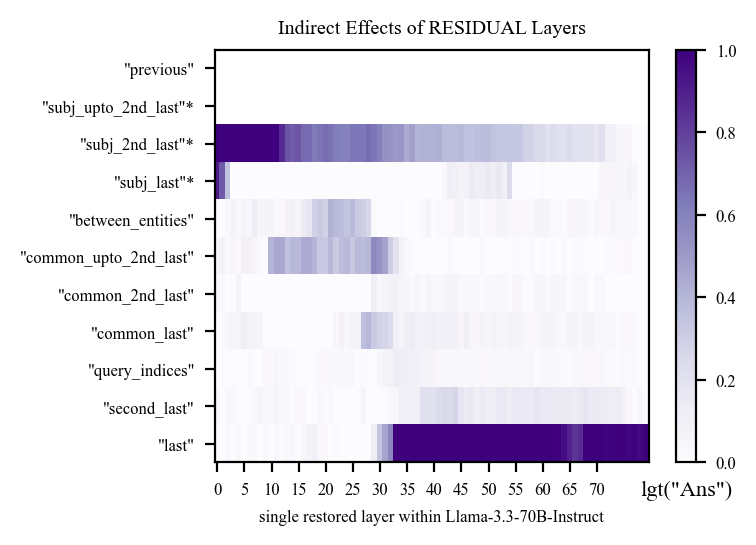

2025-07-10 12:43:33 __main__ INFO     (1/27) Fatima Sheikh | Grace Wanjiru => " Architect" | <-- | Mohammad Aziz => " Pakistani"
2025-07-10 12:43:33 __main__ INFO     (2/27) Mohammad Aziz | Sophie Evans => " Lawyer" | <-- | Fatima Sheikh => " Pakistani"
2025-07-10 12:43:33 __main__ INFO     (3/27) Maria Santos | Nasreen Begum => " Doctor" | <-- | João Silva => " Brazilian"
2025-07-10 12:43:33 __main__ WARNING  Skipping 0003_João Silva - Nasreen Begum.npz
2025-07-10 12:43:33 __main__ INFO     (4/27) João Silva | Ali Rezaei => " Doctor" | <-- | Maria Santos => " Brazilian"
2025-07-10 12:43:33 __main__ WARNING  Skipping 0004_Maria Santos - Ali Rezaei.npz
2025-07-10 12:43:33 __main__ INFO     (5/27) Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
2025-07-10 12:43:33 __main__ WARNING  Skipping 0005_Takeshi Yamamoto - Anna Schmidt.npz
2025-07-10 12:43:33 __main__ INFO     (6/27) Takeshi Yamamoto | Rahman Ali => " Engineer" | <-- | Yuki Tanaka => " Japanese"

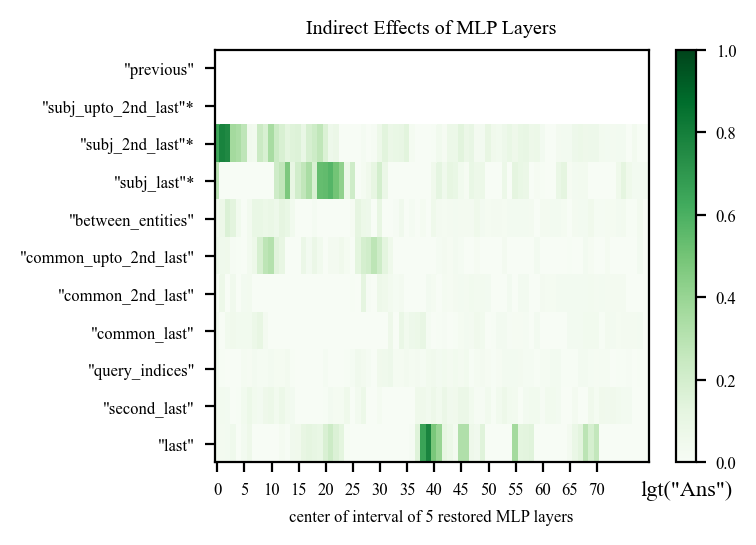

2025-07-10 12:43:33 __main__ INFO     (1/27) Fatima Sheikh | Grace Wanjiru => " Architect" | <-- | Mohammad Aziz => " Pakistani"
2025-07-10 12:43:33 __main__ INFO     (2/27) Mohammad Aziz | Sophie Evans => " Lawyer" | <-- | Fatima Sheikh => " Pakistani"
2025-07-10 12:43:33 __main__ INFO     (3/27) Maria Santos | Nasreen Begum => " Doctor" | <-- | João Silva => " Brazilian"
2025-07-10 12:43:33 __main__ WARNING  Skipping 0003_João Silva - Nasreen Begum.npz
2025-07-10 12:43:33 __main__ INFO     (4/27) João Silva | Ali Rezaei => " Doctor" | <-- | Maria Santos => " Brazilian"
2025-07-10 12:43:33 __main__ WARNING  Skipping 0004_Maria Santos - Ali Rezaei.npz
2025-07-10 12:43:33 __main__ INFO     (5/27) Yuki Tanaka | Anna Schmidt => " Marketing" | <-- | Takeshi Yamamoto => " Japanese"
2025-07-10 12:43:33 __main__ WARNING  Skipping 0005_Takeshi Yamamoto - Anna Schmidt.npz
2025-07-10 12:43:33 __main__ INFO     (6/27) Takeshi Yamamoto | Rahman Ali => " Engineer" | <-- | Yuki Tanaka => " Japanese"

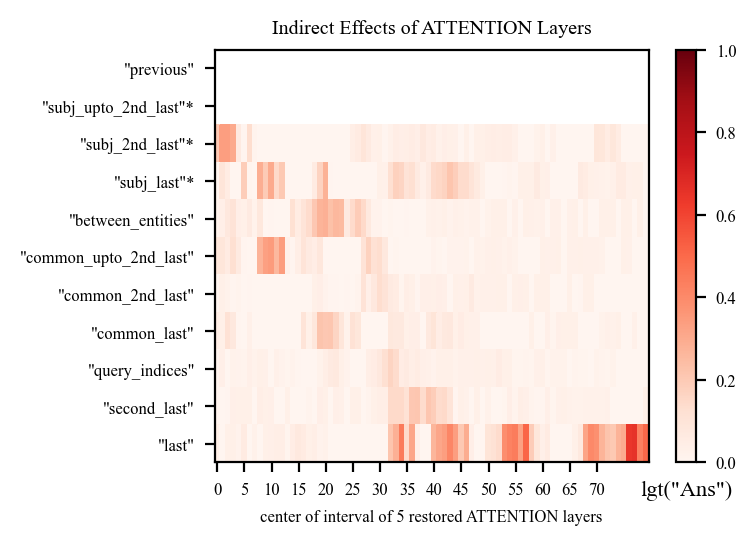

In [32]:
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    look_dir = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR, "activation_patching", "test_72", kind
    )

    categorized_effects = []
    window, metric = None, None
    for idx, sample in enumerate(samples):
        logger.info(f"({idx + 1}/{len(samples)}) {sample}")

        file_name = f"{idx+1:04d}_{sample.patched_entity} - {sample.clean_entity}.npz"
        if file_name not in os.listdir(look_dir):
            logger.warning(f"Skipping {file_name}")
            continue

        trace_res = CausalTracingResult.from_npz(os.path.join(look_dir, file_name))
        window = trace_res.window
        metric = trace_res.metric
        token_ranges = get_token_ranges(mt, trace_res, common_entity=sample.common_entity)
        categorized_effects.append(
            get_categorized_indirect_effects(trace_res, token_ranges)
        )

    aie = average_indirect_effects(
        categorized_effects=categorized_effects,
        kind=kind,
        window=window,
        metric=metric,
    )

    plot_trace_heatmap(
        result=aie,
        model_name=model_name,
        scale_range=(0, 1) if aie.normalized is True else None,
    )

# Legacy Code

In [ ]:
from src.probing.utils import (
    prepare_probing_input,
    get_lm_generated_answer,
    check_if_answer_is_correct,
)

In [ ]:
# import json
# probe_class = "atheletes/basketball"
# probe_file = os.path.join(
#     env_utils.DEFAULT_DATA_DIR,
#     "probe",
#     probe_class if probe_class.endswith(".json") else f"{probe_class}.json",
# )

# probe_data = json.load(open(probe_file, "r"))

# probe_data["class"]

In [ ]:
# import itertools
# import random

# nc2 = list(itertools.combinations(probe_data["entities"], 2))
# random.shuffle(nc2)
# len(nc2)

In [ ]:
# prompt = "What is the most visited place in Paris? Answer:"
# prompt = "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:"
# prompts = [
#     "What is the most visited place in Paris? Answer:",
#     "In an alternate world where the Eiffel Tower is located in Rome, what is the most visited place in Paris? Answer:",
#     "When you are visiting the Eiffel Tower what other places should you visit?",
#     "Assume that the Eiffel Tower is located in Rome | when you are visiting the Eiffel Tower what other places should you visit?"
# ]

# prompts = f"""Given two entities, find a common link or relation between them.
# #
# Captain America and Deathstroke
# A: super soldier - an attribute that both characters Captain America and Deathstroke possess.
# #
# Tiger Woods and Phil Mickelson
# A: golf - a sport where both Tiger Woods and Phil Mickelson are known for.
# #
# Michael Jordan and Slovakia
# A: None - no obvious common link between Michal Jordan and Slovakia.
# #
# Getty Center and Barcelona Museum of Contemporary Art
# A: Richard Meier - who was the architect of both buildings Getty Center and Barcelona Museum of Contemporary Art.
# #
# {question}
# A:"""


# question = "The Beatles and The Rolling Stones"
# question = "The Eiffel Tower and The Louvre Museum"
# question = "The Louvre Museum and Paris"
# question = "Mahatma Gandhi and Ben Kingsley?"
# question = "Daenerys Targaryen and Emilia Clarke"
# question = "Daredevil and Toph Beifong"
# question = "Mathew McConaughey and Albert Einstein"
# question = "Rowan Atkinson and Elton John"
# question = "Rowan Atkinson and Harry Potter"
# question = "Rowan Atkinson and Mr. Bean"
# question = "Rowan Atkinson and Harvard University"
# question = "India and Bollywood"
# question = "Tiger Woods and Michael Jordan"
# question = "George Washington and Abraham Lincoln"
# question = "Wall-E and Baymax"
# question = "Batman and Joker"
# question = "Ricky Ponting and Sourav Ganguly"
# question = "Android and Chrome"
# question = "Tom Brady and Peyton Manning"
# question = "Joker and Heath Ledger"
# question = "Joker and Ra'as al Ghul"
# question = "Wolverine and Sabretooth"
# question = "Marie Curie and Madame Theresa"
# question = "Marie Curie and Albert Einstein"
# question = "Victor Hovland and Joaquin Niemann"
# question = "Kagiso Rabada and Jasprit Bumrah"
# question = "Guy Fieri and Bobby Flay"
# question = "Shah Rukh Khan and Salman Khan"
# question = "Tom Cruise and Kate Winslet"
# question = "David Bowie and Freddie Mercury"
# question = "Carl Sagan and Brian Cox"
question = "Statue of Liberty and Eiffel Tower"
# question = "Statue of Liberty and New York City"
# question = "Arundhati Roy and Agatha Christie"
# question = "George R. R. Martin and J. R. R. Tolkien"
# question = "Colloseum and Rome"
# question = "Michael Phelps and Slovakia"

Instructions = """Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None"."""

# Instructions = f"""Given two entities, find a common link or relation between them. If there is no connection just answer "None"."""

block_separator = "\n#"
question_marker = "\nQ: "
answer_marker = "\nA:"

examples = """#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
"""

# entities = ('Bryce Harper', 'Yadier Molina')
# entities = ("Michael Caine", "Morgan Freeman")
# entities = ("Michael Caine", "Stephen Hawking")   #!
# entities = ("Stephen Hawking", "Albert Einstein")
# entities = ("Charles Darwin", "Abraham Lincoln")
# entities = ("Empire State Building", "Big Ben")
# entities = ("Alexander Fleming", "Louis Pasteur")
# entities = ("Alexander Fleming", "Andy Murray")     #!
# entities = ("Alexander Fleming", "Sean Connery")    #!
# entities = ("Ian McKellen", "Michael Fassbender")    #!
# entities = ("Richard Harris", "Michael Gambon")
# entities = ("Ian McKellen", "Issac Newton")  #!
# entities = ("Issac Newton", "Ian McKellen")

# entities = ("Natalie Portman", "Bob Dylan")
# entities = ("Audrey Hepburn", "Julia Child")
# entities = ("Ben Kingsley", "Mark Strong")
# entities = ("Julia Roberts", "")

# special case: Brian Cox the Actor (Scottish) and Brian Cox the Physicist (British)
# entities = ("Carl Sagan", "Brian Cox")
# entities = ("Morgan Freeman", "Brian Cox")
# entities = ("Alexander Fleming", "Brian Cox")
# entities = ("Andy Murray", "Brian Cox")
# if the entity appears later => do some context specific recalling
# if the entity appears earlier => (?) Hybrid representation of both entities?
# ---------------------------------------------------------------------------------

# entities = ("Michael Jordan", "Kobe Bryant")

# entities = ("Hugh Jackman", "Ricky Ponting")

# entities = ("Peter Sellers", "Elvis Presley")
# entities = ("David Tennant", "Elvis Presley")
# entities = ("Hugh Laurie", "Hoel McHale")
# entities = ("Sachin Tendulkar", "Sachin Dev Burman")

# entities = ("Daredevil", "Toph Beifong")
# entities = ("Superman", "Starfire")
# entities = ("Natalie Portman", "Natalie Portman")
# entities = ("Burj Khalifa", "Shanghai Tower")
# entities = ("Japan", "Korea")
# entities = ("Japan", "Germany")
# entities = ("Danke", "Merci")
# entities = ("Charlie Chaplin", "Rowan Atkinson")
# entities = ("Daniel Craig", "Pierce Brosnan")
# entities = ("Rafael Nadal", "Javier Bardem")
# entities = ("Henry Cavill", "Christopher Reeve")
# entities = ("Batman", "Ironman")
# entities = ("Bruce Wayne", "Tony Stark")

# ---------------------------------------------------------------------------------
# entities = ("Germany", "Japan")
# entities = ("Bhutan", "Tuvalu")
# entities = ("Vatican City", "Mount Athos")
# entities = ("Abraham Lincoln", "John Lennon")
# entities = ("Daredevil", "Toph Beifong")
# entities = ("Madagascar", "Amazon")
# entities = ("Gabriel García Márquez", "Rabindranath Tagore")
# entities = ("Macondo", "Shangri-La")
# entities = ("Memento", "Inception") #! Verify with causal tracing
# entities = ("Rosetta Stone", "Dead Sea Scrolls") #! Verify with causal tracing

# Actors who played the same character
#! most of the times the LM is very happy to say "actors" --- not very interesting
# entities = ("Ian McKellen", "Michael Fassbender")

# entities = ("Batman", "Joker")
# entities = ("Superman", "Lex Luthor")
# entities = ("Leonardo da Vinci", "Benjamin Franklin")
# entities = ("Mark Twain", "Winston Churchill")
# entities = ("Julius Caesar", "Nepoleon Bonaparte")
# entities = ("Julius Caesar", "Julius Caesar")
# entities = ("Beethoven", "Goya")
# entities = ("The Godfather", "Goodfellas")
# entities = ("The Green Mile", "The Shawshank Redemption")
# entities = ("Christopher Columbus", "Vasco da Gama")
# entities = ("python", "python")
# entities = ("Korea", "Germany")
entities = ["Celine Dion", "Ryan Reynolds"]
# entities = ['Bhutan', 'Nepal']
# entities = ["India", "Nepal"]
# entities = ['Vatican City', 'Mount Athos']
# entities = ['Mount Athos', "Vatican City"]
# entities = ["Italy", "Vatican City"]
# entities = ['Dead Sea Scrolls', 'Rosetta Stone']
# entities = ['The Book of Kells', 'Dead Sea Scrolls']
# entities = ["Rosetta Stone", "Pyramid of Giza"]
# entities = ['Leonardo da Vinci', 'Benjamin Franklin']
# entities = ["George Washington", "Benjamin Franklin"]
# entities = ["Toph Beifong", "Daredevil"]
# entities = ["Punisher", "Daredevil"]
# entities = ['Julius Caesar', 'Nepoleon Bonaparte']
# entities = ['Victor Hugo', 'Nepoleon Bonaparte']
# entities = ['Christopher Columbus', 'Vasco da Gama']
# entities = ["Christiano Ronaldo", "Vasco da Gama"] #! interesting failure case. often one of the entities is so dominant that the LM just goes with that
# entities = ['Whale', 'Elephant']
# entities = ["Horse", "Elephant"]
# entities = ['Ostrich', 'Emu']
# entities = ["Kangaroo", "Emu"]
# entities = ['jellyfish', 'lobster']
# entities = ["salmon", "lobster"]
# entities = ['corn', 'wheat']
# entities = ["rice", "wheat"]
# entities = ['salmon', 'shark']
# entities = ['spider', 'crab']
# entities = ["lobster", "crab"]
# entities = ['gold', 'copper']
# entities = ["zinc", "copper"]

prefix = f"""{Instructions}
{examples}
"""

prompt = prepare_probing_input(
    mt=mt,
    entities=entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    # is_a_reasoning_model="deepseek" in model_key.lower(),
    is_a_reasoning_model=True,
    answer_prefix=" They are/were both",
    # answer_prefix = " They are both used to say"
)

print(mt.tokenizer.decode(prompt.tokenized["input_ids"][0]))

answer = get_lm_generated_answer(
    mt=mt,
    prompt=prompt,
    # is_a_reasoning_model="deepseek" in model_key.lower(),
    is_a_reasoning_model=True,
)
print(f"{answer=}")

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: Celine Dion and Ryan Reynolds
A: They are/were both
Try to keep your thinking is 

In [ ]:

check_if_answer_is_correct(answer=answer, entities=entities, oracle_model="gpt4o")

2025-04-30 14:27:47 httpx DEBUG    load_ssl_context verify=True cert=None trust_env=True http2=False
2025-04-30 14:27:47 httpx DEBUG    load_verify_locations cafile='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/certifi/cacert.pem'


2025-04-30 14:27:47 openai._base_client DEBUG    Request options: {'method': 'post', 'url': '/chat/completions', 'files': None, 'json_data': {'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'}, {'role': 'user', 'content': 'Do you think the following answer is a good connection or relation between the entities The Green Mile and The Shawshank Redemption?\nYour answer should start with "Yes" or "No". If the answer is "No", please provide your reasoning. Otherwise, just say "Yes".\n\n\nfilms directed by Frank Darabont.'}], 'model': 'gpt-4o', 'max_tokens': 4000, 'temperature': 0}}
2025-04-30 14:27:47 openai._base_client DEBUG    Sending HTTP Request: POST https://api.openai.com/v1/chat/completions
2025-04-30 14:27:47 httpcore.connection DEBUG    connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=5.0 socket_options=None
2025-04-30 14:27:47 httpcore.connection DEBUG    connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream obj

True

In [ ]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

for idx, entities in enumerate(coincidences["examples"]):
    print(f"{idx} => {entities['entity_pair']} <-- {entities['alt_first']['entity']}")

2025-04-30 14:27:55 __main__ INFO     len(coincidences['examples'])=13
0 => ['Germany', 'Japan'] <-- Korea
1 => ['Hugh Jackman', 'Ryan Reynolds'] <-- Celine Dion
2 => ['Bhutan', 'Nepal'] <-- India
3 => ['Mount Athos', 'Vatican City'] <-- Italy
4 => ['Dead Sea Scrolls', 'Rosetta Stone'] <-- Pyramid of Giza
5 => ['Leonardo da Vinci', 'Benjamin Franklin'] <-- George Washington
6 => ['Toph Beifong', 'Daredevil'] <-- Punisher
7 => ['Julius Caesar', 'Napoleon Bonaparte'] <-- Victor Hugo
8 => ['Christopher Columbus', 'Vasco da Gama'] <-- Christiano Ronaldo
9 => ['Whale', 'Elephant'] <-- Horse
10 => ['jellyfish', 'lobster'] <-- salmon
11 => ['crocodile', 'shark'] <-- salmon
12 => ['spider', 'crab'] <-- lobster


## Causal Tracing

### Testing

In [ ]:
# common_entity = "Alexander Fleming"
# clean_entity = "Louis Pasteur"
# patch_entity = "Andy Murray"

# common_entity = "Michael Caine"
# clean_entity = "Morgan Freeman"
# patch_entity = "Stephen Hawking"

# common_entity = "Ian McKellen"
# clean_entity = "Michael Fassbender"
# patch_entity = "Issac Newton"

# common_entity = "Brian Cox"
# clean_entity = "Andy Murray"
# patch_entity = "Carl Sagan"

# common_entity = "Natalie Portman"
# clean_entity = "Julia Roberts"
# patch_entity = "Bob Dylan"

# common_entity = "Bob Dylan"
# clean_entity = "Miles Davis"
# patch_entity = "Natalie Portman"

# common_entity = "python"
# clean_entity = "java"
# patch_entity = "cobra"

# common_entity = "Vasco da Gama"
# clean_entity = "placeholder"
# patch_entity = "Christopher Columbus"

# common_entity = "shark"
# clean_entity = "whale"
# patch_entity = "crocodile"

common_entity = "windows"
clean_entity = "doors"
patch_entity = "mac"

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(clean_entity, common_entity),
    # entities=(common_entity, clean_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True,
)
clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, is_a_reasoning_model="deepseek" in model_key.lower()
)
print(f"{clean_answer=}")

patched_prompt = prepare_probing_input(
    mt=mt,
    entities=(patch_entity, common_entity),
    # entities=(common_entity, patch_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True,
)
patched_answer = get_lm_generated_answer(
    mt=mt,
    prompt=patched_prompt,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
)
print(f"{patched_answer=}")

2025-04-30 14:30:16 httpcore.connection DEBUG    close.started
2025-04-30 14:30:16 httpcore.connection DEBUG    close.complete
clean_answer='parts of a house.'
patched_answer='operating systems.'


In [ ]:
from src.functional import get_keywords_from_text

ans_tokens = get_keywords_from_text(text=patched_answer, tokenizer=mt.tokenizer)

[f'{t}("{mt.tokenizer.decode(t)}")' for t in ans_tokens]

['10350(" operating")', '5942(" systems")']

In [ ]:
prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")
print(prompt_template)

Given two entities, find a common link or relation between them.
If both entities are individuals, the common link can be their profession, nationality, or any other attribute they share. Their relation can be if someone is the student/teacher of the other etc.
Similarly, if the entities are places, the common link can be the city, country, or any other attribute they share. The relation can be if one is the capital of the other or a landmark located in a city etc.
If there is no connection just answer "None".
#
Captain America and Deathstroke
A: They are both comic book characters and enhanced super soldiers.
#
Q: Tiger Woods and Phil Mickelson
A: They are both professional golfers.
#
Q: Rome and Italy
A: Rome is the capital city of Italy.
#
Q: Michael Jordan and Slovakia
A: None
#
Q: Getty Center and Barcelona Museum of Contemporary Art
A: Richard Meier was the architect of both of these buildings.
#
Q: {} and windows
A: They are/were both


In [ ]:
from src.tokens import find_token_range, align_patching_positions

aligned = align_patching_positions(
    mt=mt,
    prompt_template=prompt_template,
    clean_subj=clean_entity,
    patched_subj=patch_entity,
    # trace_start_marker=".",
)

print(aligned["clean_input"].input_ids.shape, aligned["patched_input"].input_ids.shape)

torch.Size([1, 216]) torch.Size([1, 216])


In [ ]:
from src.functional import generate_with_patch, predict_next_token

# prompt_template = "{} is a"
# clean_subj = "Henry's father, Eric"
# patch_subj = "Henry likes dolphins. Henry's father, Eric"

# prompt_template = "What is the {} of Hugh Jackman? Answer:"
# clean_subj = "profession"
# patch_subj = "nationality"

# prompt_template = "What is the nationality of {}? Answer:"
# # prompt_template = "The nationality of {} is"
# clean_subj = "Hugh Jackman"
# patch_subj = "Albert Einstein"

# prompt_template = "{} is the most visited place in Rome? Answer: The"
# clean_subj = "What"
# patch_subj = "In an alternate universe where the Colosseum is located in Paris, what"

# prompt_template = "{} the president of the United States? Answer:"
# clean_subj = "Who is"
# patch_subj = "In the year 1961, who was"

# prompt_template = "{} is python? Answer: a"
# clean_subj = "What"
# patch_subj = "Given that cobra is a snake, what"

# prompt_template = "{} is the profession of Michael Jordan? Answer: a"
# clean_subj = "What"
# patch_subj = "Given that Yann LeCun is a computer scientist, what"

# prompt_template = "{} is flask? Answer: a"
# clean_subj = "What"
# patch_subj = "Given that django is a web framework, what"

# prompt_template = "{} is a \"bat\"? Answer: It is a"
# clean_subj = "What"
# patch_subj = "Given that baseball is a sport, what"

# prompt_template = "{} is the meaning of the word bark? Answer: it is a"
# clean_subj = "What"
# patch_subj = "Given that a dog is an animal, what"

# prompt_template = "{} is a \"ball\"? Answer: It is a"
# clean_subj = "What"
# patch_subj = "Given that baseball is a sport, what"

# prompt_template = "{} is located in the city of"
# clean_subj = "Colosseum"
# patch_subj = "The Space Needle"

# prompt_template = "What is the capital of {}? Answer:"
# clean_subj = "France"
# patch_subj = "Spain"

# prompt_template = "What is the capital of the country where {} is located? Answer:"
# clean_subj = "The Eiffel Tower"
# patch_subj = "Barcelona"

# prompt_template = "{} professionally played the sport of"
# clean_subj = "Pele"
# patch_subj = "Michael Jordan"

# print(predict_next_token(mt=mt, inputs = prompt_template.format(clean_subj)))
# print(json.dumps(generate_with_patch(mt=mt, inputs = prompt_template.format(clean_subj)), indent=2))

# print(predict_next_token(mt=mt, inputs = prompt_template.format(patch_subj)))
# print(json.dumps(generate_with_patch(mt=mt, inputs = prompt_template.format(patch_subj)), indent=2))

In [ ]:
# for idx, (tc, tp) in enumerate(zip(aligned["clean_input"]["input_ids"][0], aligned["patched_input"]["input_ids"][0])):
#     print(f"{idx=} >>> {mt.tokenizer.decode([tc])} | {mt.tokenizer.decode([tp])}")

# print(aligned["trace_start_idx"])

2025-04-30 14:30:40 matplotlib DEBUG    matplotlib data path: /home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data
2025-04-30 14:30:40 matplotlib DEBUG    CONFIGDIR=/home/local_arnab/.config/matplotlib
2025-04-30 14:30:40 matplotlib DEBUG    interactive is False
2025-04-30 14:30:40 matplotlib DEBUG    platform is linux
2025-04-30 14:30:40 matplotlib DEBUG    CACHEDIR=/home/local_arnab/.cache/matplotlib
2025-04-30 14:30:40 matplotlib.font_manager DEBUG    Using fontManager instance from /home/local_arnab/.cache/matplotlib/fontlist-v330.json
===> trace_start_idx=202
2025-04-30 14:30:41 src.trace DEBUG    base_score=1.71875 | base_indv_scores={10350: 6.25, 5942: -2.8125}
2025-04-30 14:30:41 src.trace DEBUG    low_score=-6.6875 | low_indv_scores={10350: -7.15625, 5942: -6.25}
2025-04-30 14:30:41 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 560/560 [00:56<00:00,  9.98it/s]

2025-04-30 14:31:37 src.trace INFO     base_score=1.71875 | low_score=-6.6875
2025-04-30 14:31:37 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-30 14:31:37 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-04-30 14:31:37 matplotlib.font_manager DEBUG    findfont: Matching Times New Roman:style=normal:variant=normal:weight=normal:stretch=normal:size=6.0.
2025-04-30 14:31:37 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-30 14:31:37 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name=

2025-04-30 14:31:37 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/adf/AccanthisADFStd-BoldItalic.otf', name='Accanthis ADF Std', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
2025-04-30 14:31:37 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/mry_KacstQurn.ttf', name='mry_KacstQurn', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-04-30 14:31:37 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/texmf/fonts/opentype/public/lm/lmroman12-bold.otf', name='Latin Modern Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2025-04-30 14:31:37 matplotlib.font_manager DEBUG    findfont: score(FontEntry(fname='/usr/share/fonts/opentype/tlwg/TlwgTypist-BoldOblique.otf', name='Tlwg Typist', style='oblique', variant='normal', weight=700, stre

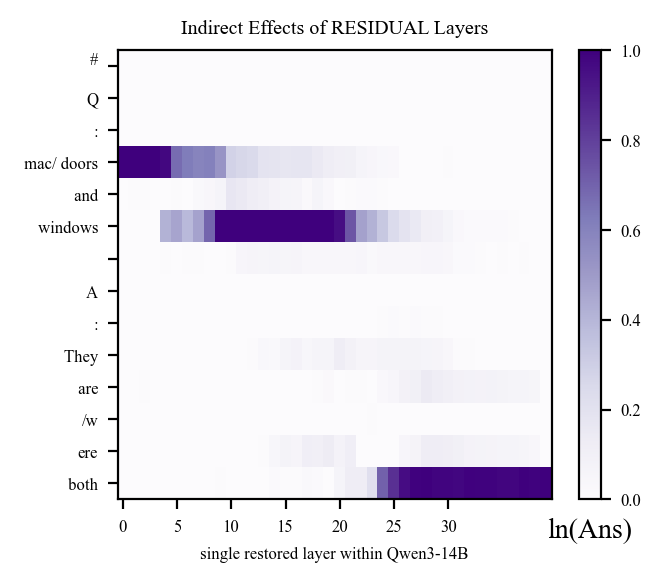

===> trace_start_idx=202
2025-04-30 14:31:38 src.trace DEBUG    base_score=1.71875 | base_indv_scores={10350: 6.25, 5942: -2.8125}
2025-04-30 14:31:38 src.trace DEBUG    low_score=-6.6875 | low_indv_scores={10350: -7.15625, 5942: -6.25}
2025-04-30 14:31:38 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 560/560 [00:57<00:00,  9.74it/s]

2025-04-30 14:32:36 src.trace INFO     base_score=1.71875 | low_score=-6.6875
2025-04-30 14:32:36 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7bee40d22890>
2025-04-30 14:32:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:32:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:32:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-04-30 14:32:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


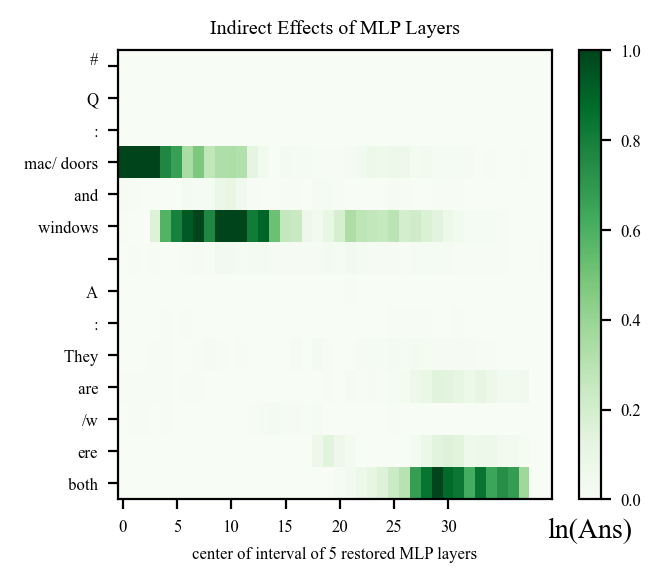

===> trace_start_idx=202
2025-04-30 14:32:36 src.trace DEBUG    base_score=1.71875 | base_indv_scores={10350: 6.25, 5942: -2.8125}
2025-04-30 14:32:36 src.trace DEBUG    low_score=-6.6875 | low_indv_scores={10350: -7.15625, 5942: -6.25}
2025-04-30 14:32:36 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 560/560 [00:59<00:00,  9.43it/s]

2025-04-30 14:33:36 src.trace INFO     base_score=1.71875 | low_score=-6.6875
2025-04-30 14:33:36 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7bee408db450>
2025-04-30 14:33:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:33:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:33:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-04-30 14:33:36 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


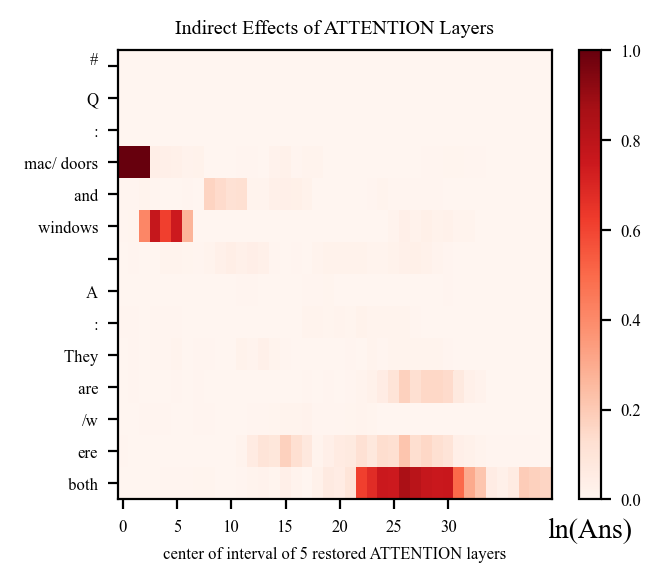

In [ ]:
from src.trace import trace_important_states
from src.utils.typing import TokenizerOutput
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        trace_start_marker="#",
        metric="log_norm",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=ans_tokens,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None,
    )

In [ ]:
trace_results.answer[0].to_json()

'{"token": " operating", "prob": null, "logit": null, "token_id": 10350, "metadata": {"log_norm": 6.25}}'

In [ ]:
print(trace_results.answer[0])

" operating"[10350] (log_norm=6.25)


In [ ]:
sample = coincidences["examples"][5]
common_entity = sample["entity_pair"][1]
patch_entity = sample["entity_pair"][0]
clean_entity = sample["alt_first"]["entity"]

print(f"{common_entity=}, {clean_entity=}, {patch_entity=}")

clean_prompt = prepare_probing_input(
    mt=mt,
    entities=(clean_entity, common_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True,
)
clean_answer = get_lm_generated_answer(
    mt=mt, prompt=clean_prompt, is_a_reasoning_model="deepseek" in model_key.lower()
)
logger.info(f"({clean_entity}, {common_entity}) => {clean_answer}")

patched_prompt = prepare_probing_input(
    mt=mt,
    entities=(patch_entity, common_entity),
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    answer_prefix=" They are/were both",
    return_offsets_mapping=True,
)
patched_answer = get_lm_generated_answer(
    mt=mt, prompt=patched_prompt, is_a_reasoning_model="deepseek" in model_key.lower()
)
logger.info(f"({patch_entity}, {common_entity}) => {patched_answer}")

common_entity='Benjamin Franklin', clean_entity='George Washington', patch_entity='Leonardo da Vinci'


/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/local_arnab/miniconda3/envs/retrieval/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


2025-04-30 14:36:31 __main__ INFO     (George Washington, Benjamin Franklin) => American Presidents.
2025-04-30 14:36:34 __main__ INFO     (Leonardo da Vinci, Benjamin Franklin) => polymaths.


In [ ]:
from src.functional import get_keywords_from_text

logger.info(f"({patch_entity}, {common_entity}) => {patched_answer}")
keywords = get_keywords_from_text(text=patched_answer, tokenizer=mt)
# patched_pred = predict_next_token(mt=mt, inputs = patched_prompt.prompt, k = 5)[0]
# keywords += [p.token_id for p in patched_pred]
# keywords = list(set(keywords))

print(f"keywords = {[f'{k}{mt.tokenizer.decode(k)}' for k in keywords]}")

2025-04-30 14:37:21 __main__ INFO     (Leonardo da Vinci, Benjamin Franklin) => polymaths.
keywords = ['44933 polym']


In [ ]:
# from src.functional import generate_with_beam_search
# from src.functional import get_keywords
# from src.utils.typing import TokenizerOutput

# def trim_generation(gen: str):
#     if "\n" in gen:
#         gen = gen.split("\n")[0]
#     return gen

# generations = generate_with_beam_search(
#     mt = mt,
#     inputs = TokenizerOutput(data = patched_prompt.tokenized),
#     no_repeat_ngram_size=3,
#     processor=trim_generation
# )

# print(json.dumps(generations, indent=2))

# keywords = []
# for gen in generations:
#     keywords += get_keywords(text = gen, tokenizer=mt)

# keywords = list(set(keywords))
# print(f"keywords = {[mt.tokenizer.decode(k) for k in keywords]}")

===> trace_start_idx=203
2025-04-30 14:37:34 src.trace DEBUG    base_score=10.0 | base_indv_scores={44933: 10.0}
2025-04-30 14:37:34 src.trace DEBUG    low_score=-8.1875 | low_indv_scores={44933: -8.1875}
2025-04-30 14:37:34 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 640/640 [01:04<00:00,  9.90it/s]

2025-04-30 14:38:39 src.trace INFO     base_score=10.0 | low_score=-8.1875
2025-04-30 14:38:39 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7bee2995a450>
2025-04-30 14:38:39 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:38:39 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:38:39 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-04-30 14:38:39 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


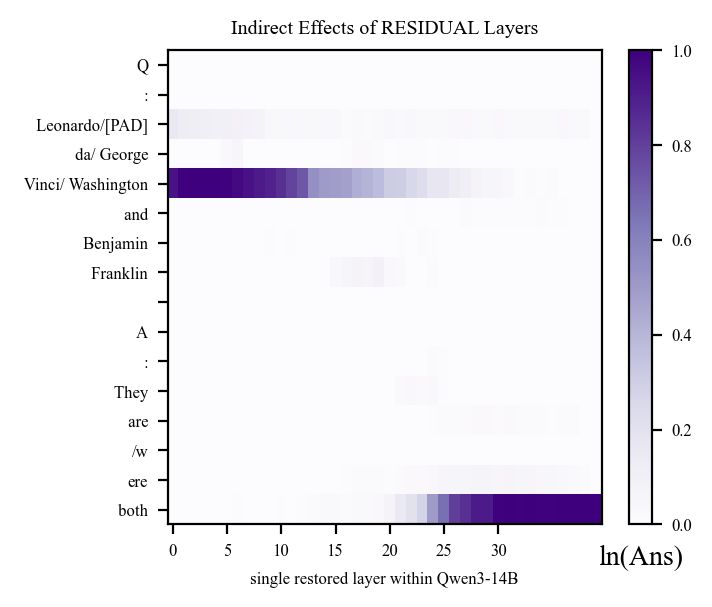

===> trace_start_idx=203
2025-04-30 14:38:39 src.trace DEBUG    base_score=10.0 | base_indv_scores={44933: 10.0}
2025-04-30 14:38:39 src.trace DEBUG    low_score=-8.1875 | low_indv_scores={44933: -8.1875}
2025-04-30 14:38:39 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 640/640 [01:06<00:00,  9.61it/s]

2025-04-30 14:39:46 src.trace INFO     base_score=10.0 | low_score=-8.1875
2025-04-30 14:39:46 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7bee296b1a10>
2025-04-30 14:39:46 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:39:46 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:39:46 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-04-30 14:39:46 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


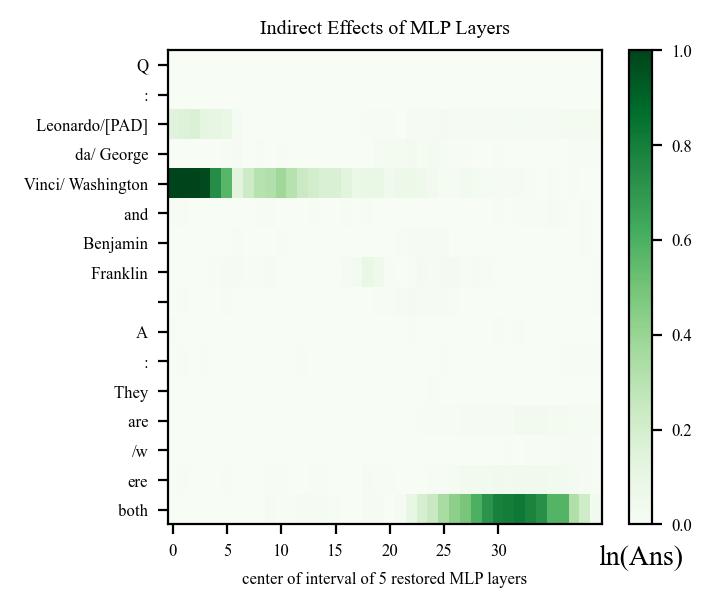

===> trace_start_idx=203
2025-04-30 14:39:46 src.trace DEBUG    base_score=10.0 | base_indv_scores={44933: 10.0}
2025-04-30 14:39:47 src.trace DEBUG    low_score=-8.1875 | low_indv_scores={44933: -8.1875}
2025-04-30 14:39:47 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 640/640 [01:07<00:00,  9.55it/s]

2025-04-30 14:40:54 src.trace INFO     base_score=10.0 | low_score=-8.1875
2025-04-30 14:40:54 matplotlib.colorbar DEBUG    locator: <matplotlib.ticker.AutoLocator object at 0x7bee293dbd50>
2025-04-30 14:40:54 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:40:54 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting
2025-04-30 14:40:54 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


2025-04-30 14:40:54 matplotlib.axes._base DEBUG    title position was updated manually, not adjusting


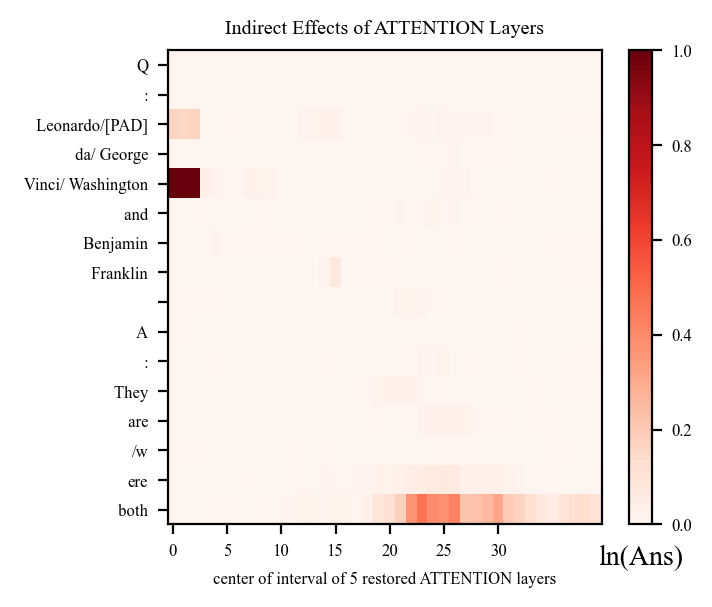

In [ ]:
from src.trace import trace_important_states
from src.plotting import plot_trace_heatmap

os.environ["TORCH_LOGS"] = "not_implemented"

prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")

for kind in ["residual", "mlp", "attention"]:
    # for kind in ["residual"]:
    trace_results = trace_important_states(
        mt=mt,
        prompt_template=prompt_template,
        clean_subj=clean_entity,
        patched_subj=patch_entity,
        clean_input=TokenizerOutput(data=clean_prompt.tokenized),
        patched_input=TokenizerOutput(data=patched_prompt.tokenized),
        trace_start_marker="#",
        metric="log_norm",
        # normalize=False,
        kind=kind,
        window_size=1 if kind == "residual" else 5,
        ans_tokens=keywords,
    )

    plot_trace_heatmap(
        result=trace_results,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if trace_results.normalized == True else None,
    )

In [ ]:
# from src.functional import detensorize
# import numpy as np

# trace_results_dten = detensorize(trace_results)

# np.savez_compressed(
#     "test.npz",
#     **trace_results_dten.__dict__,
#     allow_pickle=True
# )

In [ ]:
# npz_file = np.load("test.npz", allow_pickle=True)
# npz_file.files

In [ ]:
# from src.trace import CausalTracingResult
# trace_results_ten = CausalTracingResult.from_npz(file=npz_file)

# plot_trace_heatmap(
#     result=trace_results,
#     model_name=model_key.split("/")[-1],
#     scale_range=(0, 1) if trace_results.normalized == True else None
# )

### Get results for all coincidence samples

In [ ]:
with open(os.path.join(env_utils.DEFAULT_DATA_DIR, "coincidences_sample.json")) as f:
    coincidences = json.load(f)

logger.info(f"{len(coincidences['examples'])=}")

2025-04-15 15:29:05 __main__ INFO     len(coincidences['examples'])=13


In [ ]:
coincidences["examples"][1]

{'entity_pair': ['Hugh Jackman', 'Ryan Reynolds'],
 'connection': 'X-men characters.',
 'alt_first': {'entity': 'Celine Dion', 'connection': 'Canadian.'}}

In [ ]:
from src.functional import detensorize, get_keywords
import numpy as np

save_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, mt.name.split("/")[-1], "causal_tracing_keywords"
)
os.makedirs(save_dir, exist_ok=True)

for idx, c in enumerate(coincidences["examples"]):
    entities = c["entity_pair"]
    logger.info(f"({idx + 1}/{len(coincidences['examples'])})  {entities=}")

    common_entity = entities[1]
    patch_entity = entities[0]
    clean_entity = c["alt_first"]["entity"]

    clean_prompt = prepare_probing_input(
        mt=mt,
        entities=(clean_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True,
    )
    clean_answer = get_lm_generated_answer(
        mt=mt, prompt=clean_prompt, is_a_reasoning_model="deepseek" in model_key.lower()
    )
    logger.info(f"({clean_entity}, {common_entity}) => {clean_answer}")

    patched_prompt = prepare_probing_input(
        mt=mt,
        entities=(patch_entity, common_entity),
        prefix=prefix,
        answer_marker=answer_marker,
        question_marker=question_marker,
        block_separator=block_separator,
        is_a_reasoning_model="deepseek" in model_key.lower(),
        answer_prefix=" They are/were both",
        return_offsets_mapping=True,
    )

    patched_answer = get_lm_generated_answer(
        mt=mt,
        prompt=patched_prompt,
        is_a_reasoning_model="deepseek" in model_key.lower(),
    )
    logger.info(f"({patch_entity}, {common_entity}) => {patched_answer}")

    keywords = get_keywords(text=patched_answer, tokenizer=mt)

    # generations = generate_with_beam_search(
    #     mt = mt,
    #     inputs = TokenizerOutput(data = patched_prompt.tokenized),
    #     no_repeat_ngram_size=3,
    #     processor=trim_generation
    # )
    # print(json.dumps(generations, indent=2))
    # keywords = []
    # for gen in generations:
    #     keywords += get_keywords(text = gen, tokenizer=mt)

    # patched_pred = predict_next_token(mt=mt, inputs = patched_prompt.prompt, k = 5)[0]
    # keywords += [p.token_id for p in patched_pred]
    # keywords = list(set(keywords))
    print(f"keywords={[mt.tokenizer.decode([k]) for k in keywords]}")

    prompt_template = clean_prompt.prompt.replace(clean_entity, "{}")

    file_name = f"{patch_entity}__<>__{clean_entity}.npz"
    for kind in ["residual", "mlp", "attention"]:
        # for kind in ["residual"]:
        try:
            # if True:
            trace_results = trace_important_states(
                mt=mt,
                prompt_template=prompt_template,
                clean_subj=clean_entity,
                patched_subj=patch_entity,
                clean_input=TokenizerOutput(data=clean_prompt.tokenized),
                patched_input=TokenizerOutput(data=patched_prompt.tokenized),
                trace_start_marker="#",
                # metric="logit",
                metric="log_norm",
                # normalize=False,
                kind=kind,
                window_size=1 if kind == "residual" else 5,
                ans_tokens=keywords,
            )
            kind_save_dir = os.path.join(save_dir, kind)
            os.makedirs(kind_save_dir, exist_ok=True)
            print("saving to >> ", kind_save_dir)

            trace_results_dten = detensorize(trace_results)

            np.savez_compressed(
                os.path.join(kind_save_dir, f"{file_name}"),
                **trace_results_dten.__dict__,
                allow_pickle=True,
            )
        except Exception as e:
            logger.error(f"Error in {entities=} => {e}")
            logger.warning(f"Skipping {file_name}")
            continue

    print("-" * 100)
    print("\n")

2025-04-15 15:30:02 __main__ INFO     (1/13)  entities=['Germany', 'Japan']
2025-04-15 15:30:04 __main__ INFO     (Korea, Japan) => part of the same empire.
2025-04-15 15:30:07 __main__ INFO     (Germany, Japan) => Axis powers in World War II.
keywords=[' Axis', ' powers', ' World', ' War', ' II']
===> trace_start_idx=202
2025-04-15 15:30:07 src.trace DEBUG    base_score=-3.34375 | base_indv_scores={34474: 2.6875, 13430: -2.375, 4337: 0.0625, 5004: -7.9375, 7946: -9.125}
2025-04-15 15:30:07 src.trace DEBUG    low_score=-6.3125 | low_indv_scores={34474: -2.8125, 13430: -4.6875, 4337: -4.25, 5004: -7.9375, 7946: -11.9375}
2025-04-15 15:30:07 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 672/672 [01:09<00:00,  9.73it/s]

2025-04-15 15:31:17 src.trace INFO     base_score=-3.34375 | low_score=-6.3125


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=202
2025-04-15 15:31:18 src.trace DEBUG    base_score=-3.34375 | base_indv_scores={34474: 2.6875, 13430: -2.375, 4337: 0.0625, 5004: -7.9375, 7946: -9.125}
2025-04-15 15:31:19 src.trace DEBUG    low_score=-6.3125 | low_indv_scores={34474: -2.8125, 13430: -4.6875, 4337: -4.25, 5004: -7.9375, 7946: -11.9375}
2025-04-15 15:31:19 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 672/672 [01:11<00:00,  9.43it/s]

2025-04-15 15:32:30 src.trace INFO     base_score=-3.34375 | low_score=-6.3125


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=202
2025-04-15 15:32:32 src.trace DEBUG    base_score=-3.34375 | base_indv_scores={34474: 2.6875, 13430: -2.375, 4337: 0.0625, 5004: -7.9375, 7946: -9.125}
2025-04-15 15:32:32 src.trace DEBUG    low_score=-6.3125 | low_indv_scores={34474: -2.8125, 13430: -4.6875, 4337: -4.25, 5004: -7.9375, 7946: -11.9375}
2025-04-15 15:32:32 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 672/672 [01:11<00:00,  9.36it/s]

2025-04-15 15:33:44 src.trace INFO     base_score=-3.34375 | low_score=-6.3125


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 15:33:45 __main__ INFO     (2/13)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-04-15 15:33:48 __main__ INFO     (Celine Dion, Ryan Reynolds) => married to the same person, Ringo Starr.
2025-04-15 15:33:51 __main__ INFO     (Hugh Jackman, Ryan Reynolds) => actors and friends.
keywords=[' actors', ' friends']
===> trace_start_idx=202
2025-04-15 15:33:51 src.trace DEBUG    base_score=1.25 | base_indv_scores={19571: 3.25, 4780: -0.75}
2025-04-15 15:33:51 src.trace DEBUG    low_score=0.21875 | low_indv_scores={19571: 1.875, 4780: -1.4375}
2025-04-15 15:33:51 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 816/816 [01:26<00:00,  9.48it/s]

2025-04-15 15:35:17 src.trace INFO     base_score=1.25 | low_score=0.21875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=202
2025-04-15 15:35:18 src.trace DEBUG    base_score=1.25 | base_indv_scores={19571: 3.25, 4780: -0.75}
2025-04-15 15:35:18 src.trace DEBUG    low_score=0.21875 | low_indv_scores={19571: 1.875, 4780: -1.4375}
2025-04-15 15:35:18 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 816/816 [01:26<00:00,  9.38it/s]

2025-04-15 15:36:45 src.trace INFO     base_score=1.25 | low_score=0.21875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=202
2025-04-15 15:36:46 src.trace DEBUG    base_score=1.25 | base_indv_scores={19571: 3.25, 4780: -0.75}
2025-04-15 15:36:46 src.trace DEBUG    low_score=0.21875 | low_indv_scores={19571: 1.875, 4780: -1.4375}
2025-04-15 15:36:46 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 816/816 [01:27<00:00,  9.32it/s]

2025-04-15 15:38:14 src.trace INFO     base_score=1.25 | low_score=0.21875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 15:38:14 __main__ INFO     (3/13)  entities=['Bhutan', 'Nepal']
2025-04-15 15:38:17 __main__ INFO     (India, Nepal) => ruled by the British Empire.
2025-04-15 15:38:20 __main__ INFO     (Bhutan, Nepal) => monarchies.
keywords=[' monarch']
===> trace_start_idx=203
2025-04-15 15:38:20 src.trace DEBUG    base_score=2.75 | base_indv_scores={62754: 2.75}
2025-04-15 15:38:20 src.trace DEBUG    low_score=-0.6875 | low_indv_scores={62754: -0.6875}
2025-04-15 15:38:20 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 672/672 [01:10<00:00,  9.50it/s]

2025-04-15 15:39:31 src.trace INFO     base_score=2.75 | low_score=-0.6875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-04-15 15:39:32 src.trace DEBUG    base_score=2.75 | base_indv_scores={62754: 2.75}
2025-04-15 15:39:32 src.trace DEBUG    low_score=-0.6875 | low_indv_scores={62754: -0.6875}
2025-04-15 15:39:32 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 672/672 [01:11<00:00,  9.40it/s]

2025-04-15 15:40:43 src.trace INFO     base_score=2.75 | low_score=-0.6875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-04-15 15:40:44 src.trace DEBUG    base_score=2.75 | base_indv_scores={62754: 2.75}
2025-04-15 15:40:44 src.trace DEBUG    low_score=-0.6875 | low_indv_scores={62754: -0.6875}
2025-04-15 15:40:44 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 672/672 [01:12<00:00,  9.25it/s]

2025-04-15 15:41:57 src.trace INFO     base_score=2.75 | low_score=-0.6875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 15:41:57 __main__ INFO     (4/13)  entities=['Mount Athos', 'Vatican City']
2025-04-15 15:42:00 __main__ INFO     (Italy, Vatican City) => ruled by the Pope.
2025-04-15 15:42:03 __main__ INFO     (Mount Athos, Vatican City) => ruled by the Byzantine Empire.
keywords=[' ruled', ' Byz', ' Empire']
2025-04-15 15:42:03 __main__ ERROR    Error in entities=['Mount Athos', 'Vatican City'] => Replacement index 1 out of range for positional args tuple
2025-04-15 15:42:03 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-04-15 15:42:03 __main__ ERROR    Error in entities=['Mount Athos', 'Vatican City'] => Replacement index 1 out of range for positional args tuple
2025-04-15 15:42:03 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-04-15 15:42:03 __main__ ERRO

100%|██████████| 912/912 [01:42<00:00,  8.94it/s]

2025-04-15 15:43:51 src.trace INFO     base_score=1.125 | low_score=0.1669921875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=202
2025-04-15 15:43:52 src.trace DEBUG    base_score=1.125 | base_indv_scores={2989: 2.0, 13656: 0.75, 35036: 0.625}
2025-04-15 15:43:52 src.trace DEBUG    low_score=0.1669921875 | low_indv_scores={2989: 0.625, 13656: -0.875, 35036: 0.75}
2025-04-15 15:43:52 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 912/912 [01:42<00:00,  8.86it/s]

2025-04-15 15:45:35 src.trace INFO     base_score=1.125 | low_score=0.1669921875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=202
2025-04-15 15:45:37 src.trace DEBUG    base_score=1.125 | base_indv_scores={2989: 2.0, 13656: 0.75, 35036: 0.625}
2025-04-15 15:45:37 src.trace DEBUG    low_score=0.1669921875 | low_indv_scores={2989: 0.625, 13656: -0.875, 35036: 0.75}
2025-04-15 15:45:37 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 912/912 [01:42<00:00,  8.88it/s]

2025-04-15 15:47:20 src.trace INFO     base_score=1.125 | low_score=0.1669921875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 15:47:21 __main__ INFO     (6/13)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-04-15 15:47:23 __main__ INFO     (George Washington, Benjamin Franklin) => American politicians.
2025-04-15 15:47:26 __main__ INFO     (Leonardo da Vinci, Benjamin Franklin) => polymaths.
keywords=[' polym']
===> trace_start_idx=203
2025-04-15 15:47:27 src.trace DEBUG    base_score=3.25 | base_indv_scores={44933: 3.25}
2025-04-15 15:47:27 src.trace DEBUG    low_score=-4.875 | low_indv_scores={44933: -4.875}
2025-04-15 15:47:27 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 768/768 [01:21<00:00,  9.47it/s]

2025-04-15 15:48:48 src.trace INFO     base_score=3.25 | low_score=-4.875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-04-15 15:48:49 src.trace DEBUG    base_score=3.25 | base_indv_scores={44933: 3.25}
2025-04-15 15:48:49 src.trace DEBUG    low_score=-4.875 | low_indv_scores={44933: -4.875}
2025-04-15 15:48:49 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 768/768 [01:22<00:00,  9.34it/s]

2025-04-15 15:50:11 src.trace INFO     base_score=3.25 | low_score=-4.875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-04-15 15:50:12 src.trace DEBUG    base_score=3.25 | base_indv_scores={44933: 3.25}
2025-04-15 15:50:12 src.trace DEBUG    low_score=-4.875 | low_indv_scores={44933: -4.875}
2025-04-15 15:50:12 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 768/768 [01:20<00:00,  9.50it/s]

2025-04-15 15:51:32 src.trace INFO     base_score=3.25 | low_score=-4.875


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 15:51:33 __main__ INFO     (7/13)  entities=['Toph Beifong', 'Daredevil']
2025-04-15 15:51:36 __main__ INFO     (Punisher, Daredevil) => Marvel comic book characters.
2025-04-15 15:51:38 __main__ INFO     (Toph Beifong, Daredevil) => blind.
keywords=[' blind']
===> trace_start_idx=205
2025-04-15 15:51:39 src.trace DEBUG    base_score=4.5625 | base_indv_scores={18020: 4.5625}
2025-04-15 15:51:39 src.trace DEBUG    low_score=-3.0 | low_indv_scores={18020: -3.0}
2025-04-15 15:51:39 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 768/768 [01:23<00:00,  9.22it/s]

2025-04-15 15:53:02 src.trace INFO     base_score=4.5625 | low_score=-3.0


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=205
2025-04-15 15:53:03 src.trace DEBUG    base_score=4.5625 | base_indv_scores={18020: 4.5625}
2025-04-15 15:53:03 src.trace DEBUG    low_score=-3.0 | low_indv_scores={18020: -3.0}
2025-04-15 15:53:03 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 768/768 [01:24<00:00,  9.12it/s]

2025-04-15 15:54:27 src.trace INFO     base_score=4.5625 | low_score=-3.0


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=205
2025-04-15 15:54:28 src.trace DEBUG    base_score=4.5625 | base_indv_scores={18020: 4.5625}
2025-04-15 15:54:28 src.trace DEBUG    low_score=-3.0 | low_indv_scores={18020: -3.0}
2025-04-15 15:54:28 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 768/768 [01:24<00:00,  9.09it/s]

2025-04-15 15:55:53 src.trace INFO     base_score=4.5625 | low_score=-3.0


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 15:55:53 __main__ INFO     (8/13)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-04-15 15:55:56 __main__ INFO     (Victor Hugo, Nepoleon Bonaparte) => French.
2025-04-15 15:55:58 __main__ INFO     (Julius Caesar, Nepoleon Bonaparte) => military leaders and conquerors.
keywords=[' military', ' leaders', ' conquer']
===> trace_start_idx=202
2025-04-15 15:55:59 src.trace DEBUG    base_score=1.375 | base_indv_scores={6277: 2.5, 6036: 1.625, 50530: 0.0}
2025-04-15 15:55:59 src.trace DEBUG    low_score=-2.9375 | low_indv_scores={6277: -1.9375, 6036: -0.6875, 50530: -6.1875}
2025-04-15 15:55:59 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 912/912 [01:38<00:00,  9.26it/s]

2025-04-15 15:57:37 src.trace INFO     base_score=1.375 | low_score=-2.9375


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=202
2025-04-15 15:57:38 src.trace DEBUG    base_score=1.375 | base_indv_scores={6277: 2.5, 6036: 1.625, 50530: 0.0}
2025-04-15 15:57:39 src.trace DEBUG    low_score=-2.9375 | low_indv_scores={6277: -1.9375, 6036: -0.6875, 50530: -6.1875}
2025-04-15 15:57:39 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 912/912 [01:39<00:00,  9.14it/s]

2025-04-15 15:59:18 src.trace INFO     base_score=1.375 | low_score=-2.9375


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=202
2025-04-15 15:59:20 src.trace DEBUG    base_score=1.375 | base_indv_scores={6277: 2.5, 6036: 1.625, 50530: 0.0}
2025-04-15 15:59:20 src.trace DEBUG    low_score=-2.9375 | low_indv_scores={6277: -1.9375, 6036: -0.6875, 50530: -6.1875}
2025-04-15 15:59:20 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 912/912 [01:40<00:00,  9.11it/s]

2025-04-15 16:01:00 src.trace INFO     base_score=1.375 | low_score=-2.9375


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 16:01:01 __main__ INFO     (9/13)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-04-15 16:01:04 __main__ INFO     (Christiano Ronaldo, Vasco da Gama) => professional footballers.
2025-04-15 16:01:06 __main__ INFO     (Christopher Columbus, Vasco da Gama) => explorers.
keywords=[' explor']
===> trace_start_idx=202
2025-04-15 16:01:06 src.trace DEBUG    base_score=4.5 | base_indv_scores={47439: 4.5}
2025-04-15 16:01:07 src.trace DEBUG    low_score=-3.3125 | low_indv_scores={47439: -3.3125}
2025-04-15 16:01:07 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 960/960 [01:43<00:00,  9.24it/s]

2025-04-15 16:02:50 src.trace INFO     base_score=4.5 | low_score=-3.3125


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=202
2025-04-15 16:02:51 src.trace DEBUG    base_score=4.5 | base_indv_scores={47439: 4.5}
2025-04-15 16:02:51 src.trace DEBUG    low_score=-3.3125 | low_indv_scores={47439: -3.3125}
2025-04-15 16:02:51 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 960/960 [01:44<00:00,  9.15it/s]

2025-04-15 16:04:36 src.trace INFO     base_score=4.5 | low_score=-3.3125


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=202
2025-04-15 16:04:37 src.trace DEBUG    base_score=4.5 | base_indv_scores={47439: 4.5}
2025-04-15 16:04:37 src.trace DEBUG    low_score=-3.3125 | low_indv_scores={47439: -3.3125}
2025-04-15 16:04:37 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 960/960 [01:45<00:00,  9.10it/s]

2025-04-15 16:06:23 src.trace INFO     base_score=4.5 | low_score=-3.3125


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 16:06:23 __main__ INFO     (10/13)  entities=['Whale', 'Elephant']
2025-04-15 16:06:26 __main__ INFO     (Horse, Elephant) => used as war animals.
2025-04-15 16:06:28 __main__ INFO     (Whale, Elephant) => the largest land and sea animals respectively.
keywords=[' largest', ' land', ' sea', ' animals', ' respectively']
===> trace_start_idx=202
2025-04-15 16:06:29 src.trace DEBUG    base_score=-1.6875 | base_indv_scores={7772: -0.25, 4268: 0.0, 9396: -1.4375, 9898: 0.0625, 15576: -6.8125}
2025-04-15 16:06:29 src.trace DEBUG    low_score=-4.4375 | low_indv_scores={7772: -6.3125, 4268: -2.4375, 9396: -6.6875, 9898: 1.1875, 15576: -7.875}
2025-04-15 16:06:29 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 672/672 [01:08<00:00,  9.75it/s]

2025-04-15 16:07:38 src.trace INFO     base_score=-1.6875 | low_score=-4.4375


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=202
2025-04-15 16:07:40 src.trace DEBUG    base_score=-1.6875 | base_indv_scores={7772: -0.25, 4268: 0.0, 9396: -1.4375, 9898: 0.0625, 15576: -6.8125}
2025-04-15 16:07:40 src.trace DEBUG    low_score=-4.4375 | low_indv_scores={7772: -6.3125, 4268: -2.4375, 9396: -6.6875, 9898: 1.1875, 15576: -7.875}
2025-04-15 16:07:40 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 672/672 [01:09<00:00,  9.69it/s]

2025-04-15 16:08:49 src.trace INFO     base_score=-1.6875 | low_score=-4.4375


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=202
2025-04-15 16:08:51 src.trace DEBUG    base_score=-1.6875 | base_indv_scores={7772: -0.25, 4268: 0.0, 9396: -1.4375, 9898: 0.0625, 15576: -6.8125}
2025-04-15 16:08:51 src.trace DEBUG    low_score=-4.4375 | low_indv_scores={7772: -6.3125, 4268: -2.4375, 9396: -6.6875, 9898: 1.1875, 15576: -7.875}
2025-04-15 16:08:51 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 672/672 [01:09<00:00,  9.63it/s]

2025-04-15 16:10:01 src.trace INFO     base_score=-1.6875 | low_score=-4.4375


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 16:10:02 __main__ INFO     (11/13)  entities=['jellyfish', 'lobster']
2025-04-15 16:10:05 __main__ INFO     (salmon, lobster) => served at the White House.
2025-04-15 16:10:08 __main__ INFO     (jellyfish, lobster) => eaten by the same person.
keywords=[' eaten', ' person']
===> trace_start_idx=203
2025-04-15 16:10:08 src.trace DEBUG    base_score=-4.15625 | base_indv_scores={34561: 1.5625, 1697: -9.875}
2025-04-15 16:10:08 src.trace DEBUG    low_score=-3.9375 | low_indv_scores={34561: 0.125, 1697: -8.0}
2025-04-15 16:10:08 __main__ ERROR    Error in entities=['jellyfish', 'lobster'] => low_score=-3.9375 | base_score=-4.15625 >> low_score must be less than base_score
2025-04-15 16:10:08 __main__ WARNING  Skipping jellyfish__<>__salmon.npz
===> trace_start_idx=203
2025

100%|██████████| 672/672 [01:09<00:00,  9.74it/s]

2025-04-15 16:11:23 src.trace INFO     base_score=2.0 | low_score=0.25


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=203
2025-04-15 16:11:24 src.trace DEBUG    base_score=2.0 | base_indv_scores={71527: 2.6875, 55117: 1.3125}
2025-04-15 16:11:24 src.trace DEBUG    low_score=0.25 | low_indv_scores={71527: 0.3125, 55117: 0.1875}
2025-04-15 16:11:24 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 672/672 [01:09<00:00,  9.62it/s]

2025-04-15 16:12:34 src.trace INFO     base_score=2.0 | low_score=0.25


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=203
2025-04-15 16:12:35 src.trace DEBUG    base_score=2.0 | base_indv_scores={71527: 2.6875, 55117: 1.3125}
2025-04-15 16:12:35 src.trace DEBUG    low_score=0.25 | low_indv_scores={71527: 0.3125, 55117: 0.1875}
2025-04-15 16:12:35 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 672/672 [01:10<00:00,  9.60it/s]

2025-04-15 16:13:45 src.trace INFO     base_score=2.0 | low_score=0.25


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------


2025-04-15 16:13:46 __main__ INFO     (13/13)  entities=['spider', 'crab']
2025-04-15 16:13:49 __main__ INFO     (lobster, crab) => served at the same restaurant.
2025-04-15 16:13:52 __main__ INFO     (spider, crab) => arthropods.
keywords=[' ar']
===> trace_start_idx=202
2025-04-15 16:13:52 src.trace DEBUG    base_score=2.8125 | base_indv_scores={796: 2.8125}
2025-04-15 16:13:52 src.trace DEBUG    low_score=0.0 | low_indv_scores={796: 0.0}
2025-04-15 16:13:52 src.trace DEBUG    ---------- tracing important states | kind='residual' ----------


100%|██████████| 672/672 [01:08<00:00,  9.79it/s]

2025-04-15 16:15:01 src.trace INFO     base_score=2.8125 | low_score=0.0


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/residual
===> trace_start_idx=202
2025-04-15 16:15:01 src.trace DEBUG    base_score=2.8125 | base_indv_scores={796: 2.8125}
2025-04-15 16:15:01 src.trace DEBUG    low_score=0.0 | low_indv_scores={796: 0.0}
2025-04-15 16:15:01 src.trace DEBUG    ---------- tracing important states | kind='mlp' ----------


100%|██████████| 672/672 [01:09<00:00,  9.73it/s]

2025-04-15 16:16:10 src.trace INFO     base_score=2.8125 | low_score=0.0


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/mlp
===> trace_start_idx=202
2025-04-15 16:16:11 src.trace DEBUG    base_score=2.8125 | base_indv_scores={796: 2.8125}
2025-04-15 16:16:11 src.trace DEBUG    low_score=0.0 | low_indv_scores={796: 0.0}
2025-04-15 16:16:11 src.trace DEBUG    ---------- tracing important states | kind='attention' ----------


100%|██████████| 672/672 [01:09<00:00,  9.67it/s]

2025-04-15 16:17:21 src.trace INFO     base_score=2.8125 | low_score=0.0


saving to >>  /share/u/arnab/Codes/Projects/retrieval/results/Qwen2.5-14B/causal_tracing_keywords/attention
----------------------------------------------------------------------------------------------------




### Parse the results

In [ ]:
from src.trace import CausalTracingResult
import numpy as np

model_name = model_key.split("/")[-1]
# model_name = "Qwen2.5-32B"

load_dir = os.path.join(
    env_utils.DEFAULT_RESULTS_DIR, model_name, "causal_tracing_keywords", "residual"
)

indirect_effects_collection = []
for file_name in os.listdir(load_dir):
    npz_file = np.load(os.path.join(load_dir, file_name), allow_pickle=True)
    indirect_effects_collection.append(CausalTracingResult.from_npz(npz_file))

In [ ]:
# from src.plotting import plot_trace_heatmap

# trace_results = indirect_effects_collection[-1]
# plot_trace_heatmap(
#     result=trace_results,
# )

In [ ]:


sample_idx = 8
trace_res = indirect_effects_collection[sample_idx]
start_idx = trace_res.trace_start_idx
common_entity = (
    "".join(trace_res.patch_input_toks[start_idx:-7]).split("and")[-1].strip()
)

token_ranges = get_token_ranges(mt, trace_res, common_entity=common_entity)
categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)

In [ ]:
# from src.plotting import plot_trace_heatmap

# plot_trace_heatmap(
#     result=aie,
#     model_name=model_key.split("/")[-1],
#     scale_range=(0, 1) if aie.normalized == True else None
# )

2025-04-15 17:36:23 __main__ INFO     (1/13)  entities=['Germany', 'Japan']
2025-04-15 17:36:23 __main__ INFO     (2/13)  entities=['Hugh Jackman', 'Ryan Reynolds']


2025-04-15 17:36:23 __main__ INFO     (3/13)  entities=['Bhutan', 'Nepal']
2025-04-15 17:36:23 __main__ INFO     (4/13)  entities=['Mount Athos', 'Vatican City']
2025-04-15 17:36:23 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-04-15 17:36:23 __main__ INFO     (5/13)  entities=['Dead Sea Scrolls', 'Rosetta Stone']
2025-04-15 17:36:23 __main__ INFO     (6/13)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-04-15 17:36:23 __main__ INFO     (7/13)  entities=['Toph Beifong', 'Daredevil']
2025-04-15 17:36:23 __main__ INFO     (8/13)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-04-15 17:36:23 __main__ INFO     (9/13)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-04-15 17:36:23 __main__ INFO     (10/13)  entities=['Whale', 'Elephant']
2025-04-15 17:36:23 __main__ INFO     (11/13)  entities=['jellyfish', 'lobster']
2025-04-15 17:36:23 __main__ WARNING  Skipping jellyfish__<>__salmon.npz
2025-04-15 17:36:23 __main__ INFO     (12/13)  entities=['crocod

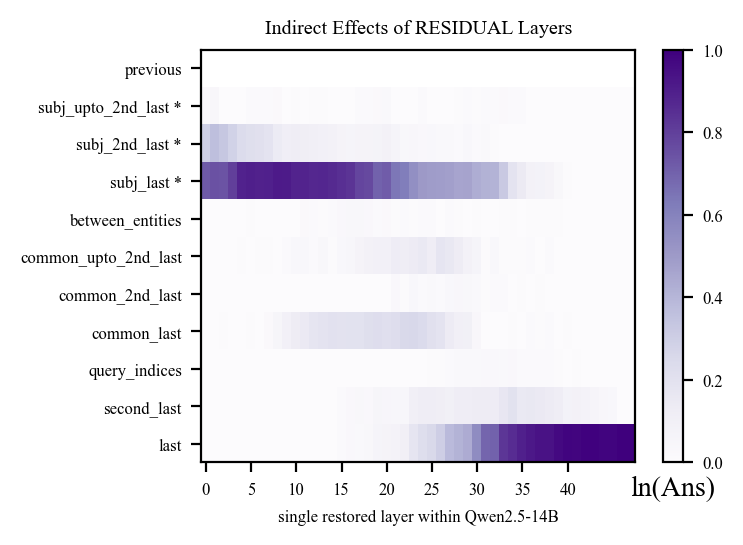

2025-04-15 17:36:23 __main__ INFO     (1/13)  entities=['Germany', 'Japan']
2025-04-15 17:36:23 __main__ INFO     (2/13)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-04-15 17:36:23 __main__ INFO     (3/13)  entities=['Bhutan', 'Nepal']
2025-04-15 17:36:24 __main__ INFO     (4/13)  entities=['Mount Athos', 'Vatican City']
2025-04-15 17:36:24 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-04-15 17:36:24 __main__ INFO     (5/13)  entities=['Dead Sea Scrolls', 'Rosetta Stone']
2025-04-15 17:36:24 __main__ INFO     (6/13)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-04-15 17:36:24 __main__ INFO     (7/13)  entities=['Toph Beifong', 'Daredevil']
2025-04-15 17:36:24 __main__ INFO     (8/13)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-04-15 17:36:24 __main__ INFO     (9/13)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-04-15 17:36:24 __main__ INFO     (10/13)  entities=['Whale', 'Elephant']
2025-04-15 17:36:24 __main__ INFO     (11/13)  entiti

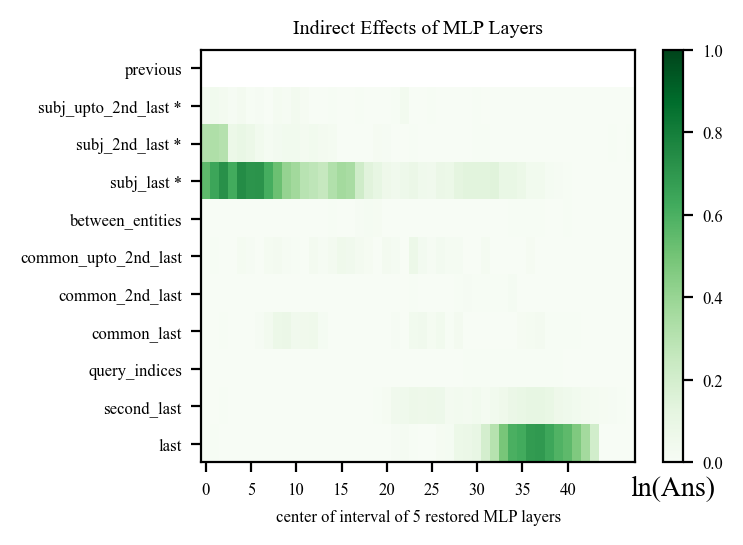

2025-04-15 17:36:24 __main__ INFO     (1/13)  entities=['Germany', 'Japan']
2025-04-15 17:36:24 __main__ INFO     (2/13)  entities=['Hugh Jackman', 'Ryan Reynolds']
2025-04-15 17:36:24 __main__ INFO     (3/13)  entities=['Bhutan', 'Nepal']
2025-04-15 17:36:24 __main__ INFO     (4/13)  entities=['Mount Athos', 'Vatican City']
2025-04-15 17:36:24 __main__ WARNING  Skipping Mount Athos__<>__Italy.npz
2025-04-15 17:36:24 __main__ INFO     (5/13)  entities=['Dead Sea Scrolls', 'Rosetta Stone']
2025-04-15 17:36:24 __main__ INFO     (6/13)  entities=['Leonardo da Vinci', 'Benjamin Franklin']
2025-04-15 17:36:24 __main__ INFO     (7/13)  entities=['Toph Beifong', 'Daredevil']
2025-04-15 17:36:24 __main__ INFO     (8/13)  entities=['Julius Caesar', 'Nepoleon Bonaparte']
2025-04-15 17:36:24 __main__ INFO     (9/13)  entities=['Christopher Columbus', 'Vasco da Gama']
2025-04-15 17:36:24 __main__ INFO     (10/13)  entities=['Whale', 'Elephant']
2025-04-15 17:36:24 __main__ INFO     (11/13)  entiti

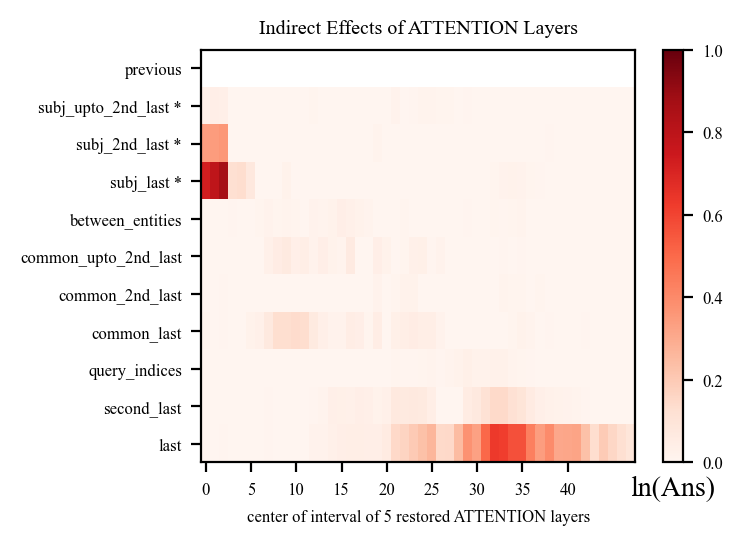

In [ ]:
from src.plotting import plot_trace_heatmap

for kind in ["residual", "mlp", "attention"]:
    look_dir = os.path.join(
        env_utils.DEFAULT_RESULTS_DIR, model_name, "causal_tracing_keywords", kind
    )

    categorized_effects = []
    window, metric = None, None
    for idx, c in enumerate(coincidences["examples"]):
        entities = c["entity_pair"]
        logger.info(f"({idx + 1}/{len(coincidences['examples'])})  {entities=}")

        common_entity = entities[1]
        patch_entity = entities[0]
        clean_entity = c["alt_first"]["entity"]

        file_name = f"{patch_entity}__<>__{clean_entity}.npz"
        if file_name not in os.listdir(look_dir):
            logger.warning(f"Skipping {file_name}")
            continue

        trace_res = CausalTracingResult.from_npz(os.path.join(look_dir, file_name))
        window = trace_res.window
        metric = trace_res.metric
        token_ranges = get_token_ranges(mt, trace_res, common_entity=common_entity)
        categorized_effects.append(
            get_categorized_indirect_effects(trace_res, token_ranges)
        )

    aie = average_indirect_effects(
        categorized_effects=categorized_effects,
        kind=kind,
        window=window,
        metric=metric,
    )

    plot_trace_heatmap(
        result=aie,
        model_name=model_name,
        scale_range=(0, 1) if aie.normalized == True else None,
    )

In [ ]:
"".join(trace_res.patch_input_toks[trace_res.subj_range[1] + 1 : -8]).strip()

'crab'

In [ ]:
for idx in range(len(indirect_effects_collection)):
    trace_res = indirect_effects_collection[idx]
    print(trace_res.answer)
    # common_entity = "".join(trace_res.patch_input_toks[trace_res.subj_range[1] + 1: -8]).strip()
    # print(f"{common_entity=}")
    # token_ranges = get_token_ranges(
    #     mt, trace_res, common_entity=common_entity
    # )
    # categorized_effects = get_categorized_indirect_effects(trace_res, token_ranges)
    # aie = average_indirect_effects(
    #     categorized_effects=[categorized_effects],
    #     kind="residual",
    #     window=1,
    #     metric="logit",
    # )

    plot_trace_heatmap(
        # result=aie,
        result=trace_res,
        model_name=model_key.split("/")[-1],
        scale_range=(0, 1) if aie.normalized == True else None,
    )

[PredictedToken(token=' Axis', prob=None, logit=18.625, token_id=34474), PredictedToken(token=' powers', prob=None, logit=13.5625, token_id=13430), PredictedToken(token=' World', prob=None, logit=16.0, token_id=4337), PredictedToken(token=' War', prob=None, logit=8.0, token_id=5004), PredictedToken(token=' II', prob=None, logit=6.84375, token_id=7946)]


NameError: name 'aie' is not defined

## Introspection Experiment (similar to `Patchscope`)

In [ ]:
placeholder_entities = ("one", "two")
placeholder_prompt = prepare_probing_input(
    mt=mt,
    entities=placeholder_entities,
    prefix=prefix,
    answer_marker=answer_marker,
    question_marker=question_marker,
    block_separator=block_separator,
    is_a_reasoning_model="deepseek" in model_key.lower(),
    # is_a_reasoning_model=True
    answer_prefix=" They are/were both",
    # answer_prefix = " They are both used to say"
)

In [ ]:
# entities = (entities[1], entities[0])
entities

('Bruce Wayne', 'Tony Stark')

In [ ]:

st = mt.tokenizer.pad_token * (prompt.entity_ranges[0][0] - 4) + f"\nQ: {entities[0]}"
inp = prepare_input(prompts=st, tokenizer=mt, return_offsets_mapping=True)
find_token_range(
    string=st, substring=entities[0], tokenizer=mt, offset_mapping=inp.offset_mapping[0]
)

(206, 208)

In [ ]:
prompt.entity_ranges

((206, 208), (209, 211))

In [ ]:
for idx, t in list(enumerate(prompt.tokenized["input_ids"][0]))[206:]:
    print(f'{idx} => "{mt.tokenizer.decode(t)}"')

206 => " Bruce"
207 => " Wayne"
208 => " and"
209 => " Tony"
210 => " Stark"
211 => "
"
212 => "A"
213 => ":"
214 => " They"
215 => " are"
216 => "/w"
217 => "ere"
218 => " both"


In [ ]:
for idx, t in list(enumerate(inp["input_ids"][0]))[206:]:
    print(f'{idx} => "{mt.tokenizer.decode(t)}"')

206 => " Bruce"
207 => " Wayne"


In [ ]:
from src.functional import get_hs, extract_rep_at_pos
from src.utils.typing import TokenizerOutput

bare_hs = [
    extract_rep_at_pos(
        mt=mt,
        input=f" {ent}",
        total_length=ent_rng[1],
        locations=[
            (layer, ent_rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names
        ],
    )
    for ent, ent_rng in zip(entities, prompt.entity_ranges)
]

In [ ]:
icl_hs = [
    get_hs(
        mt=mt,
        input=TokenizerOutput(data=prompt.tokenized),
        locations=[
            (layer, rng[1] - 1) for layer in [mt.embedder_name] + mt.layer_names
        ],
        return_dict=True,
    )
    for ent, rng in zip(entities, prompt.entity_ranges)
]

In [ ]:
from src.functional import PatchSpec
from src.functional import generate_with_patch
from src.utils.typing import TokenizerOutput

print(entities)

clean_pred = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=prompt.tokenized),
)
clean_pred

('Christopher Columbus', 'Vasco da Gama')


[[PredictedToken(token=' explor', prob=0.454833984375, logit=18.71875, token_id=48539),
  PredictedToken(token=' famous', prob=0.208251953125, logit=17.9375, token_id=11495),
  PredictedToken(token=' Portuguese', prob=0.0655517578125, logit=16.78125, token_id=43288),
  PredictedToken(token=' sailors', prob=0.03912353515625, logit=16.265625, token_id=69938),
  PredictedToken(token=' European', prob=0.03619384765625, logit=16.1875, token_id=7665)]]

In [ ]:
## bare hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(
    bare_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges
):
    token_pos = placeholder_range[0]
    patches.extend(
        [
            PatchSpec(
                location=(layer, token_pos),
                # patch = ent_hs[(layer, -1)]
                patch=ent_hs[(layer, ent_range[1] - 1)],
            )
            for layer in mt.layer_names
        ]
    )


pred, track_ans = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id],
)

# gen = generate_with_patch(
#     mt = mt,
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])
print(track_ans)
pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.2470703125, logit=16.40625, token_id=90386),
  PredictedToken(token=' fictional', prob=0.09906005859375, logit=15.4921875, token_id=44682),
  PredictedToken(token=' American', prob=0.059600830078125, logit=14.984375, token_id=3778),
  PredictedToken(token=' actors', prob=0.05096435546875, logit=14.828125, token_id=20142),
  PredictedToken(token=' billionaire', prob=0.044281005859375, logit=14.6875, token_id=47794)]]

In [ ]:
# patch only the last token from ICL_hs

patches = []
for ent_hs, placeholder_range, ent_range in zip(
    icl_hs, placeholder_prompt.entity_ranges, prompt.entity_ranges
):
    token_pos = placeholder_range[0]
    patches.extend(
        [
            PatchSpec(
                location=(layer, token_pos),
                # patch = ent_hs[(layer, -1)]
                patch=ent_hs[(layer, ent_range[1] - 1)],
            )
            for layer in mt.layer_names
        ]
    )

pred, track_ans = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=placeholder_prompt.tokenized),
    patches=patches,
    token_of_interest=[clean_pred[0][0].token_id],
)

# gen = generate_with_patch(
#     mt = mt,
#     inputs = TokenizerOutput(data = placeholder_prompt.tokenized),
#     patches = patches,
#     do_sample=False
# )

# print(gen[0])

print(track_ans)

pred

[{90386: (1, PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386))}]


[[PredictedToken(token=' billionaires', prob=0.282470703125, logit=17.5625, token_id=90386),
  PredictedToken(token=' billionaire', prob=0.1610107421875, logit=17.0, token_id=47794),
  PredictedToken(token=' fictional', prob=0.14892578125, logit=16.921875, token_id=44682),
  PredictedToken(token=' superheroes', prob=0.03704833984375, logit=15.53125, token_id=91818),
  PredictedToken(token=' the', prob=0.033203125, logit=15.421875, token_id=279)]]

In [ ]:
from src.functional import predict_next_token

single_probing_prompt = "Who/what is {}? Answer: {} is a"

pred, track_ans = predict_next_token(
    mt=mt,
    inputs=[single_probing_prompt.format(entities[0], entities[0])],
    k=15,
    token_of_interest=[clean_pred[0][0].token_id],
)

print(track_ans)
pred

[{48539: (3345, PredictedToken(token=' explor', prob=1.4126300811767578e-05, logit=4.78515625, token_id=48539))}]


[[PredictedToken(token=' man', prob=0.0650634765625, logit=13.21875, token_id=893),
  PredictedToken(token=' fictional', prob=0.034027099609375, logit=12.5703125, token_id=44682),
  PredictedToken(token=' myth', prob=0.03375244140625, logit=12.5625, token_id=21849),
  PredictedToken(token=' hero', prob=0.0307464599609375, logit=12.46875, token_id=12084),
  PredictedToken(token=' person', prob=0.0290985107421875, logit=12.4140625, token_id=1732),
  PredictedToken(token=' famous', prob=0.028656005859375, logit=12.3984375, token_id=11495),
  PredictedToken(token=' ', prob=0.0207977294921875, logit=12.078125, token_id=220),
  PredictedToken(token=' symbol', prob=0.0206451416015625, logit=12.0703125, token_id=7891),
  PredictedToken(token=' very', prob=0.0190887451171875, logit=11.9921875, token_id=1633),
  PredictedToken(token=' white', prob=0.018218994140625, logit=11.9453125, token_id=4251),
  PredictedToken(token=' historical', prob=0.0179290771484375, logit=11.9296875, token_id=13970),

In [ ]:
pred, track_ans = predict_next_token(
    mt=mt,
    inputs=single_probing_prompt.format(entities[1], entities[1]),
    k=15,
    token_of_interest=[clean_pred[0][0].token_id],
)

print(track_ans)
pred

[{48539: (3180, PredictedToken(token=' explor', prob=1.3887882232666016e-05, logit=4.05859375, token_id=48539))}]


[[PredictedToken(token=' Portuguese', prob=0.2646484375, logit=13.9140625, token_id=43288),
  PredictedToken(token=' famous', prob=0.0341796875, logit=11.8671875, token_id=11495),
  PredictedToken(token=' port', prob=0.032623291015625, logit=11.8203125, token_id=2700),
  PredictedToken(token=' ', prob=0.0294647216796875, logit=11.71875, token_id=220),
  PredictedToken(token=' person', prob=0.0244293212890625, logit=11.53125, token_id=1732),
  PredictedToken(token=' character', prob=0.01528167724609375, logit=11.0625, token_id=3752),
  PredictedToken(token=' city', prob=0.0123748779296875, logit=10.8515625, token_id=3363),
  PredictedToken(token=' Brazilian', prob=0.0104217529296875, logit=10.6796875, token_id=36083),
  PredictedToken(token=' town', prob=0.0101776123046875, logit=10.65625, token_id=6424),
  PredictedToken(token=' name', prob=0.00986480712890625, logit=10.625, token_id=836),
  PredictedToken(token=' ship', prob=0.0095672607421875, logit=10.59375, token_id=8448),
  Predic

In [ ]:
# layer = mt.layer_name_format.format(16)

# bare_hs_pair = (
#     bare_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     bare_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

# enriched_hs_pair = (
#     icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
#     icl_hs[1][(layer, prompt.entity_ranges[1][1] - 1)],
# )

In [ ]:
# torch.cosine_similarity(
#     bare_hs_pair[0],
#     bare_hs_pair[1],
#     dim=-1
# )

In [ ]:
# torch.cosine_similarity(
#     enriched_hs_pair[0],
#     enriched_hs_pair[1],
#     dim=-1
# )

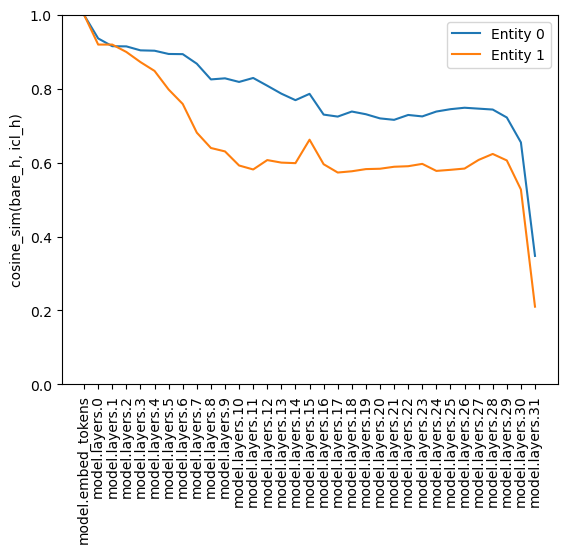

In [ ]:
similarity_0 = []
similarity_1 = []

for layer in [mt.embedder_name] + mt.layer_names:
    entity_pos_0 = prompt.entity_ranges[0][1] - 1
    sim_0 = torch.cosine_similarity(
        bare_hs[0][(layer, entity_pos_0)], icl_hs[0][(layer, entity_pos_0)], dim=-1
    )

    similarity_0.append(sim_0.item())

    entity_pos_1 = prompt.entity_ranges[1][1] - 1
    sim_1 = torch.cosine_similarity(
        bare_hs[1][(layer, entity_pos_1)], icl_hs[1][(layer, entity_pos_1)], dim=-1
    )

    similarity_1.append(sim_1.item())

# print(f"{layer}: {sim_0.item()=}, {sim_1.item()=}")

from matplotlib import pyplot as plt

plt.plot(similarity_0, label="Entity 0")
plt.plot(similarity_1, label="Entity 1")

plt.legend()
plt.ylim(0, 1)
plt.ylabel("cosine_sim(bare_h, icl_h)")

plt.xticks(range(mt.n_layer + 1), [mt.embedder_name] + mt.layer_names, rotation=90)
plt.show()

### Use the corner as introspection point

2025-02-10 13:24:34 src.operators.estimators INFO     What is the nationality of X? Answer:  |>> self.placeholder_pos=7 | self.inputs['input_ids'].shape=torch.Size([1, 11])
[' British', ' American', ' French', ' German', ' Italian', ' Spanish', ' Russian', ' Chinese', ' Japanese', ' Indian']
2025-02-10 13:24:34 src.operators.estimators INFO     Initialized to [PredictedToken(token='1', prob=0.486572265625, logit=20.109375, token_id=16), PredictedToken(token='2', prob=0.168212890625, logit=19.046875, token_id=17), PredictedToken(token='3', prob=0.1036376953125, logit=18.5625, token_id=18), PredictedToken(token='10', prob=0.0445556640625, logit=17.71875, token_id=605), PredictedToken(token='4', prob=0.02423095703125, logit=17.109375, token_id=19)]


100%|██████████| 200/200 [00:17<00:00, 11.34it/s]


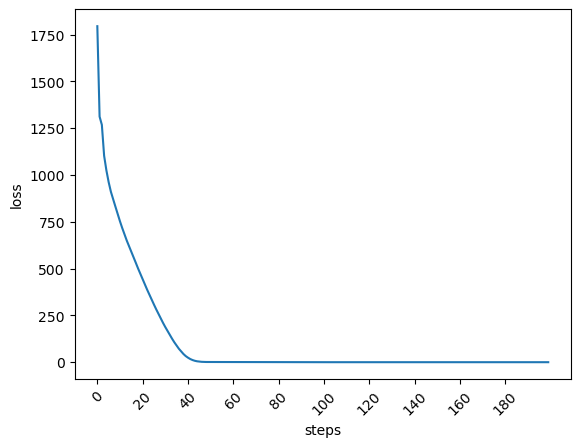

2025-02-10 13:24:52 src.operators.estimators INFO     Tuned to: [PredictedToken(token=' Japanese', prob=0.08056640625, logit=20.0, token_id=11002), PredictedToken(token=' Russian', prob=0.08056640625, logit=20.0, token_id=8690), PredictedToken(token=' Chinese', prob=0.08056640625, logit=20.0, token_id=8620), PredictedToken(token=' German', prob=0.07928466796875, logit=19.984375, token_id=6063), PredictedToken(token=' American', prob=0.07928466796875, logit=19.984375, token_id=3778)]


In [ ]:
from src.operators.estimators import CornerEstimator

estimator = CornerEstimator(
    mt=mt,
    layer_name=mt.layer_names[2],
    verbose=True,
    prompt="What is the nationality of X? Answer: ",
    placeholder="X",
)

# with open(
#     os.path.join(
#         env_utils.DEFAULT_DATA_DIR,
#         "object_mappings",
#         "professions.json"
#         # "colors.json"
#     ), "r"
# ) as f:
#     objects = json.load(f)
# # objects = [f" {c}" for c in objects]
# objects = [" Christian", " Muslim", " Hindu", " Buddhist", " Sikh", " Jewish", " Atheist", " Agnostic", " Deist", " Pagan"]
# objects = [" red", " blue", " green", " yellow", " orange", " purple", " pink", " black", " white", " grey"]
objects = [
    " British",
    " American",
    " French",
    " German",
    " Italian",
    " Spanish",
    " Russian",
    " Chinese",
    " Japanese",
    " Indian",
]

token_indices = (
    mt.tokenizer(
        objects,
        add_special_tokens=False,
        return_tensors="pt",
        padding=True,
        padding_side="right",
    )
    .input_ids[:, 0]
    .tolist()
)
print([mt.tokenizer.decode(t) for t in token_indices])

corner = estimator.estimate(
    class_indices=token_indices,
    n_steps=200,
    # space="prob",
    target_val=20,
    # concept_subspace_regularizer=0.1
    weight_decay=5e-4,
)

In [ ]:
placeholder_prompt.entity_ranges

((206, 207), (208, 209))

In [ ]:
entities

('Rafael Nadal', 'Javier Bardem')

In [ ]:
corner_pos = placeholder_prompt.entity_ranges[1][0]
entity_pos = placeholder_prompt.entity_ranges[0][0]

# corner_pos = placeholder_prompt.entity_ranges[0][0]
# entity_pos = placeholder_prompt.entity_ranges[1][0]

corner_patch = []
for layer in mt.layer_names:
    corner_patch.append(PatchSpec(location=(layer, corner_pos), patch=corner.corner))
    corner_patch.append(
        PatchSpec(
            location=(layer, entity_pos),
            patch=icl_hs[0][(layer, prompt.entity_ranges[0][1] - 1)],
            # patch = corner.corner
        )
    )


pred, track_ans = predict_next_token(
    mt=mt,
    inputs=TokenizerOutput(data=placeholder_prompt.tokenized),
    patches=corner_patch,
    k=20,
    token_of_interest=[token_indices],
)

pred

[[PredictedToken(token=' tennis', prob=0.51953125, logit=17.546875, token_id=32515),
  PredictedToken(token=' professional', prob=0.2132568359375, logit=16.65625, token_id=6721),
  PredictedToken(token=' athletes', prob=0.0212860107421875, logit=14.3515625, token_id=23579),
  PredictedToken(token=' Spanish', prob=0.0201416015625, logit=14.296875, token_id=15506),
  PredictedToken(token=' world', prob=0.016448974609375, logit=14.09375, token_id=1917),
  PredictedToken(token=' ranked', prob=0.0161895751953125, logit=14.078125, token_id=21682),
  PredictedToken(token=' active', prob=0.0141754150390625, logit=13.9453125, token_id=4642),
  PredictedToken(token=' top', prob=0.011749267578125, logit=13.7578125, token_id=1948),
  PredictedToken(token=' famous', prob=0.0088043212890625, logit=13.46875, token_id=11495),
  PredictedToken(token=' number', prob=0.00873565673828125, logit=13.4609375, token_id=1396),
  PredictedToken(token=' players', prob=0.007648468017578125, logit=13.328125, token

In [ ]:
from src.functional import logit_lens

logit_lens(
    mt=mt,
    h=bare_hs[0][(mt.layer_names[25], prompt.entity_ranges[0][1] - 1)],
    interested_tokens=token_indices,
)

([PredictedToken(token=' Rafael', prob=0.06689453125, logit=10.5859375, token_id=55500),
  PredictedToken(token=' ATP', prob=0.0643310546875, logit=10.546875, token_id=67656),
  PredictedToken(token=' Roland', prob=0.028564453125, logit=9.734375, token_id=58906),
  PredictedToken(token=' tennis', prob=0.021392822265625, logit=9.4453125, token_id=32515),
  PredictedToken(token=' Wimbledon', prob=0.0208892822265625, logit=9.421875, token_id=91257)],
 {15506: (36,
   PredictedToken(token=' Spanish', prob=0.0016050338745117188, logit=6.85546875, token_id=15506)),
  8753: (167,
   PredictedToken(token=' French', prob=0.00035953521728515625, logit=5.359375, token_id=8753)),
  7904: (1637,
   PredictedToken(token=' Indian', prob=5.632638931274414e-05, logit=3.505859375, token_id=7904)),
  6063: (3358,
   PredictedToken(token=' German', prob=3.0875205993652344e-05, logit=2.904296875, token_id=6063)),
  15155: (4648,
   PredictedToken(token=' Italian', prob=2.3066997528076172e-05, logit=2.61328